In [3]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import shutil

In [2]:
import numpy as np
import scipy.stats
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import string
import random
# from mpl_toolkits import basemap   # matplotlib==3.2.2 needed
import os
import torch
import sys
import numpy as np
import scipy
import matplotlib.pyplot as plt
# import statsmodels.api as sm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
# from hydroDL import utils
import string
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# sys.path.append(r"G:\Farshid\CONUS_Temp\Example3")
# sys.path.append(r"G:\Farshid\GitHub\PGML_STemp")   # PATH TO THE CODE
# from core.hydroDL import master, utils

In [4]:
def statError(pred, target):
    ngrid, nt = pred.shape  # I changed it



    #############################################
    # Bias
    Bias = np.nanmean(pred - target, axis=1)
    # RMSE

   ## RMSE = np.sqrt(np.nanmean((pred - target)**2, axis=1))
    # ubRMSE
   ## predMean = np.tile(np.nanmean(pred, axis=1), (nt, 1)).transpose()
   ## targetMean = np.tile(np.nanmean(target, axis=1), (nt, 1)).transpose()
   ## predAnom = pred - predMean.

  ##  targetAnom = target - targetMean
  ##  ubRMSE = np.sqrt(np.nanmean((predAnom - targetAnom)**2, axis=1))
    #defining RNSE & ubRMSE & flat metrics
    RMSE = np.full(ngrid, np.nan)
    MSE = np.full(ngrid, np.nan)
    ubRMSE = np.full(ngrid, np.nan)
    predflat = []
    targetflat = []
    # rho R2 NSE
    Corr = np.full(ngrid, np.nan)
    R2 = np.full(ngrid, np.nan)
    NSE = np.full(ngrid, np.nan)

    PBiaslow = np.full(ngrid, np.nan)
    PBiashigh = np.full(ngrid, np.nan)
    PBias = np.full(ngrid, np.nan)
    KGE = np.full(ngrid, np.nan)
    KGE12 = np.full(ngrid, np.nan)
    for k in range(0, ngrid):
        x = pred[k, :]
        y = target[k, :]
        ind = np.where(np.logical_and(~np.isnan(x), ~np.isnan(y)))[0]
        if ind.shape[0] > 0:
            xx = x[ind]
            yy = y[ind]
            # RMSE by Farshid
            RMSE[k] = np.sqrt(np.nanmean((xx - yy) ** 2))
            MSE[k] = (np.nanmean((xx - yy) ** 2))
            predMean = np.tile(np.nanmean(xx), (len(xx))).transpose()
            targetMean = np.tile(np.nanmean(yy), (len(yy))).transpose()
            predAnom = xx - predMean
            targetAnom = yy - targetMean
            ubRMSE[k] = np.sqrt(np.nanmean((predAnom - targetAnom) ** 2))
            predflat = np.append(predflat, xx)
            targetflat = np.append(targetflat, yy)


            # percent bias
            PBias[k] = np.sum(xx - yy) / np.sum(yy) * 100

            # FHV the peak flows bias 10%
            # FLV the low flows bias bottom 30%, log space
            pred_sort = np.sort(xx)
            target_sort = np.sort(yy)
            indexlow = round(0.3 * len(pred_sort))
            indexhigh = round(0.9 * len(pred_sort))
            lowpred = pred_sort[:indexlow]
            highpred = pred_sort[indexhigh:]
            lowtarget = target_sort[:indexlow]
            hightarget = target_sort[indexhigh:]
            PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
            PBiashigh[k] = np.sum(highpred - hightarget) / np.sum(hightarget) * 100

            if ind.shape[0] > 1:
                # Theoretically at least two points for correlation
                Corr[k] = scipy.stats.pearsonr(xx, yy)[0]
                yymean = yy.mean()
                yystd = np.std(yy)
                xxstd = np.std(xx)
                SST = np.sum((yy-yymean)**2)
                SSReg = np.sum((xx-yymean)**2)
                SSRes = np.sum((yy-xx)**2)
                NSE[k] = 1-SSRes/SST
                xxmean = xx.mean()
                R2[k] = ((np.sum((yy-yymean)*(xx-xxmean))) / (((np.sum((yy-yymean)**2)) ** 0.5)*(np.sum((xx - xxmean)**2)) ** 0.5))**2
                KGE[k] = 1 - np.sqrt((Corr[k]-1)**2 + (xxstd/yystd-1)**2 + (xxmean/yymean-1)**2)
                KGE12[k] = 1 - np.sqrt((Corr[k] - 1) ** 2 + ((xxstd*yymean)/ (yystd*xxmean) - 1) ** 2 + (xxmean / yymean - 1) ** 2)
                




    ## use flatted pred and target to have one value for Bias, RMSE, ubRMSE
    predflat = np.array(predflat).flatten()
    targetflat = np.array(targetflat).flatten()
    Biasflat = np.nanmean(predflat-targetflat)
    absBiasflat = np.nanmean(abs(predflat-targetflat))
    RMSEflat = np.sqrt(np.nanmean((predflat-targetflat)**2))
    ubRMSEflat=np.sqrt(((RMSEflat)**2)-((Biasflat)**2))
    ind = np.where(np.logical_and(~np.isnan(predflat), ~np.isnan(targetflat)))[0]
    if ind.shape[0] > 0:
        xx = predflat[ind]
        yy = targetflat[ind]
        corrflat = scipy.stats.pearsonr(xx, yy)[0]
    else:
        corrflat=0
    NSEflat = 1 - ((np.nansum((predflat-targetflat)**2))/(np.nansum((targetflat - np.nanmean(targetflat))**2)))

    outDict = dict(Bias=Bias, RMSE=RMSE, ubRMSE=ubRMSE, Corr=Corr, R2=R2, NSE=NSE,
                   FLV=PBiaslow, FHV=PBiashigh, PBias=PBias, Biasflat=Biasflat,
                   absBiasflat=absBiasflat, RMSEflat=RMSEflat, ubRMSEflat=ubRMSEflat,
                   corrflat=corrflat, NSEflat=NSEflat, MSE=MSE, KGE=KGE, KGE12=KGE12)  #
    return outDict

In [5]:
def plotBoxFig(data,
               label1=None,
               label2=None,
               colorLst=[ 'darkblue', 'blue', 'red',  'deepskyblue', 'black', 'darkred','pink', 'gray', 'lightgray',
                         'silver', 'darkred', 'orchid',  'brown', 'black', 'darkred','pink', 'gray', 'lightgray',
                        'darkblue', 'blue', 'red',  'deepskyblue', 'black', 'darkred','pink', 'gray', 'lightgray'],
               title=None,
               figsize=(10, 8),
               sharey=True,
               xticklabel=None,
               edge_colorLst=None,
               label2_font_size=15,
               label1_font_size=17,
               y_thick_font=26
               
               ):
    nc = len(data)
    fig, axes = plt.subplots(ncols=nc, sharey=sharey, figsize=figsize, constrained_layout=True)
#     lowlim = [-1.25, 0.3, 0.3, 0.72, 0.55, 0.86, 0.75]
#     highlim = [1.01, 1.91, 1.91, 1.001, 1.001, 1.001, 1.01]
#     step = [0.25, 0.2, 0.2, 0.02, 0.05, 0.02, 0.05]
    for k in range(0, nc):
        ax = axes[k] if nc > 1 else axes
        temp = data[k]
        if type(temp) is list:
            for kk in range(len(temp)):
                tt = temp[kk]
                if tt is not None and tt != []:
                    tt = tt[~np.isnan(tt)]
                    temp[kk] = tt
                else:
                    temp[kk] = []
        else:
            temp = temp[~np.isnan(temp)]
        bp = ax.boxplot(temp, patch_artist=True, notch=True, showfliers=False, widths= 0.3, whis=[5, 95])  #  , whis=[5, 95]

        # for kk in range(0, len(bp['caps'])):
        #     plt.setp(bp['caps'][kk], color='blue')
        if edge_colorLst is not None:
            for kk in range(0, len(bp['boxes'])):
                for element in ['boxes']:
                    plt.setp(bp[element][kk], color=edge_colorLst[kk], linewidth=4)

        for kk in range(0, len(bp['boxes'])):
            plt.setp(bp['boxes'][kk], facecolor=colorLst[kk])
        if label1 is not None:
            ax.set_xlabel(label1[k], fontsize=label1_font_size)
            if k==0:
                ax.axhline(y=0, linestyle="--", linewidth=0.75, color="black")
            elif (k==2 or k==3):
                ax.axhline(y=1, linestyle="--", linewidth=0.75, color="black")
        else:
            ax.set_xlabel(str(k))

#         ax.set(ylim = (lowlim[k], highlim[k]))
#         ax.set_yticks(np.arange(lowlim[k], highlim[k], step[k]))
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(y_thick_font)
            
        if xticklabel is None:
            ax.set_xticks([])
        else:
            ax.set_xticks([y+1 for y in range(0,len(data[k]),2)])
            ax.set_xticklabels(xticklabel)
        # ax.ticklabel_format(axis='y', style='sci')
    if label2 is not None:
        if nc == 1:
            ax.legend(bp['boxes'], label2, loc='center', frameon=False, ncol=1, fontsize=label2_font_size)
        else:
            fig.legend(bp['boxes'], label2, loc='lower center', bbox_to_anchor=(0., 1.02, 1., .102), frameon=False, ncol=3, fontsize=label2_font_size, borderaxespad=0.) #it was ax[-1].legend()
           # ax.legend(bp['boxes'], label2, loc='best', frameon=False, ncol=1, fontsize=15)
    if title is not None:
        fig.suptitle(title)
    return fig

In [6]:
def plotMap(data,
            *,
            ax=None,
            lat=None,
            lon=None,
            title=None,
            cRange=None,
            shape=None,
            pts=None,
            figsize=(8, 4),
            clbar=True,
            clim=False,
            cRangeint=False,
            cmap=plt.cm.jet,
            bounding=None,
            s=30,
            prj='cyl',
           fontsize=18):

    if cRange is not None:
        vmin = cRange[0]
        vmax = cRange[1]
    else:
        temp = flatData(data)
        vmin = np.percentile(temp, 5)
        vmax = np.percentile(temp, 95)
        if cRangeint is True:
            vmin = int(round(vmin))
            vmax = int(round(vmax))
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.subplots()
    if len(data.squeeze().shape) == 1:
        isGrid = False
    else:
        isGrid = True

    if bounding is None:
        bounding = [np.min(lat)-0.5, np.max(lat)+0.5,
                    np.min(lon)-0.5,np.max(lon)+0.5]

    mm = basemap.Basemap(
        llcrnrlat=bounding[0],
        urcrnrlat=bounding[1],
        llcrnrlon=bounding[2],
        urcrnrlon=bounding[3],
        projection=prj,
        resolution='c',
        ax=ax)
    mm.drawcoastlines()
    mm.drawstates(linestyle='dashed')
    mm.drawcountries(linewidth=1.0, linestyle='-.')
#     mm.etopo()
#     mm.bluemarble()
#     mm.shadedrelief()
    x, y = mm(lon, lat)
    if isGrid is True:
        xx, yy = np.meshgrid(x, y)
        cs = mm.pcolormesh(xx, yy, data, cmap=cmap, vmin=vmin, vmax=vmax)
        # cs = mm.imshow(
        #     np.flipud(data),
        #     cmap=plt.cm.jet(np.arange(0, 1, 0.1)),
        #     vmin=vmin,
        #     vmax=vmax,
        #     extent=[x[0], x[-1], y[0], y[-1]])
    else:
        cs = mm.scatter(
            x, y, c=data, s=s, cmap=cmap, vmin=vmin, vmax=vmax)

    if shape is not None:
        crd = np.array(shape.points)
        par = shape.parts
        if len(par) > 1:
            for k in range(0, len(par) - 1):
                x = crd[par[k]:par[k + 1], 0]
                y = crd[par[k]:par[k + 1], 1]
                mm.plot(x, y, color='r', linewidth=3)
        else:
            y = crd[:, 0]
            x = crd[:, 1]
            mm.plot(x, y, color='r', linewidth=3)
    if pts is not None:
        mm.plot(pts[1], pts[0], 'k*', markersize=4)
        npt = len(pts[0])
        for k in range(npt):
            plt.text(
                pts[1][k],
                pts[0][k],
                string.ascii_uppercase[k],
                fontsize=18)
    if clbar is True:
        mm.colorbar(cs, pad='5%')
        if clim!=False:
            plt.clim(vmin=clim[0], vmax=clim[1])
    if title is not None:
        ax.set_title(title, fontsize=fontsize)
        if ax is None:
            return fig, ax, mm
        else:
            return mm, cs

In [7]:
def flatData(x, sortOpt=0):
    # sortOpt: 0: small to large, 1: large to small, -1: no sort
    xArrayTemp = x.flatten()
    xArray = xArrayTemp[~np.isnan(xArrayTemp)]
    if sortOpt == 0:
        xSort = np.sort(xArray)
    elif sortOpt == 1:
        xSort = np.sort(xArray)[::-1]
    elif sortOpt == -1:
        xSort = xArray

    return (xSort)

In [8]:
'''
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
'''
def pareto_frontier(Xs, Ys, maxX = True, maxY = True):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] <= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] >= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

In [9]:
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models\PRMS_SNTEMP"

In [184]:

p1 = "new2"
p2 = "PRMS_SNTEMP_204_new_norm"
# p3 = "SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
p3 = r"PRMS_SNTEMP_test\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_4_semi_0_Pstat_2_Psemi_0_nmul_16_s_0"
temp_obs = np.load(os.path.join(p_main, p3,  "temp_obs.npy"))[:,:,0]
tempSim = np.load(os.path.join(p_main, p3, "temp_pred.npy"))[:,:,0]

flow_obs = np.load(os.path.join(p_main, p3, "flow_obs.npy"))[:,:,0]
flowSim_tot = np.load(os.path.join(p_main,p3, "flowSim_tot.npy"))

flowSim = flowSim_tot[:,:, 0]
srflow = flowSim_tot[:,:, 0] - flowSim_tot[:,:, 3] - flowSim_tot[:,:, 4]
ssflow = flowSim_tot[:,:, 4]
gwflow = flowSim_tot[:,:, 3]


t1 = 3288
t2 = 3653

weight_gw = np.flip(np.load(os.path.join(p_main,  p3, "weight_gw.npy")), axis=1)[:,t1:t2,:]
weight_ss = np.flip(np.load(os.path.join(p_main, p3, "weight_ss.npy")), axis=1)[:,-30:,:]
SN_outs = np.load(os.path.join(p_main, p3, "SN_outs.npy"))[:,t1:t2,:]
PET = SN_outs[:,:, 0]
rip = SN_outs[:,:, 1]
topo = SN_outs[:,:, 2]
top_width = SN_outs[:,:, 3]
coef_nom = SN_outs[:,:, 4]
coef_pow = SN_outs[:,:, 5]
hamon_coef = SN_outs[:,:, 6]
lat_temp_adj = SN_outs[:,:, 7]
sr_p = SN_outs[:,:, 8]
ss_p = SN_outs[:,:, 9]
gw_p = SN_outs[:,:, 10]

# Q = x[:,365+t1:365+t2,6]
Q =flowSim # np.load(os.path.join(p_main, p1, p2, p3, "x.npy"))[:,365+t1: 365 +t2,6]

In [214]:
np.nanmin(hamon_coef)

0.0059681083

In [186]:
temp_obs.shape

(50, 3653)

In [187]:
stat_flow = statError(flowSim, flow_obs)
stat_temp = statError(tempSim, temp_obs)

C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:8: RuntimeWarning: Mean of empty slice
  Bias = np.nanmean(pred - target, axis=1)
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:68: RuntimeWarning: invalid value encountered in float_scalars
  PBiashigh[k] = np.sum(highpred - hightarget) / np.sum(hightarget) * 100


In [188]:
print(np.nanmedian(stat_flow["NSE"]))
print(np.nanmedian(stat_temp["NSE"]))

0.5438839362008934
0.9374809190630913


In [189]:
attr50 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003\PRMS_SNTEMP", "attr50.feather"))
attr415 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003\PRMS_SNTEMP", "attr_415_tmean_ccov.feather"))
attr365 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003\PRMS_SNTEMP", "attr365.feather"))

In [190]:
sites50 = attr50["site_no"].to_numpy()
sites415 = attr415["site_no"].to_numpy()
sites365 = attr365["site_no"].to_numpy()

In [191]:
ind50 = []
for i, s in enumerate(sites415):
    if s in sites50:
        ind50.append(i)
ind50 = np.array(ind50)

In [261]:
print(np.nanmedian(stat_flow["NSE"][ind50]))
print(np.nanmedian(stat_temp["NSE"][ind50]))

0.5260930946275527
0.9170027486979961


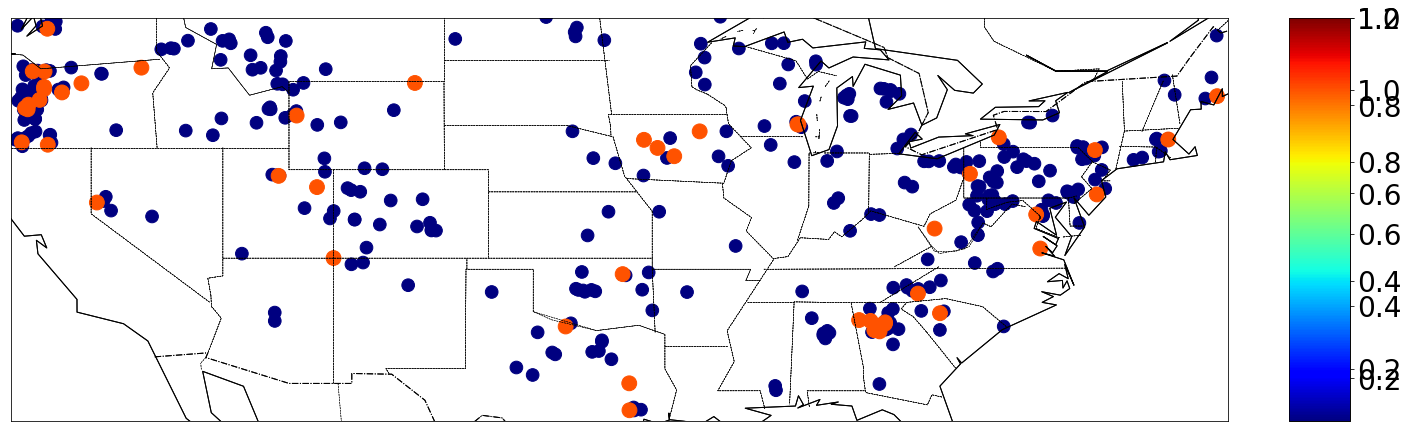

In [239]:
fig, axs = plt.subplots(1, 1, figsize=(24,30))

# axs=axs.flatten()
plt.subplots_adjust( #left=0.1,
#                     bottom=0, 
#                     right=0.9, 
#                     top=0.9, 
                    wspace=0,    # 0.4
                    hspace=0.00)   # 0.4

### for Baseflow index GAGES-II
val365= np.zeros(365) + 1   #attr["BFI_AVE"]/100
plotMap(val365, 
        lat=attr365['lat'],
        lon=attr365['lon'], 
        figsize=(15, 11),
        cmap=plt.cm.jet_r, 
        clim=False,
        cRange=[0.08,1],
#        title='GW + SS for ' + p_list1[i] + "$\ _{noBias}$",
        s=160, 
        ax=axs)

val50 = np.zeros(50) + 1
plotMap(val50, 
        lat=attr50['lat'],
        lon=attr50['lon'], 
        figsize=(15, 11),
        cmap=plt.cm.jet, 
        clim=False,
        cRange=[0.08,1.2],
#        title='GW + SS for ' + p_list1[i] + "$\ _{noBias}$",
        s=220, 
        ax=axs)

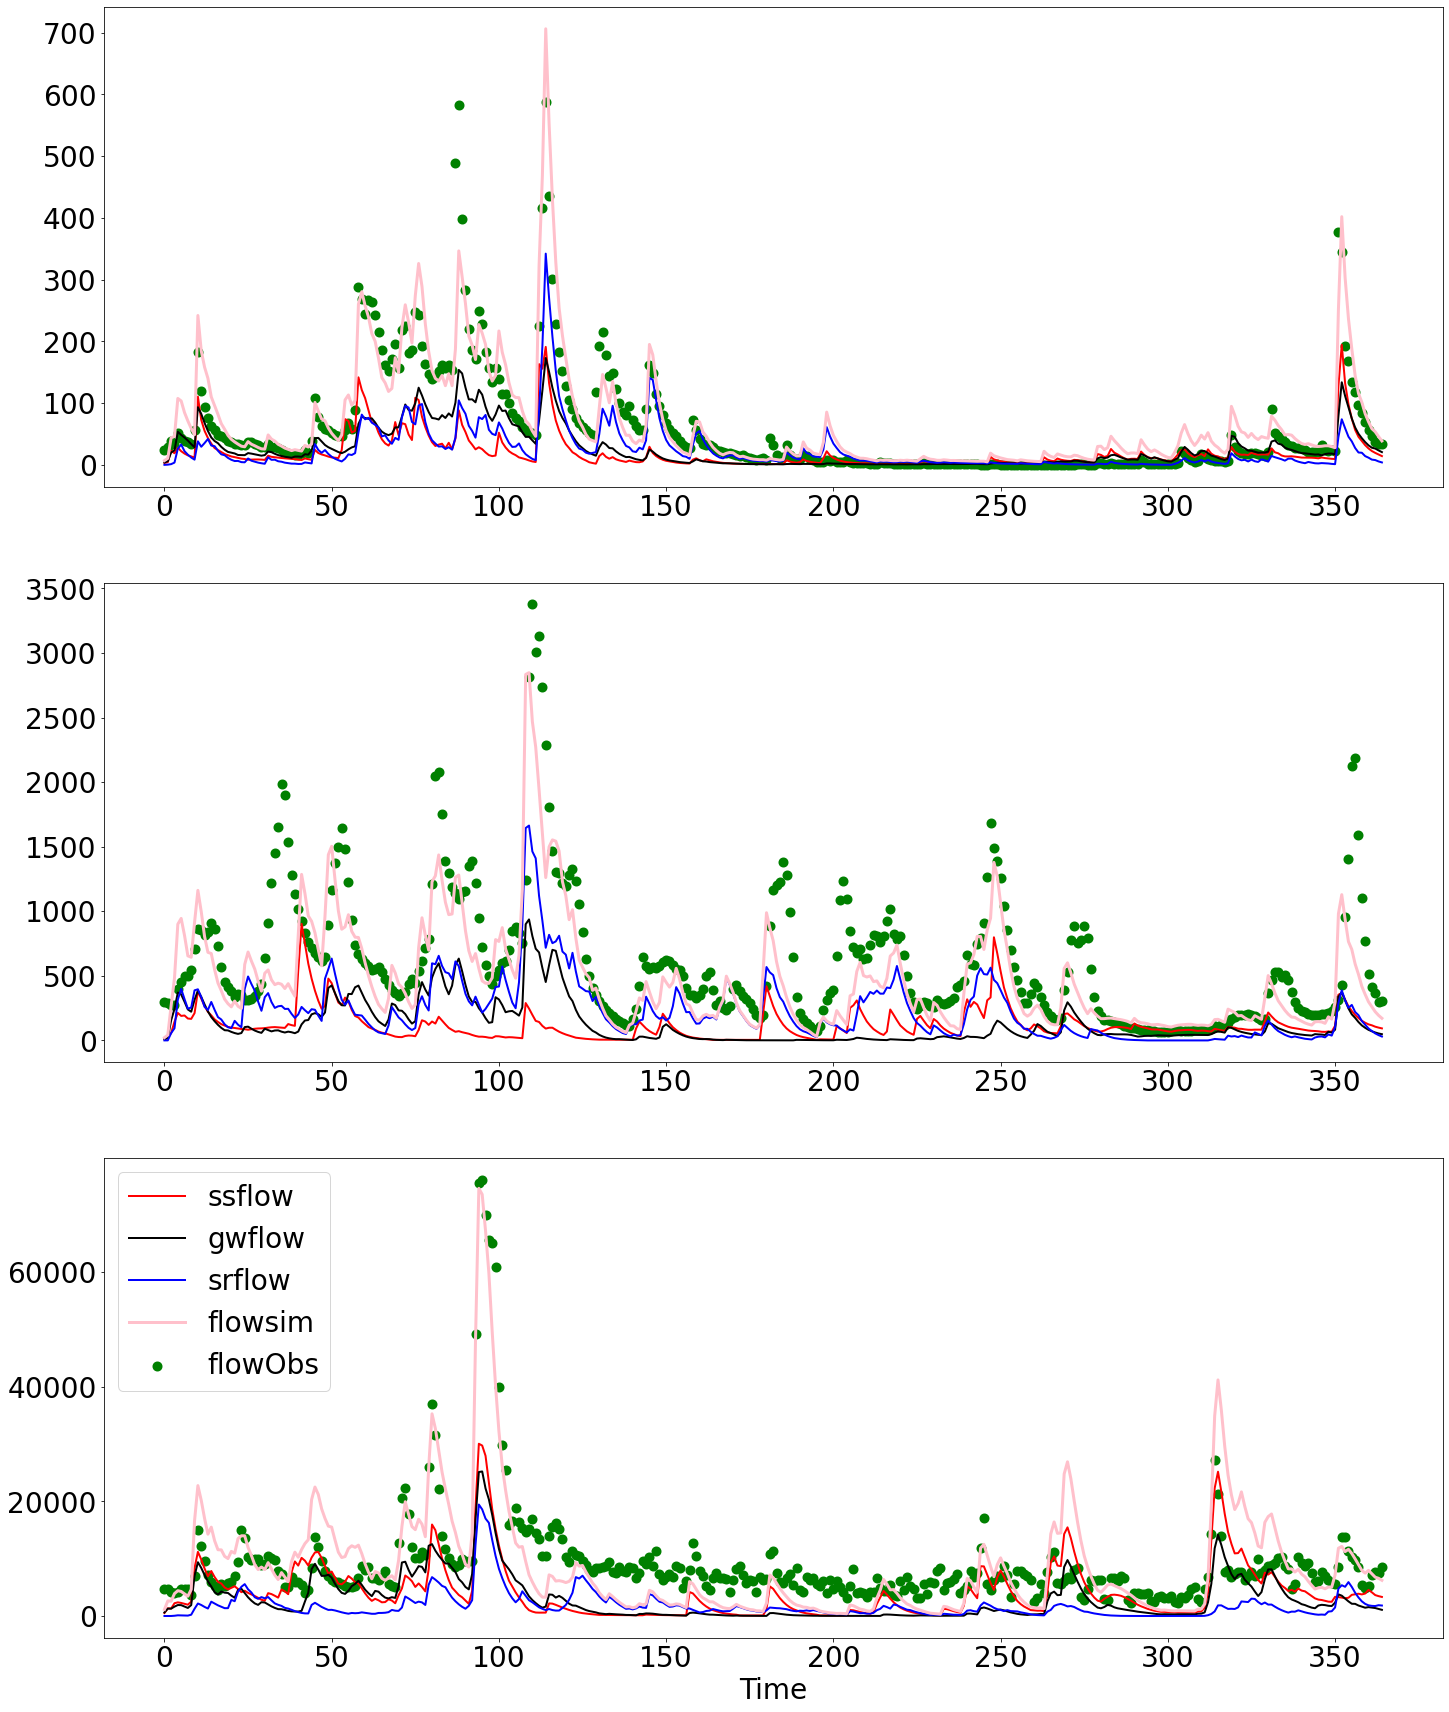

In [196]:
# ss = sites50[350:353]#common_sites[50:53]
ss = [0 , 5, 15]
area = attr50["DRAIN_SQKM"].to_numpy()
fig1, axs = plt.subplots(len(ss), 1, figsize=(24,30))
axs=axs.flatten()
plt.subplots_adjust(wspace=None,    # 0.4
                    hspace=None)
for i, s in enumerate(ss):
#     ind = attr415[attr415["site_no"]==ss[i]].index[0]
    ind = s
    axs[i].plot(range(365), area [ind] * ssflow[ind,:365]  , label='ssflow', color = "red", lw=2)
    axs[i].plot(range(365), area [ind] * gwflow[ind,:365] , label='gwflow', color = "black", lw=2)
    axs[i].plot(range(365), area [ind] * srflow[ind,:365], label='srflow', color = "blue", lw=2)
    axs[i].plot(range(365),  area [ind] * flowSim[ind,:365] , label='flowsim', color = "pink", lw=3)
#     axs[i].plot(range(365),  area [ind] * flow_obs[ind,:365] , label='flowObs', color = "green", lw=4)
    axs[i].scatter(range(365),  area [ind] * flow_obs[ind,:365] , label='flowObs', color = "green", lw=4)
#     axs[i].set_yscale('log')
#     axs[i].plot(range(365), gw_p[ind,365:730]  , label='gw_p', color = "red", lw=2)
#     axs[i].plot(range(365), ss_p[ind,365:730] , label='ss_p', color = "black", lw=2)
#     axs[i].plot(range(365), sr_p[ind,365:730] , label='sr_p', color = "blue", lw=2)
plt.xlabel('Time', fontsize=28)


# plt.ylabel('stream temperature', fontsize=26)

plt.legend()
# met.legend()
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)    # legend fontsize

In [207]:
len(flowSim[flowSim<0])

0

Text(0.5, 1.0, 'baseflow ratio scatter plot, r=0.909')

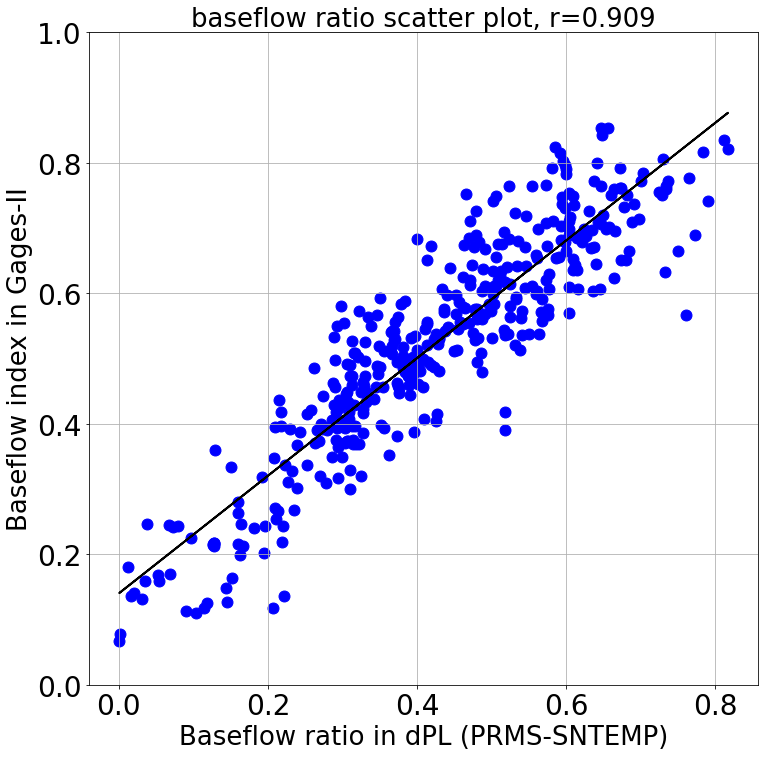

In [261]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

item1 = np.nansum((gwflow [:,:]), axis=1)/np.nansum(flowSim, axis=1)    # + ssflow[:,:]
item2 = attr415["BFI_AVE"]/100
# item2 = attr365["BFI_AVE"]/100
slope, intercept, r, p, se = scipy.stats.linregress(item1 , item2)
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.scatter(item1, item2, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,1)
plt.ylim(0.0, 1)
plt.grid()
plt.xlabel("Baseflow ratio in dPL (PRMS-SNTEMP)", fontsize=26)
plt.ylabel("Baseflow index in Gages-II", fontsize=26)
plt.title("baseflow ratio scatter plot" + ", r=" + str("{:.3f}".format(r)), fontsize=26)

(415, 365)

No handles with labels found to put in legend.


(array([ 300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.,
        1200.]),
 <a list of 10 Text major ticklabel objects>)

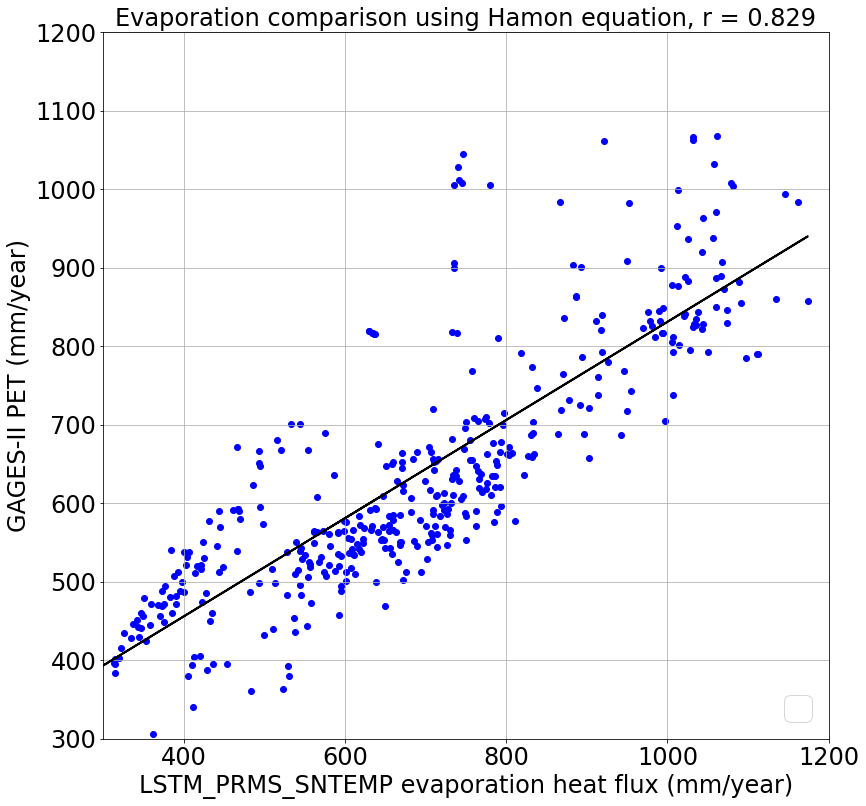

In [502]:
fig = plt.figure(figsize=(13,13))
item1 = (np.nansum(PET, axis=1)).squeeze() * 1000 * 86400
item2 = attr415["PET"]
plt.scatter(item1 , item2,  c="blue")   #label="PET",
# plt.xscale("log")
slope, intercept, r, p, se = scipy.stats.linregress(item1 , item2)
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.xlabel("LSTM_PRMS_SNTEMP evaporation heat flux (mm/year)", fontsize=24)
# plt.ylabel("young_gw fraction (percentage against total streamflow)")
plt.ylabel("GAGES-II PET (mm/year)", fontsize=24)
plt.xlim(300,1200)
plt.ylim(300,1200)
plt.title("Evaporation comparison using Hamon equation, r = " + str("{:.3f}".format(r)),fontsize=24)
plt.grid()
plt.legend(loc = "lower right",fontsize=34)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# PET_test = np.load(os.path.join(r"G:\Farshid\PGML_STemp_results\models\415_sites\hamon_coef_test\Meisner_gw_730_ss_1_adj_T_fr_T75_stat__semi__nmul_16_s_0",
#                   "PET.npy"))
# item3 = (np.nanmean(PET_test, axis=1)).squeeze() * 1000 * 365* 86400
# plt.scatter(item3 , item2,  c="red")

415


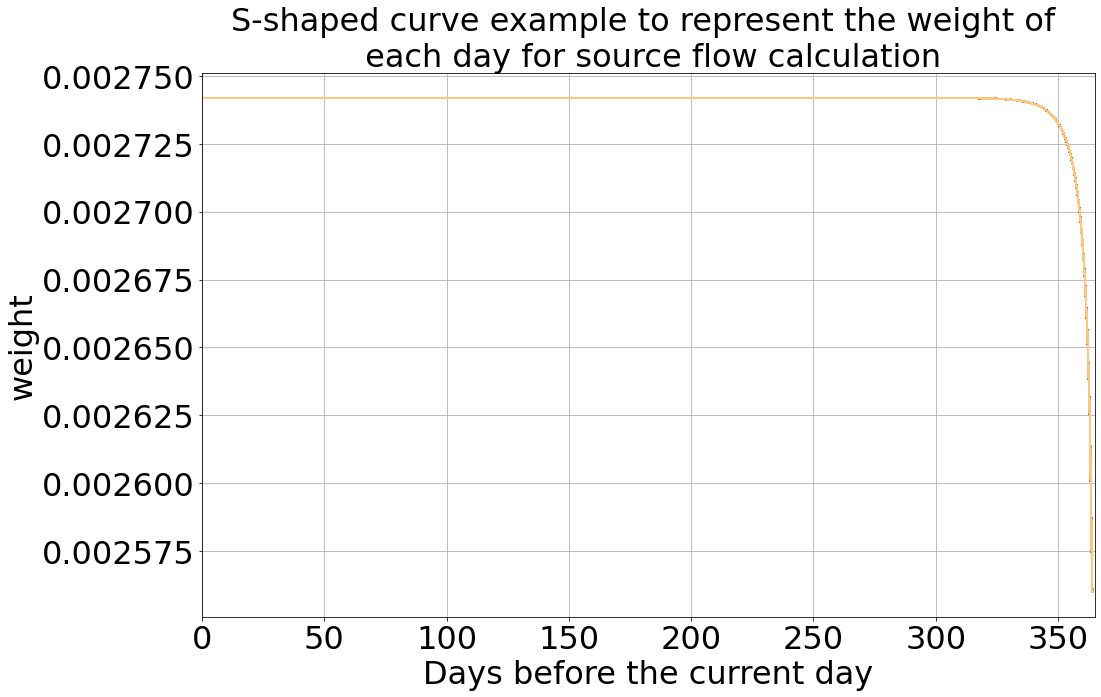

In [268]:
plt.figure(figsize=(16, 10))
copper = plt.get_cmap("copper")
count =0
for i in range(weight_gw.shape[0]):
    if weight_gw[i,0,0] < 0.02:
    #     plt.plot(range(365), weight_gw[400,100,:,0], color = "darkblue", lw=3.5)
        plt.plot(range(365), weight_gw[i,:365,0], color = copper(i), lw=1.5)
#         plt.plot(range(730), weight_gw[i,:,0], color = copper(i), lw=1.5)
        count = count+1
# plt.plot(range(365), weight_gw[400,0,:,0])
plt.xlim(0,365)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid()
plt.ylabel("weight", fontsize=32)
plt.xlabel("Days before the current day", fontsize=32)
plt.title("S-shaped curve example to represent the weight of \n each day for source flow calculation", fontsize=32)
# plt.ylim(0, 0.008)
print(count)

415


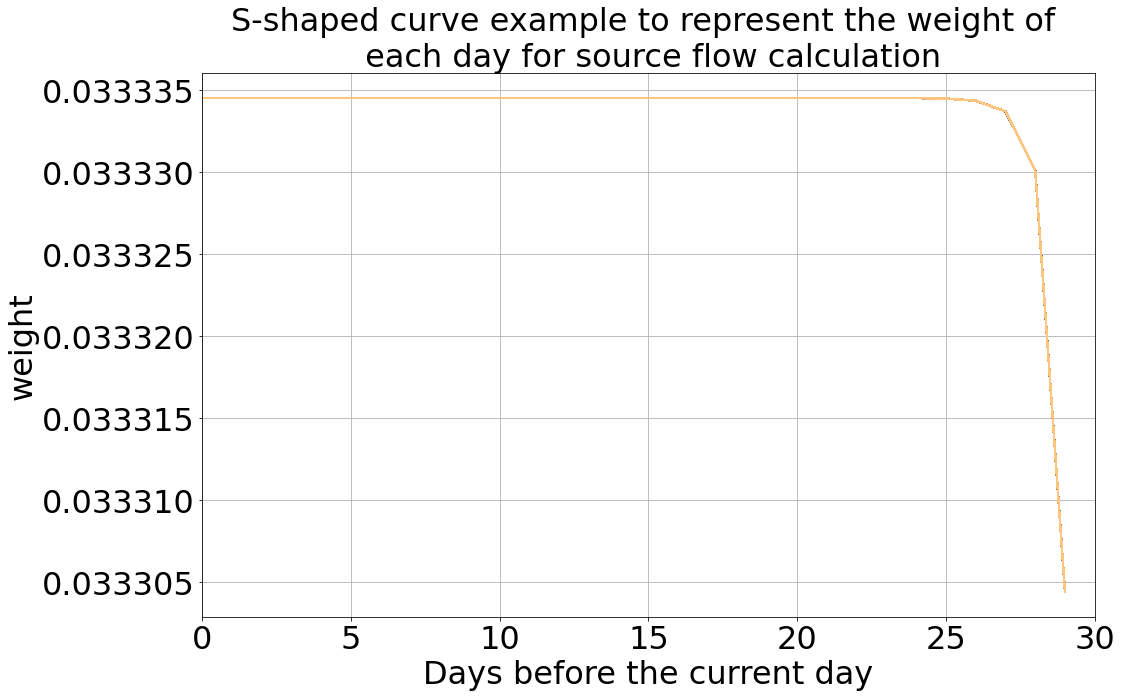

In [269]:
plt.figure(figsize=(16, 10))
copper = plt.get_cmap("copper")
count =0
for i in range(weight_ss.shape[0]):
    if weight_ss[i,0,0] < 0.85:
    #     plt.plot(range(365), weight_gw[400,100,:,0], color = "darkblue", lw=3.5)
        plt.plot(range(30), weight_ss[i,:30,0], color = copper(i), lw=1.5)
#         plt.plot(range(730), weight_gw[i,:,0], color = copper(i), lw=1.5)
        count = count+1
# plt.plot(range(365), weight_gw[400,0,:,0])
plt.xlim(0,30)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid()
plt.ylabel("weight", fontsize=32)
plt.xlabel("Days before the current day", fontsize=32)
plt.title("S-shaped curve example to represent the weight of \n each day for source flow calculation", fontsize=32)
# plt.ylim(0, 0.008)
print(count)

In [91]:
weight_gw.shape

(415, 0, 1)

# only PRMS

In [72]:
# PRMS only on 415 # NSE > 0.674
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models\marrmot_PRMS_only"
p1 = r"PRMS_only_415_208\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
# attr671 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003", "attr_camels_tmean_ccov.feather"))
flow_obs = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim = flowSim_tot[:,:, 0]
srflow = flowSim_tot[:,:, 0] - flowSim_tot[:,:, 3] - flowSim_tot[:,:, 4]
ssflow = flowSim_tot[:,:, 4]
gwflow = flowSim_tot[:,:, 3]



In [73]:
stat_flow = statError(flowSim, flow_obs)

C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100


In [81]:
print(np.nanmedian(stat_flow["NSE"]))
print(np.nanmedian(stat_flow["KGE"]))
print(np.nanmedian(stat_flow["NSE"][ind365]))
print(np.nanmedian(stat_flow["KGE"][ind365]))
print(np.nanmedian(stat_flow["NSE"][ind50]))
print(np.nanmedian(stat_flow["KGE"][ind50]))

0.6677453700971216
0.7071379542069812
0.691335673774556
0.721602865186189
0.5879359351961753
0.617416998243332


In [ ]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

item1 = np.nansum((gwflow [:,:]), axis=1)/np.nansum(flowSim, axis=1)    # + ssflow[:,:]
item2 = attr415["BFI_AVE"]/100
# item2 = attr365["BFI_AVE"]/100
slope, intercept, r, p, se = scipy.stats.linregress(item1[ind365] , item2[ind365])
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.scatter(item1, item2, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,1)
plt.ylim(0.0, 1)
plt.grid()
plt.xlabel("Baseflow ratio in dPL (PRMS-SNTEMP)", fontsize=26)
plt.ylabel("Baseflow index in Gages-II", fontsize=26)
plt.title("baseflow ratio scatter plot" + ", r=" + str("{:.3f}".format(r)), fontsize=26)

In [89]:
# PRMS only on 365 sites # NSE > 0.674
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models\marrmot_PRMS_only"
p1 = r"PRMS_only_PUB_183\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0\365_sites"
# attr671 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003", "attr_camels_tmean_ccov.feather"))
flow_obs = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim = flowSim_tot[:,:, 0]
srflow = flowSim_tot[:,:, 0] - flowSim_tot[:,:, 3] - flowSim_tot[:,:, 4]
ssflow = flowSim_tot[:,:, 4]
gwflow = flowSim_tot[:,:, 3]


stat_flow = statError(flowSim, flow_obs)

print(np.nanmedian(stat_flow["NSE"]))
print(np.nanmedian(stat_flow["KGE"]))

C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100


0.6840390393595004
0.7061800110505346


In [84]:
flowSim_tot.shape

(50, 3653, 6)

Text(0.5, 1.0, 'baseflow ratio scatter plot, r=0.699')

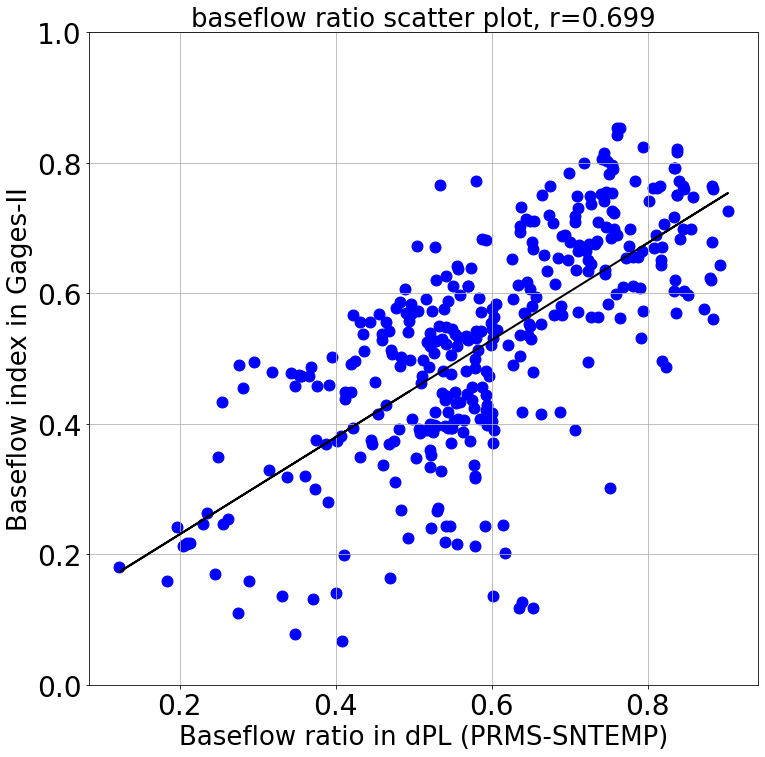

In [90]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

item1 = np.nansum((gwflow [:,:]), axis=1)/np.nansum(flowSim, axis=1)    # + ssflow[:,:]
item2 = attr365["BFI_AVE"]/100
# item2 = attr365["BFI_AVE"]/100
slope, intercept, r, p, se = scipy.stats.linregress(item1 , item2)
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.scatter(item1, item2, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,1)
plt.ylim(0.0, 1)
plt.grid()
plt.xlabel("Baseflow ratio in dPL (PRMS-SNTEMP)", fontsize=26)
plt.ylabel("Baseflow index in Gages-II", fontsize=26)
plt.title("baseflow ratio scatter plot" + ", r=" + str("{:.3f}".format(r)), fontsize=26)

# comparing the results of PRMS_only and PRMS_SNTEMP to see why PRMS_only has higher BFI correlation

In [293]:
# PRMS only on 365 sites # NSE > 0.674
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models"
p1 = r"marrmot_PRMS_only\PRMS_only_415_208\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
# attr671 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003", "attr_camels_tmean_ccov.feather"))
flow_obs = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot_PRMS = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim_PRMS = flowSim_tot_PRMS[:,:, 0]
srflow_PRMS = flowSim_tot_PRMS[:,:, 0] - flowSim_tot_PRMS[:,:, 3] - flowSim_tot_PRMS[:,:, 4]
ssflow_PRMS = flowSim_tot_PRMS[:,:, 4]
gwflow_PRMS = flowSim_tot_PRMS[:,:, 3]



# PRMS_SNTEMP
# p2 = r"PRMS_SNTEMP\new4\PRMS_SNTEMP_w9_w1_ST\SNTEMP_gw_365_ss_30_adj_T_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
# p2 = r"PRMS_SNTEMP\new3\PRMS_SNTEMP_415_208_w4_w1\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
# p2 = r"PRMS_SNTEMP\nmul16\PRMS_SNTEMP_w9_w1_400_ss15\SNTEMP_gw_365_ss_15_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
# p2 = r"PRMS_SNTEMP\nmul16\inv_gw_tau\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
# p2 = r"PRMS_SNTEMP\nmul16\inv_gw_tau_S\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
p2 = r"PRMS_SNTEMP\nmul16\inv_gw_tau_ST\SNTEMP_gw_365_ss_30_adj_T_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
temp_obs = np.load(os.path.join(p_main, p2,  "temp_obs.npy"))[:,:,0]
tempSim = np.load(os.path.join(p_main, p2, "temp_pred.npy"))[:,:,0]

flow_obs = np.load(os.path.join(p_main, p2,  "flow_obs.npy"))[:,:,0]
flowSim_tot = np.load(os.path.join(p_main, p2, "flowSim_tot.npy"))

flowSim = flowSim_tot[:,:, 0]
srflow = flowSim_tot[:,:, 0] - flowSim_tot[:,:, 3] - flowSim_tot[:,:, 4]
ssflow = flowSim_tot[:,:, 4]
gwflow = flowSim_tot[:,:, 3]


t1 = 3288
t2 = 3653

weight_gw = np.flip(np.load(os.path.join(p_main, p2, "weight_gw.npy")), axis=1)[:,t1:t2,:]
weight_ss = np.flip(np.load(os.path.join(p_main, p2,  "weight_ss.npy")), axis=1)[:,-30:,:]
SN_outs = np.load(os.path.join(p_main, p2,  "SN_outs.npy"))[:,t1:t2,:]
PET = SN_outs[:,:, 0]
rip = SN_outs[:,:, 1]
topo = SN_outs[:,:, 2]
top_width = SN_outs[:,:, 3]
coef_nom = SN_outs[:,:, 4]
coef_pow = SN_outs[:,:, 5]
hamon_coef = SN_outs[:,:, 6]
lat_temp_adj = SN_outs[:,:, 7]
a_ssflow = SN_outs[:,:, 8]
b_ssflow = SN_outs[:,:, 9]
a_gwflow = SN_outs[:,:, 10]
b_gwflow = SN_outs[:,:, 11]

# Q = x[:,365+t1:365+t2,6]
# Q = np.load(os.path.join(p_main, p2, "x.npy"))[:,365+t1: 365 +t2,6]

Text(0.5, 1.0, 'r=0.764,  slope=0.865')

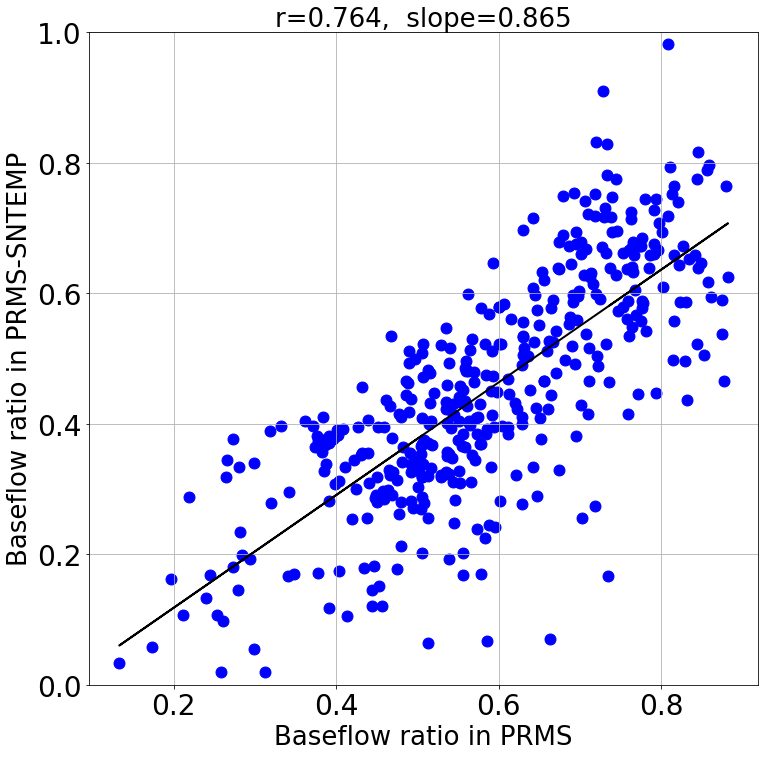

In [294]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

BFI_PRMS = np.nansum((gwflow_PRMS [:,:]), axis=1)/np.nansum(flowSim_PRMS, axis=1)    # + ssflow[:,:]
BFI_PRMS_SNTEMP = np.nansum((gwflow[:,:]), axis=1)/np.nansum(flowSim, axis=1)
# item2 = attr415["BFI_AVE"]/100
# item2 = attr365["BFI_AVE"]/100
slope, intercept, r, p, se = scipy.stats.linregress(BFI_PRMS , BFI_PRMS_SNTEMP)
plt.plot(BFI_PRMS, slope* BFI_PRMS+intercept, color="black", lw=2.0)
plt.scatter(BFI_PRMS, BFI_PRMS_SNTEMP, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,1)
plt.ylim(0.0, 1)
plt.grid()
plt.xlabel("Baseflow ratio in PRMS", fontsize=26)
plt.ylabel("Baseflow ratio in PRMS-SNTEMP", fontsize=26)
plt.title("r=" + str("{:.3f}".format(r)) + ",  slope=" + str("{:.3f}".format(slope)), fontsize=26)

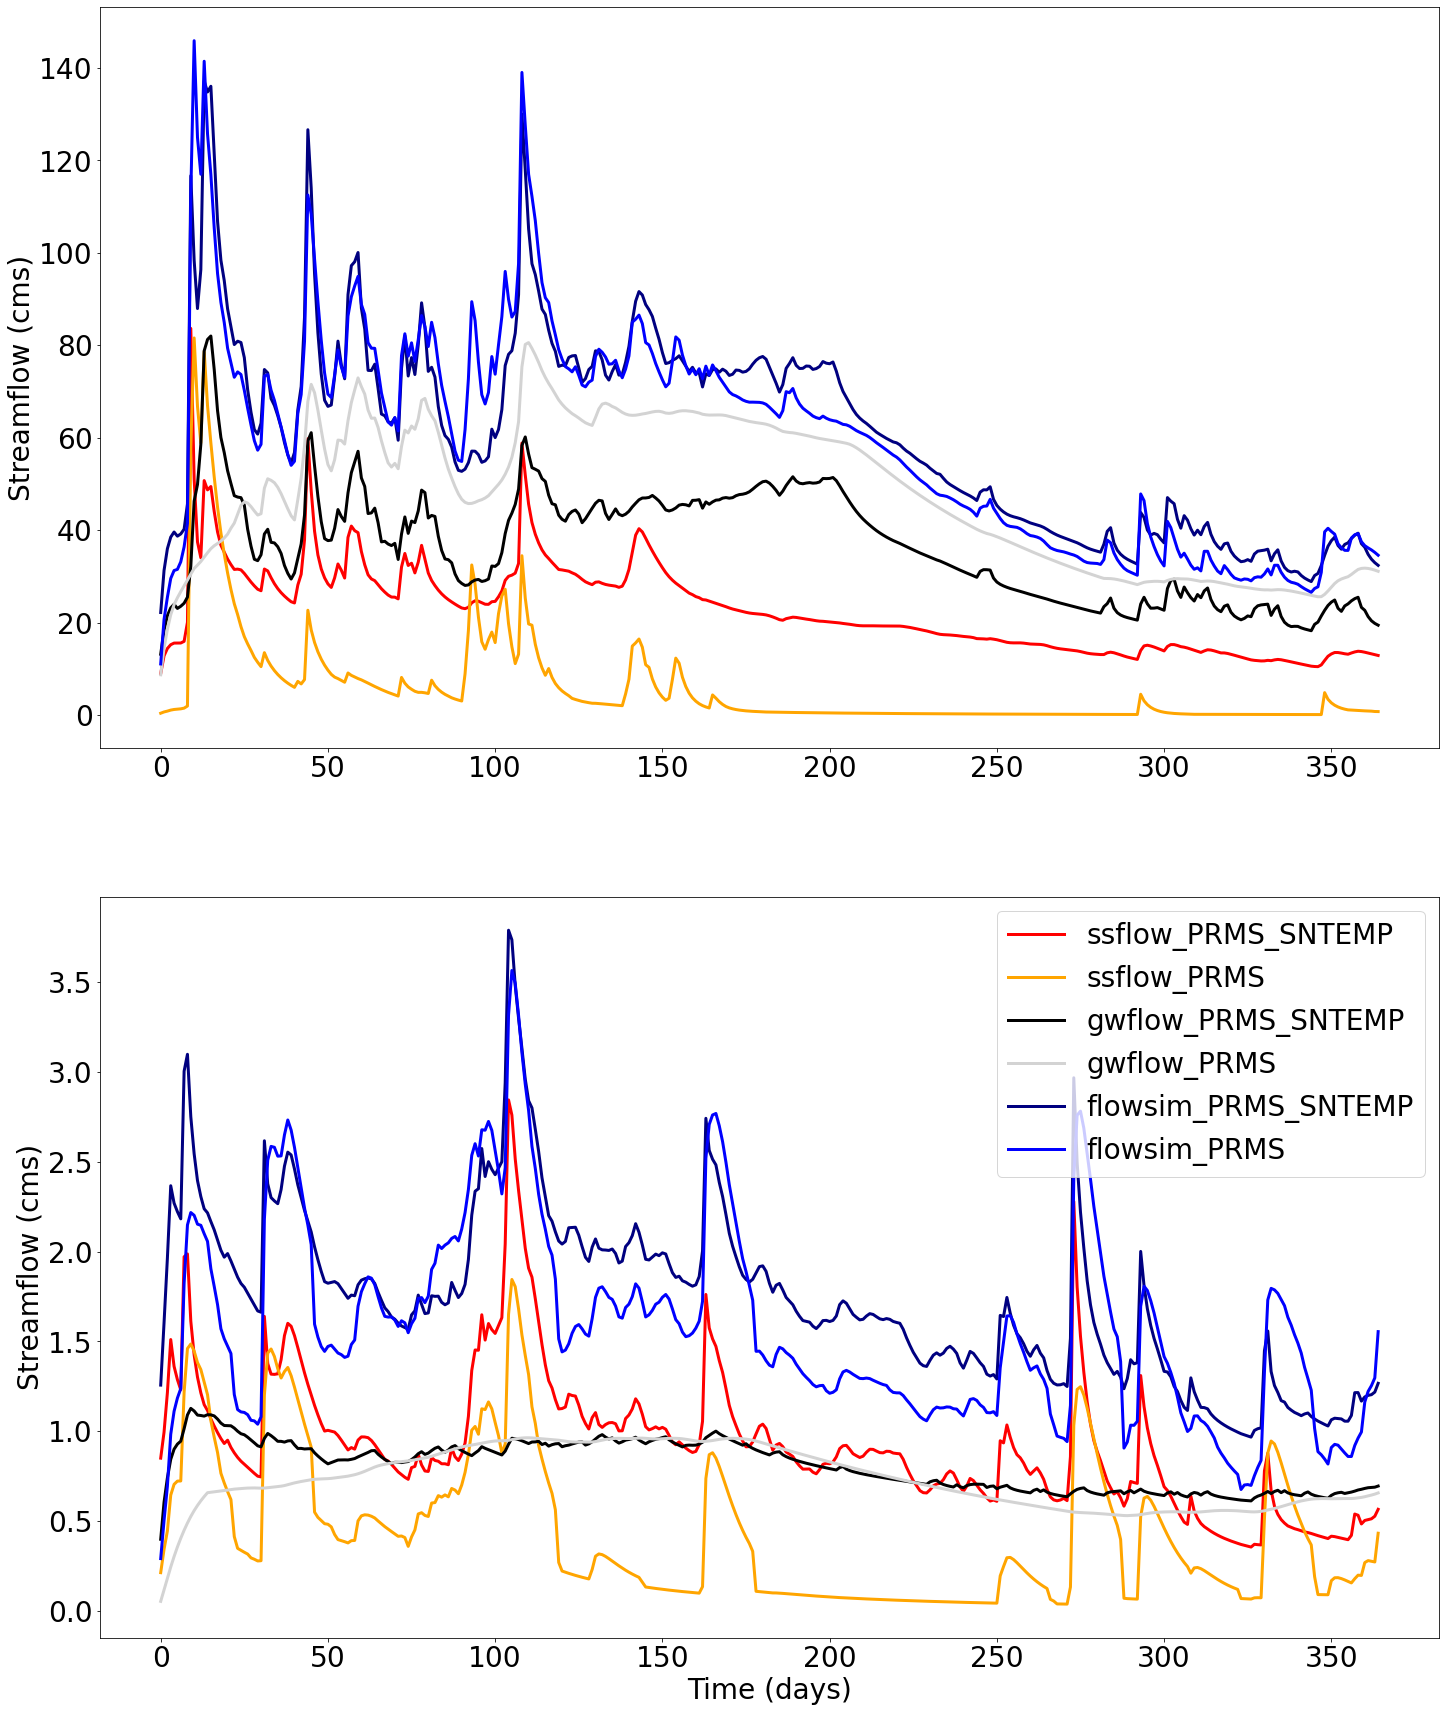

In [295]:
# ss = sites415[20:23]#common_sites[50:53]
ss = [408, 281, 325]
# ss = [100,  400]
ss = [408, 325]
# ss = [0, 50, 150]
area = attr415["DRAIN_SQKM"].to_numpy()  * (1000 / 86400)  # it is a converting unit for mm/day to m3/sec)
fig1, axs = plt.subplots(len(ss), 1, figsize=(24,30))
axs=axs.flatten()
plt.subplots_adjust(wspace=None,    # 0.4
                    hspace=None)
for i, ind in enumerate(ss):
#     ind = attr415[attr415["site_no"]==ss[i]].index[0]
    axs[i].plot(range(365), area [ind] * ssflow[ind,:365]  , label='ssflow_PRMS_SNTEMP', color = "red", lw=3)
    axs[i].plot(range(365), area [ind] * ssflow_PRMS[ind,:365]  , label='ssflow_PRMS', color = "orange", lw=3)
    axs[i].plot(range(365), area [ind] * gwflow[ind,:365] , label='gwflow_PRMS_SNTEMP', color = "black", lw=3)
    axs[i].plot(range(365), area [ind] * gwflow_PRMS[ind,:365], label='gwflow_PRMS', color = "lightgray", lw=3)
    axs[i].plot(range(365),  area [ind] * flowSim[ind,:365] , label='flowsim_PRMS_SNTEMP', color = "navy", lw=3)
    axs[i].plot(range(365),  area [ind] * flowSim_PRMS[ind,:365] , label='flowsim_PRMS', color = "blue", lw=3)
#     axs[i].plot(range(365),  area [ind] * flow_obs[ind,:365] , label='flowObs', color = "green", lw=4)
#     axs[i].scatter(range(365),  area [ind] * flow_obs[ind,:365] , label='flowObs', color = "green", lw=4)
#     axs[i].set_yscale('log')
#     axs[i].plot(range(365), gw_p[ind,365:730]  , label='gw_p', color = "red", lw=2)
#     axs[i].plot(range(365), ss_p[ind,365:730] , label='ss_p', color = "black", lw=2)
#     axs[i].plot(range(365), sr_p[ind,365:730] , label='sr_p', color = "blue", lw=2)
    axs[i].set_ylabel('Streamflow (cms)', fontsize=28)
plt.xlabel('Time (days)', fontsize=28)


# plt.ylabel('streamflow (cms)', fontsize=28)

plt.legend()
# met.legend()
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)    # legend fontsize

0


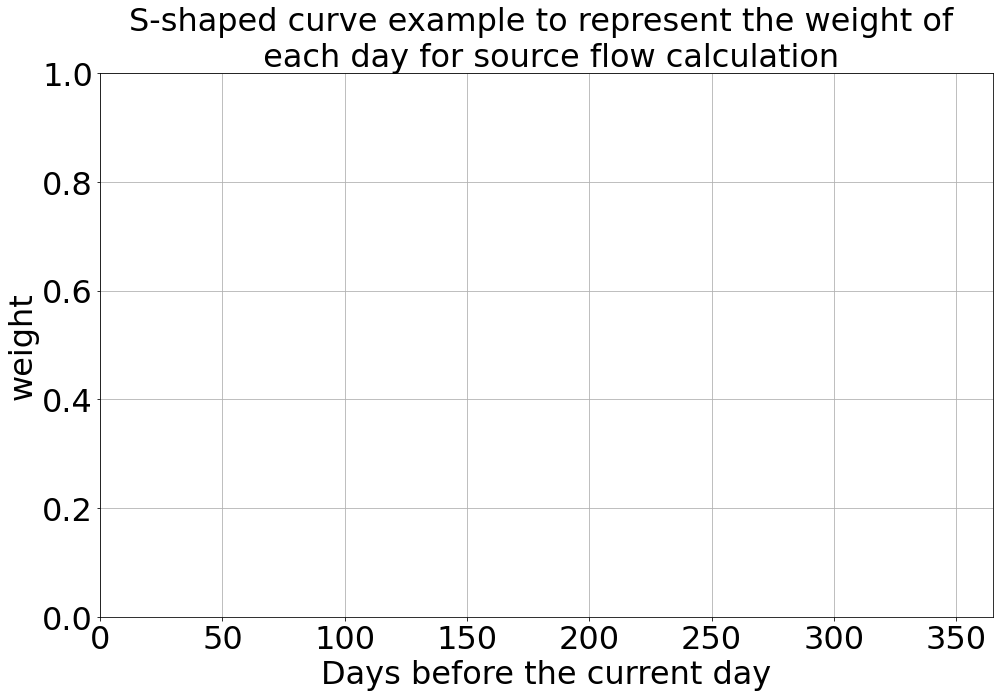

In [385]:
plt.figure(figsize=(16, 10))
copper = plt.get_cmap("copper")
count =0
for i in range(weight_gw.shape[0]):
    if weight_gw[i,0,0] < 0.22:
    #     plt.plot(range(365), weight_gw[400,100,:,0], color = "darkblue", lw=3.5)
        plt.plot(range(365), weight_gw[i,:365,0], color = copper(i), lw=1.5)
#         plt.plot(range(730), weight_gw[i,:,0], color = copper(i), lw=1.5)
        count = count+1
# plt.plot(range(365), weight_gw[400,0,:,0])
plt.xlim(0,365)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid()
plt.ylabel("weight", fontsize=32)
plt.xlabel("Days before the current day", fontsize=32)
plt.title("S-shaped curve example to represent the weight of \n each day for source flow calculation", fontsize=32)
# plt.ylim(0, 0.008)
print(count)

59


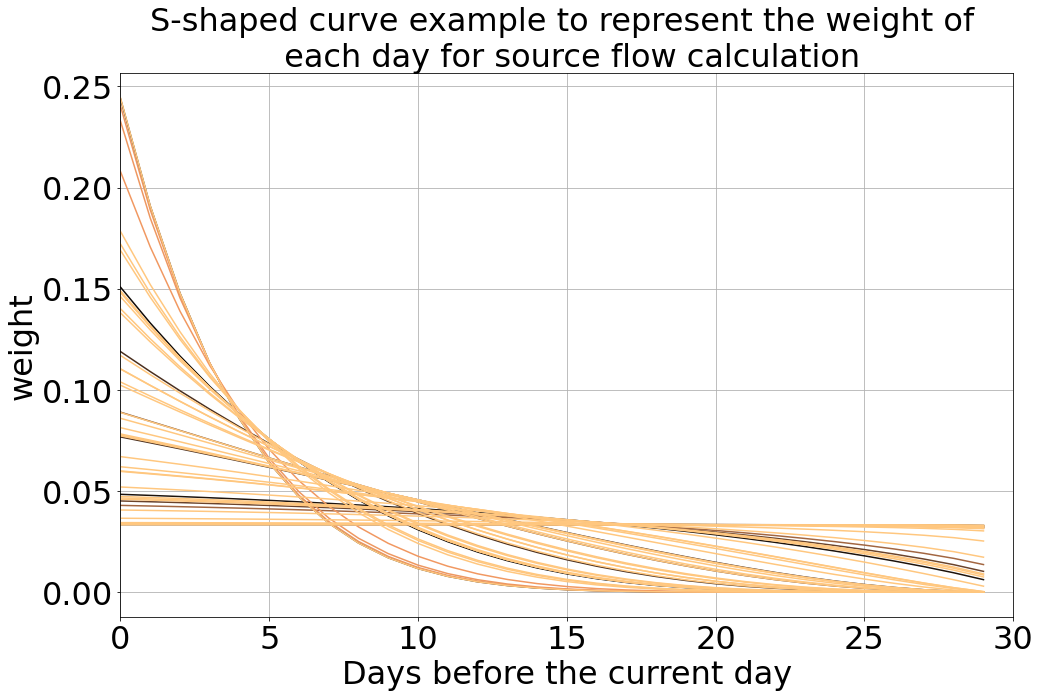

In [298]:
plt.figure(figsize=(16, 10))
copper = plt.get_cmap("copper")
count =0
for i in range(weight_ss.shape[0]):
    if weight_ss[i,0,0] < 0.25:
    #     plt.plot(range(365), weight_gw[400,100,:,0], color = "darkblue", lw=3.5)
        plt.plot(range(30), weight_ss[i,:30,0], color = copper(i), lw=1.5)
#         plt.plot(range(730), weight_gw[i,:,0], color = copper(i), lw=1.5)
        count = count+1
# plt.plot(range(365), weight_gw[400,0,:,0])
plt.xlim(0,30)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid()
plt.ylabel("weight", fontsize=32)
plt.xlabel("Days before the current day", fontsize=32)
plt.title("S-shaped curve example to represent the weight of \n each day for source flow calculation", fontsize=32)
# plt.ylim(0, 0.008)
print(count)

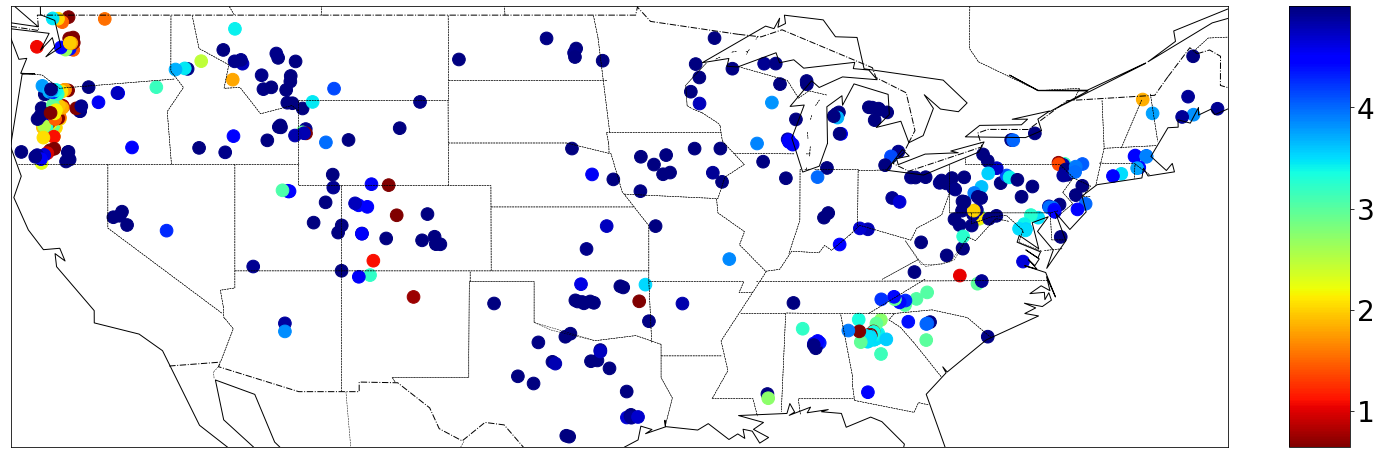

In [304]:
fig, axs = plt.subplots(1, 1, figsize=(24,30))

# axs=axs.flatten()
plt.subplots_adjust( #left=0.1,
#                     bottom=0, 
#                     right=0.9, 
#                     top=0.9, 
                    wspace=0,    # 0.4
                    hspace=0.00)   # 0.4

### for Baseflow index GAGES-II
plotMap(lat_temp_adj[:,0], 
        lat=attr415['lat'],
        lon=attr415['lon'], 
        figsize=(15, 11),
        cmap=plt.cm.jet_r, 
        clim=False,
#         cRange=[0.08,1],
#        title='GW + SS for ' + p_list1[i] + "$\ _{noBias}$",
        s=160, 
        ax=axs)


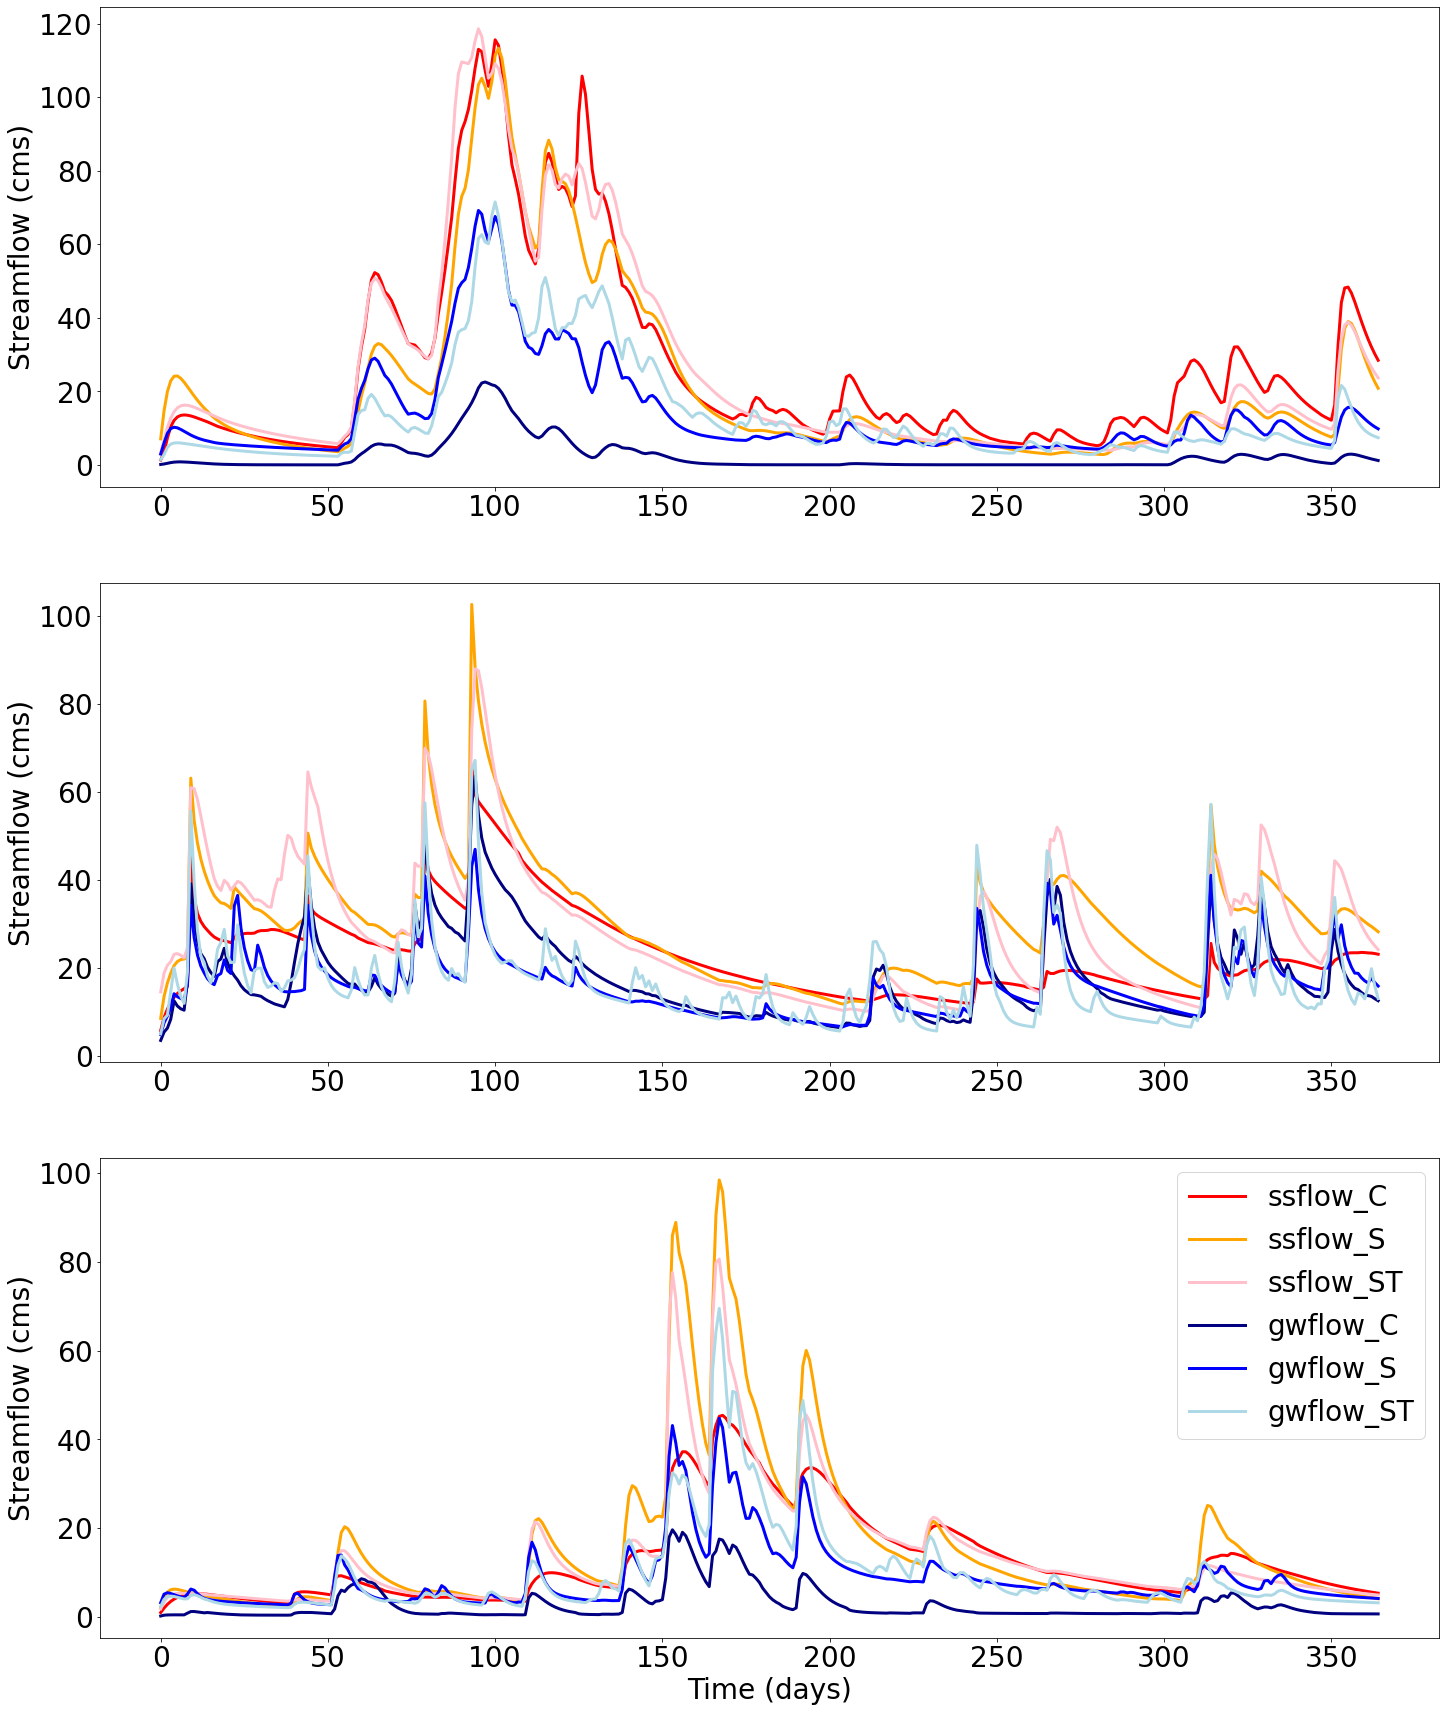

In [414]:
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models"
p1 = r"PRMS_SNTEMP\nmul16\inv_gw_tau\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs_C = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot_C = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim_C = flowSim_tot_C[:,:, 0]
srflow_C = flowSim_tot_C[:,:, 0] - flowSim_tot_C[:,:, 3] - flowSim_tot_C[:,:, 4]
ssflow_C = flowSim_tot_C[:,:, 4]
gwflow_C = flowSim_tot_C[:,:, 3]

p1 = r"PRMS_SNTEMP\nmul16\inv_gw_tau_S\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs_S = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot_S = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim_S = flowSim_tot_S[:,:, 0]
srflow_S = flowSim_tot_S[:,:, 0] - flowSim_tot_S[:,:, 3] - flowSim_tot_S[:,:, 4]
ssflow_S = flowSim_tot_S[:,:, 4]
gwflow_S = flowSim_tot_S[:,:, 3]

p1 = r"PRMS_SNTEMP\nmul16\inv_gw_tau_ST\SNTEMP_gw_365_ss_30_adj_T_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs_ST = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot_ST = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim_ST = flowSim_tot_ST[:,:, 0]
srflow_ST = flowSim_tot_ST[:,:, 0] - flowSim_tot_ST[:,:, 3] - flowSim_tot_ST[:,:, 4]
ssflow_ST = flowSim_tot_ST[:,:, 4]
gwflow_ST = flowSim_tot_ST[:,:, 3]


# ss = [408, 325]
ss = [0, 100, 200]
area = attr415["DRAIN_SQKM"].to_numpy()  * (1000 / 86400)  # it is a converting unit for mm/day to m3/sec)
fig1, axs = plt.subplots(len(ss), 1, figsize=(24,30))
axs=axs.flatten()
plt.subplots_adjust(wspace=None,    # 0.4
                    hspace=None)
for i, ind in enumerate(ss):
#     ind = attr415[attr415["site_no"]==ss[i]].index[0]
    axs[i].plot(range(365), area [ind] * ssflow_C[ind,:365]  , label='ssflow_C', color = "red", lw=3)
    axs[i].plot(range(365), area [ind] * ssflow_S[ind,:365]  , label='ssflow_S', color = "orange", lw=3)
    axs[i].plot(range(365), area [ind] * ssflow_ST[ind,:365]  , label='ssflow_ST', color = "pink", lw=3)
    axs[i].plot(range(365), area [ind] * gwflow_C[ind,:365] , label='gwflow_C', color = "navy", lw=3)
    axs[i].plot(range(365), area [ind] * gwflow_S[ind,:365], label='gwflow_S', color = "blue", lw=3)
    axs[i].plot(range(365), area [ind] * gwflow_ST[ind,:365], label='gwflow_ST', color = "lightblue", lw=3)
#     axs[i].plot(range(365),  area [ind] * flowSim_C[ind,:365] , label='flowsim_C', color = "black", lw=3)
#     axs[i].plot(range(365),  area [ind] * flowSim_S[ind,:365] , label='flowsim_S', color = "grey", lw=3)
#     axs[i].plot(range(365),  area [ind] * flowSim_ST[ind,:365] , label='flowsim_ST', color = "lightgrey", lw=3)
#     axs[i].scatter(range(365),  area [ind] * flow_obs[ind,:365] , label='flowObs', color = "green", lw=4)
#     axs[i].set_yscale('log')
#     axs[i].plot(range(365), gw_p[ind,365:730]  , label='gw_p', color = "red", lw=2)
#     axs[i].plot(range(365), ss_p[ind,365:730] , label='ss_p', color = "black", lw=2)
#     axs[i].plot(range(365), sr_p[ind,365:730] , label='sr_p', color = "blue", lw=2)
    axs[i].set_ylabel('Streamflow (cms)', fontsize=28)
plt.xlabel('Time (days)', fontsize=28)


# plt.ylabel('streamflow (cms)', fontsize=28)

plt.legend()
# met.legend()
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)    # legend fontsize

# comparing res time differences between inv_gw_tau and w9_w1

In [496]:
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models"
t1 = 365
t2 = 730
tss1 = 30
tss2 = 60
p1 = r"PRMS_SNTEMP\nmul16\inv_gw_tau\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs_C = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot_C = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim_C = flowSim_tot_C[:,:, 0]
srflow_C = flowSim_tot_C[:,:, 0] - flowSim_tot_C[:,:, 3] - flowSim_tot_C[:,:, 4]
ssflow_C = flowSim_tot_C[:,:, 4]
gwflow_C = flowSim_tot_C[:,:, 3]
weight_gw_C = np.flip(np.load(os.path.join(p_main, p1, "weight_gw.npy"))[:,t1:t2,:], axis=1)
weight_ss_C = np.flip(np.load(os.path.join(p_main, p1,  "weight_ss.npy"))[:,tss1:tss2,:], axis=1)
SN_outs_C = np.load(os.path.join(p_main, p1,  "SN_outs.npy"))[:,t1:t2,:]
PET_C = SN_outs_C[:,:, 0]
rip_C = SN_outs_C[:,:, 1]
topo_C = SN_outs_C[:,:, 2]
top_width_C = SN_outs_C[:,:, 3]
coef_nom_C = SN_outs_C[:,:, 4]
coef_pow_C = SN_outs_C[:,:, 5]
hamon_coef_C = SN_outs_C[:,:, 6]
lat_temp_adj_C = SN_outs_C[:,:, 7]
a_ssflow_C = SN_outs_C[:,:, 8]
b_ssflow_C = SN_outs_C[:,:, 9]
a_gwflow_C = SN_outs_C[:,:, 10]
b_gwflow_C = SN_outs_C[:,:, 11]




p2 = r"PRMS_SNTEMP\nmul16\inv_gw_tau_S\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs_S = np.load(os.path.join(p_main, p2, "flow_obs.npy"))[:,:,0]
flowSim_tot_S = np.load(os.path.join(p_main, p2, "flowSim_tot.npy"))

flowSim_S = flowSim_tot_S[:,:, 0]
srflow_S = flowSim_tot_S[:,:, 0] - flowSim_tot_S[:,:, 3] - flowSim_tot_S[:,:, 4]
ssflow_S = flowSim_tot_S[:,:, 4]
gwflow_S = flowSim_tot_S[:,:, 3]
weight_gw_S = np.flip(np.load(os.path.join(p_main, p2, "weight_gw.npy"))[:,t1:t2,:], axis=1)
weight_ss_S = np.flip(np.load(os.path.join(p_main, p2,  "weight_ss.npy"))[:,tss1:tss2,:], axis=1)
SN_outs_S = np.load(os.path.join(p_main, p2,  "SN_outs.npy"))[:,t1:t2,:]
PET_S = SN_outs_S[:,:, 0]
rip_S = SN_outs_S[:,:, 1]
topo_S = SN_outs_S[:,:, 2]
top_width_S = SN_outs_S[:,:, 3]
coef_nom_S = SN_outs_S[:,:, 4]
coef_pow_S = SN_outs_S[:,:, 5]
hamon_coef_S = SN_outs_S[:,:, 6]
lat_temp_adj_S = SN_outs_S[:,:, 7]
a_ssflow_S = SN_outs_S[:,:, 8]
b_ssflow_S = SN_outs_S[:,:, 9]
a_gwflow_S = SN_outs_S[:,:, 10]
b_gwflow_S = SN_outs_S[:,:, 11]




p3 = r"PRMS_SNTEMP\nmul16\inv_gw_tau_ST\SNTEMP_gw_365_ss_30_adj_T_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs_ST = np.load(os.path.join(p_main, p3, "flow_obs.npy"))[:,:,0]
flowSim_tot_ST = np.load(os.path.join(p_main, p3, "flowSim_tot.npy"))

flowSim_ST = flowSim_tot_ST[:,:, 0]
srflow_ST = flowSim_tot_ST[:,:, 0] - flowSim_tot_ST[:,:, 3] - flowSim_tot_ST[:,:, 4]
ssflow_ST = flowSim_tot_ST[:,:, 4]
gwflow_ST = flowSim_tot_ST[:,:, 3]
weight_gw_ST = np.flip(np.load(os.path.join(p_main, p3, "weight_gw.npy"))[:,t1:t2,:], axis=1)
weight_ss_ST = np.flip(np.load(os.path.join(p_main, p3,  "weight_ss.npy"))[:,tss1:tss2,:], axis=1)
SN_outs_ST = np.load(os.path.join(p_main, p3,  "SN_outs.npy"))[:,t1:t2,:]
PET_ST = SN_outs_ST[:,:, 0]
rip_ST = SN_outs_ST[:,:, 1]
topo_ST = SN_outs_ST[:,:, 2]
top_width_ST = SN_outs_ST[:,:, 3]
coef_nom_ST = SN_outs_ST[:,:, 4]
coef_pow_ST = SN_outs_ST[:,:, 5]
hamon_coef_ST = SN_outs_ST[:,:, 6]
lat_temp_adj_ST = SN_outs_ST[:,:, 7]
a_ssflow_ST = SN_outs_ST[:,:, 8]
b_ssflow_ST = SN_outs_ST[:,:, 9]
a_gwflow_ST = SN_outs_ST[:,:, 10]
b_gwflow_ST = SN_outs_ST[:,:, 11]






p4 = r"PRMS_SNTEMP\nmul16\PRMS_SNTEMP_w9_w1_Cwidth_400_S\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
# p4 = r"PRMS_SNTEMP\nmul16\PRMS_SNTEMP_w9_w1_Cwidth_400_ST\SNTEMP_gw_365_ss_30_adj_T_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs = np.load(os.path.join(p_main, p4, "flow_obs.npy"))[:,:,0]
flowSim_tot = np.load(os.path.join(p_main, p4, "flowSim_tot.npy"))

flowSim = flowSim_tot[:,:, 0]
srflow = flowSim_tot[:,:, 0] - flowSim_tot[:,:, 3] - flowSim_tot[:,:, 4]
ssflow = flowSim_tot[:,:, 4]
gwflow = flowSim_tot[:,:, 3]
weight_gw = np.flip(np.load(os.path.join(p_main, p4, "weight_gw.npy"))[:,t1:t2,:], axis=1)
weight_ss = np.flip(np.load(os.path.join(p_main, p4,  "weight_ss.npy"))[:,tss1:tss2,:], axis=1)
SN_outs = np.load(os.path.join(p_main, p4,  "SN_outs.npy"))[:,t1:t2,:]
PET = SN_outs[:,:, 0]
rip = SN_outs[:,:, 1]
topo = SN_outs[:,:, 2]
top_width = SN_outs[:,:, 3]
coef_nom = SN_outs[:,:, 4]
coef_pow = SN_outs[:,:, 5]
hamon_coef = SN_outs[:,:, 6]
lat_temp_adj = SN_outs[:,:, 7]
a_ssflow = SN_outs[:,:, 8]
b_ssflow = SN_outs[:,:, 9]
a_gwflow = SN_outs[:,:, 10]
b_gwflow = SN_outs[:,:, 11]

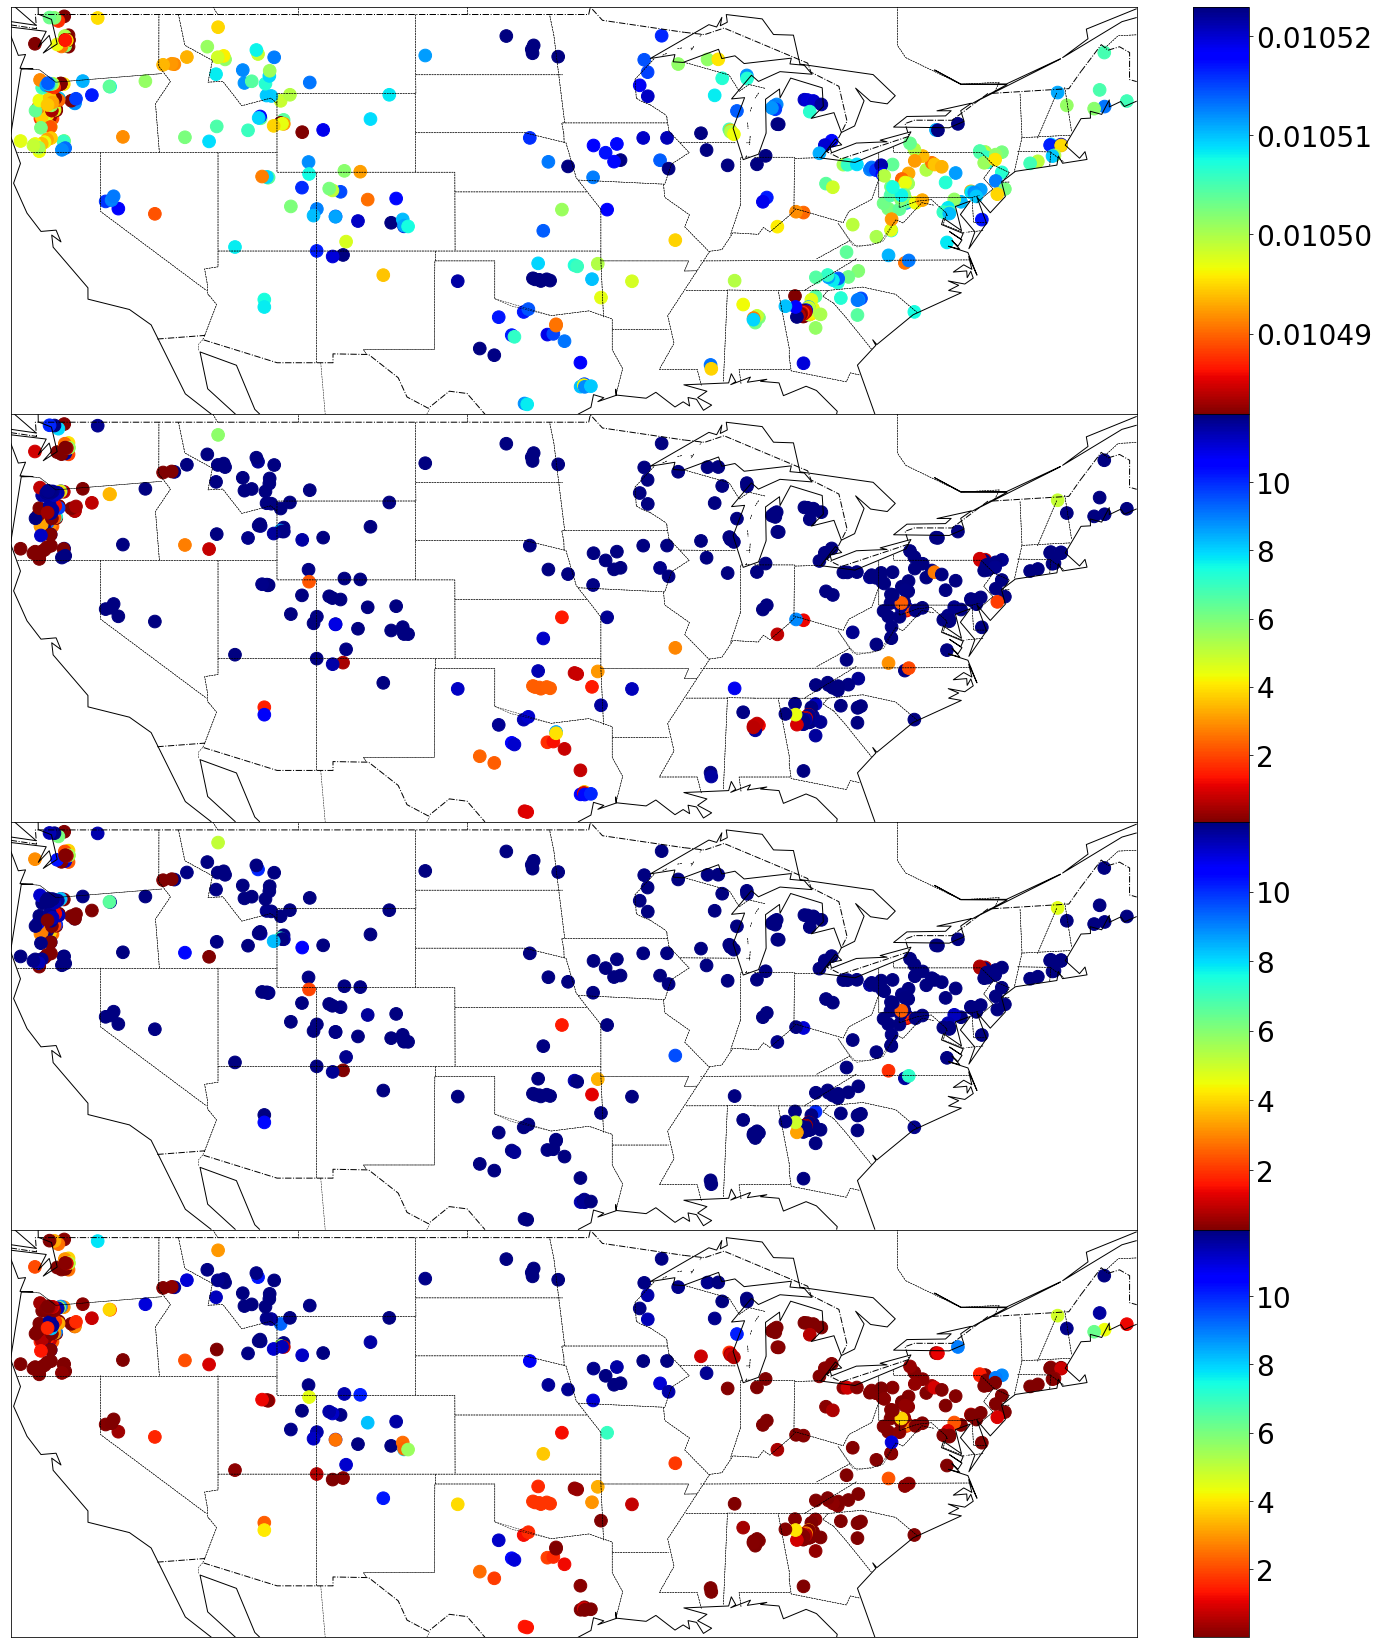

In [497]:
item_list = [a_gwflow_C, a_gwflow_S, a_gwflow_ST, a_gwflow]

fig, axs = plt.subplots(4, 1, figsize=(24,30))

axs=axs.flatten()
plt.subplots_adjust( #left=0.1,
#                     bottom=0, 
#                     right=0.9, 
#                     top=0.9, 
                    wspace=0,    # 0.4
                    hspace=0.00)   # 0.4

for j,i in enumerate(item_list): 
    plotMap(i[:,0], 
            lat=attr415['lat'],
            lon=attr415['lon'], 
            figsize=(15, 11),
            cmap=plt.cm.jet_r, 
            clim=False,
#             cRange=[6,10],
    #        title='GW + SS for ' + p_list1[i] + "$\ _{noBias}$",
            s=160, 
            ax=axs[j])

Text(0.5, 1.0, 'r=0.133,  slope=6.733')

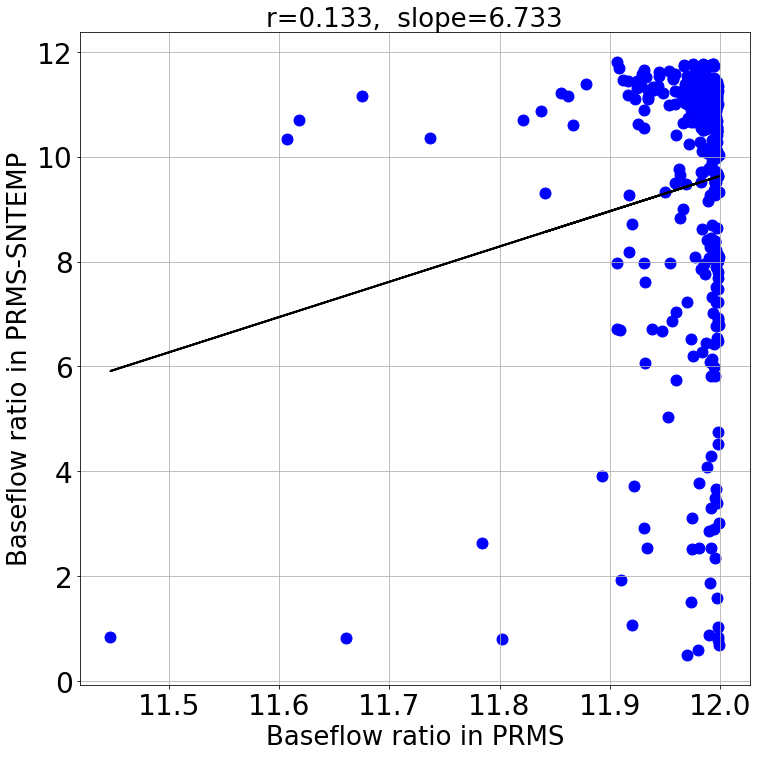

In [485]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

BFI_PRMS = b_gwflow_ST[ind365,0] #np.nansum((gwflow_PRMS [:,:]), axis=1)/np.nansum(flowSim_PRMS, axis=1)    # + ssflow[:,:]
BFI_PRMS_SNTEMP = b_gwflow[ind365,0] #np.nansum((gwflow[:,:]), axis=1)/np.nansum(flowSim, axis=1)
# item2 = attr415["BFI_AVE"]/100
# item2 = attr365["BFI_AVE"]/100
slope, intercept, r, p, se = scipy.stats.linregress(BFI_PRMS , BFI_PRMS_SNTEMP)
plt.plot(BFI_PRMS, slope* BFI_PRMS+intercept, color="black", lw=2.0)
plt.scatter(BFI_PRMS, BFI_PRMS_SNTEMP, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,1)
# plt.ylim(0.0, 1)
plt.grid()
plt.xlabel("Baseflow ratio in PRMS", fontsize=26)
plt.ylabel("Baseflow ratio in PRMS-SNTEMP", fontsize=26)
plt.title("r=" + str("{:.3f}".format(r)) + ",  slope=" + str("{:.3f}".format(slope)), fontsize=26)

In [498]:
weight = weight_gw_C[:,:365]
res_time_gw_C = np.zeros(weight.shape[0])
for i in range(weight.shape[0]):
    flag = 0
    j = 0
    while flag == 0:
        if weight[i,j] < 0.001:
            res_time_gw_C[i] = j
            flag = 1
        j = j + 1
        if j >= weight.shape[1]:
            flag = 1
res_time_gw_C[res_time_gw_C==0] = 365

weight = weight_gw_S[:,:365]
res_time_gw_S = np.zeros(weight.shape[0])
for i in range(weight.shape[0]):
    flag = 0
    j = 0
    while flag == 0:
        if weight[i,j] < 0.001:
            res_time_gw_S[i] = j
            flag = 1
        j = j + 1
        if j >= weight.shape[1]:
            flag = 1
res_time_gw_S[res_time_gw_S==0] = 365

weight = weight_gw_ST[:,:365]
res_time_gw_ST = np.zeros(weight.shape[0])
for i in range(weight.shape[0]):
    flag = 0
    j = 0
    while flag == 0:
        if weight[i,j] < 0.001:
            res_time_gw_ST[i] = j
            flag = 1
        j = j + 1
        if j >= weight.shape[1]:
            flag = 1
res_time_gw_ST[res_time_gw_ST==0] = 365

weight = weight_gw[:,:365]
res_time_gw = np.zeros(weight.shape[0])
for i in range(weight.shape[0]):
    flag = 0
    j = 0
    while flag == 0:
        if weight[i,j] < 0.001:
            res_time_gw[i] = j
            flag = 1
        j = j + 1
        if j >= weight.shape[1]:
            flag = 1
res_time_gw[res_time_gw==0] = 365

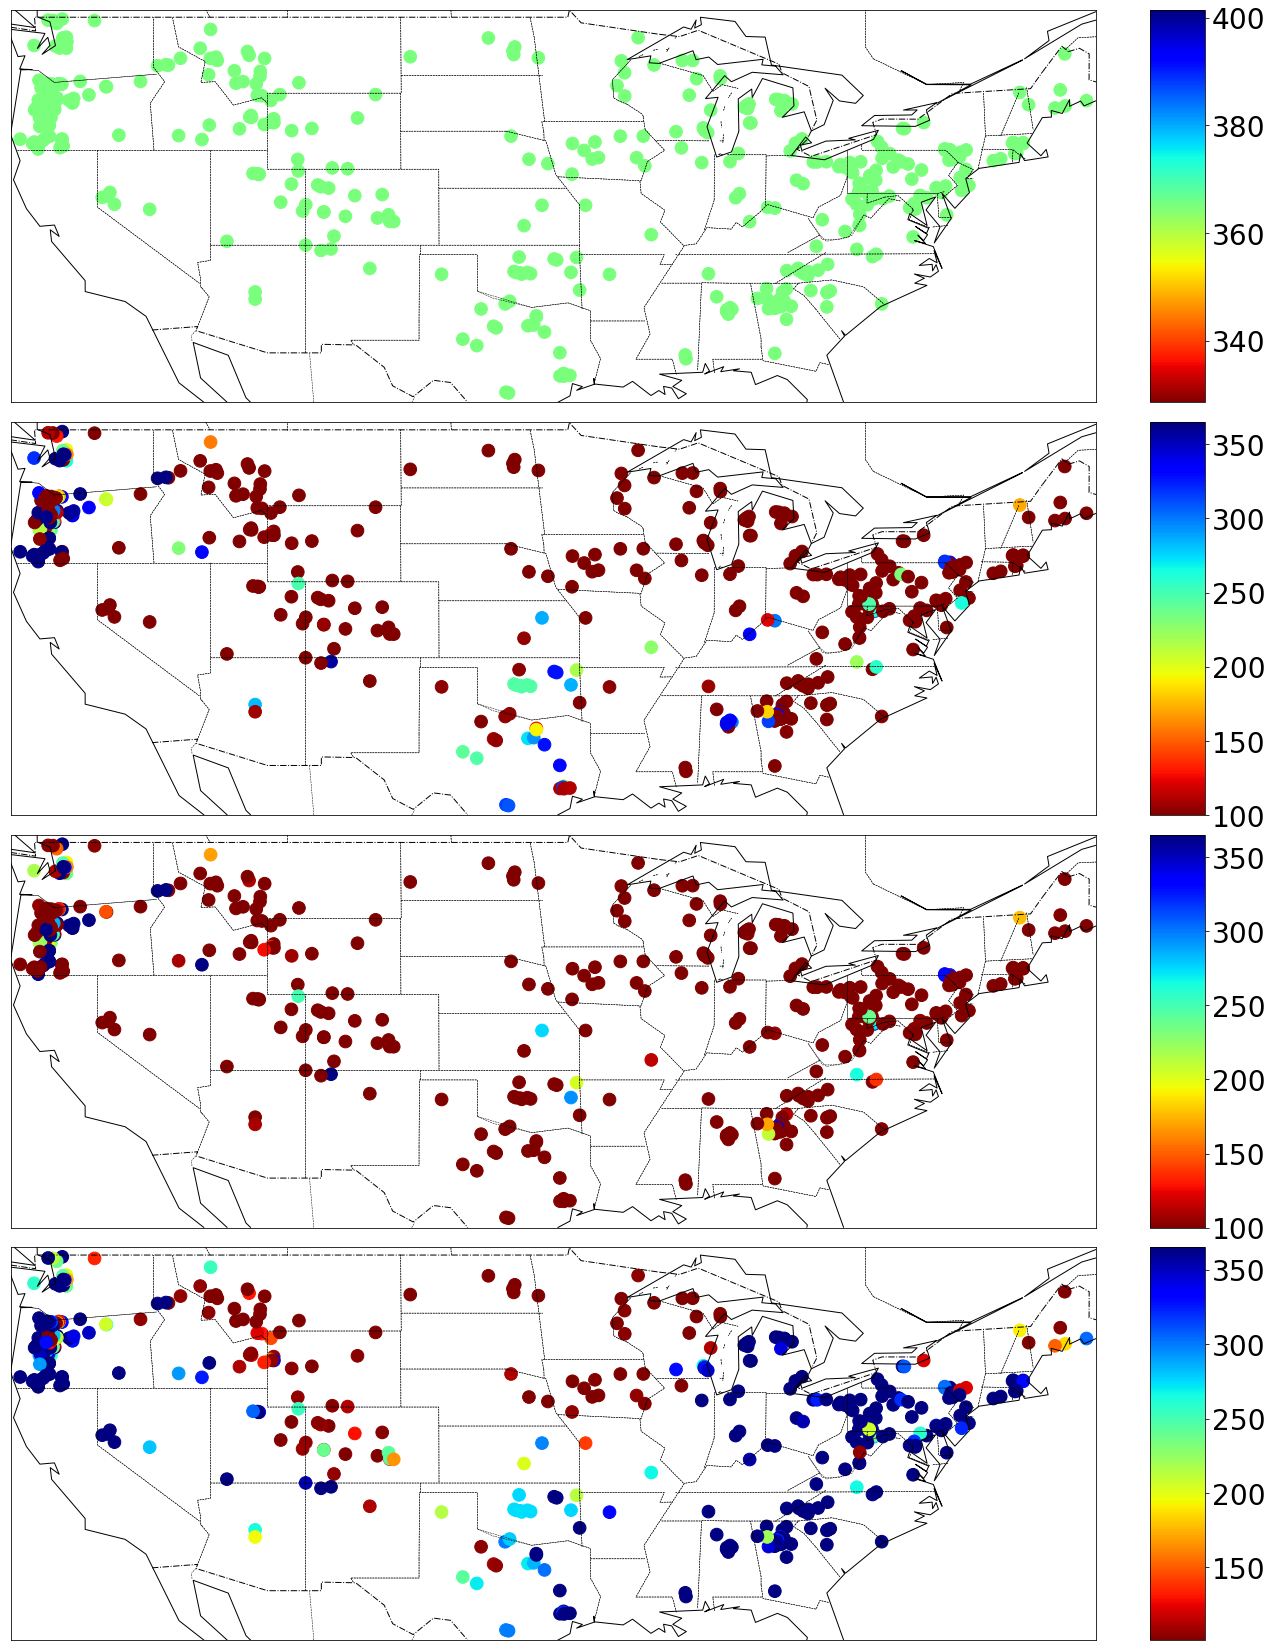

In [488]:
item_list = [res_time_gw_C, res_time_gw_S, res_time_gw_ST, res_time_gw]

fig, axs = plt.subplots(4, 1, figsize=(24,30))

axs=axs.flatten()
plt.subplots_adjust( #left=0.1,
#                     bottom=0, 
#                     right=0.9, 
#                     top=0.9, 
                    wspace=0,    # 0.4
                    hspace=0.05)   # 0.4

for j,i in enumerate(item_list): 
    plotMap(i, 
            lat=attr415['lat'],
            lon=attr415['lon'], 
            figsize=(15, 11),
            cmap=plt.cm.jet_r, 
            clim=False,
#             cRange=[6,10],
    #        title='GW + SS for ' + p_list1[i] + "$\ _{noBias}$",
            s=160, 
            ax=axs[j])

In [489]:
weight_gw.shape

(415, 365, 1)

415


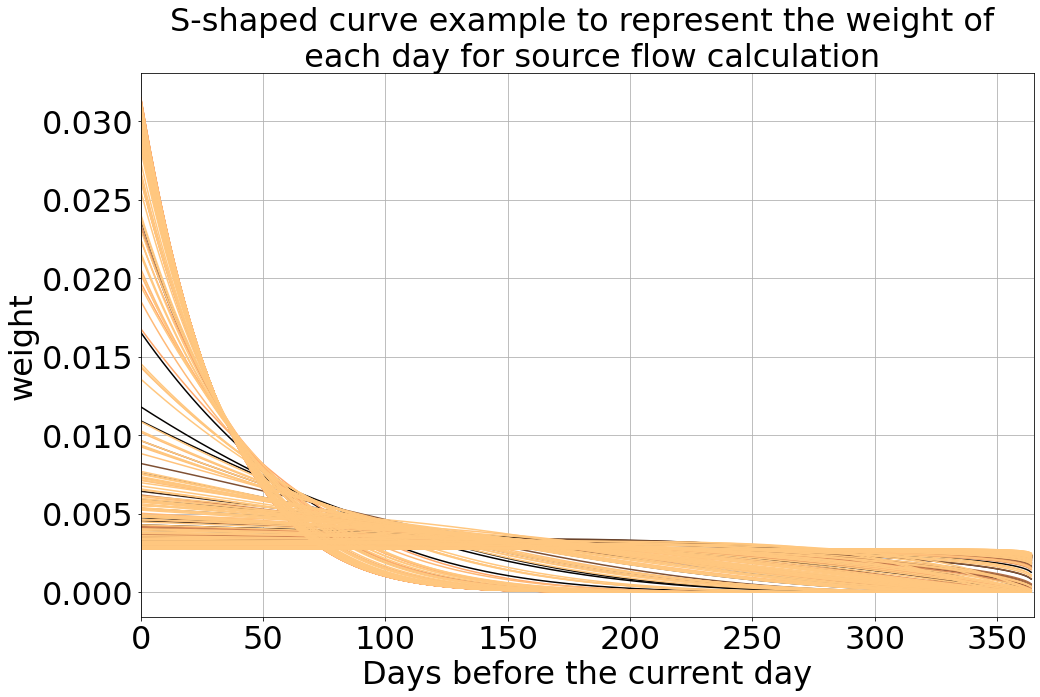

In [490]:
plt.figure(figsize=(16, 10))
copper = plt.get_cmap("copper")
count =0
for i in range(weight_gw.shape[0]):
    if weight_gw[i,0,0] < 0.6:
    #     plt.plot(range(365), weight_gw[400,100,:,0], color = "darkblue", lw=3.5)
        plt.plot(range(365), weight_gw[i,:365,0], color = copper(i), lw=1.5)
#         plt.plot(range(730), weight_gw[i,:,0], color = copper(i), lw=1.5)
        count = count+1
# plt.plot(range(365), weight_gw[400,0,:,0])
plt.xlim(0,365)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid()
plt.ylabel("weight", fontsize=32)
plt.xlabel("Days before the current day", fontsize=32)
plt.title("S-shaped curve example to represent the weight of \n each day for source flow calculation", fontsize=32)
# plt.ylim(0, 0.008)
print(count)

415


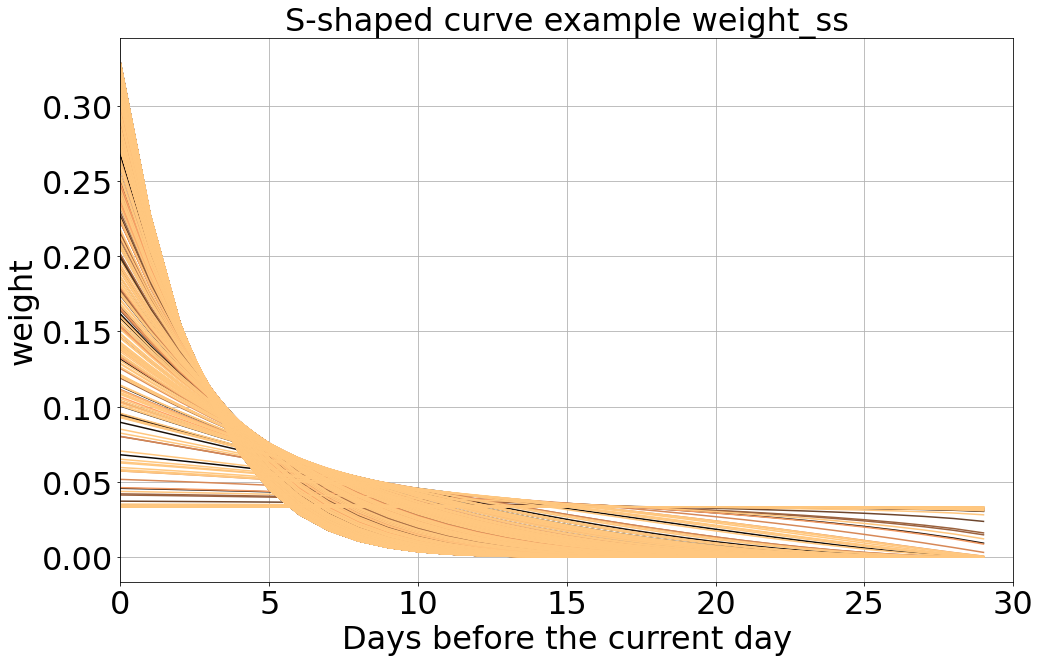

In [499]:
plt.figure(figsize=(16, 10))
copper = plt.get_cmap("copper")
count =0
for i in range(weight_ss.shape[0]):
    if weight_ss[i,0,0] < 1.92:
    #     plt.plot(range(365), weight_gw[400,100,:,0], color = "darkblue", lw=3.5)
        plt.plot(range(30), weight_ss[i,:30,0], color = copper(i), lw=1.5)
#         plt.plot(range(730), weight_gw[i,:,0], color = copper(i), lw=1.5)
        count = count+1
# plt.plot(range(365), weight_gw[400,0,:,0])
plt.xlim(0,30)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid()
plt.ylabel("weight", fontsize=32)
plt.xlabel("Days before the current day", fontsize=32)
plt.title("S-shaped curve example weight_ss", fontsize=32)
# plt.ylim(0, 0.008)
print(count)

In [500]:
weight_ss[0,:,0]

array([1.13462672e-01, 1.04726896e-01, 9.62560177e-02, 8.80685896e-02,
       8.01826715e-02, 7.26156607e-02, 6.53841347e-02, 5.85036390e-02,
       5.19885272e-02, 4.58517186e-02, 4.01044674e-02, 3.47561650e-02,
       2.98140477e-02, 2.52829846e-02, 2.11651903e-02, 1.74599849e-02,
       1.41635304e-02, 1.12685850e-02, 8.76427069e-03, 6.63587917e-03,
       4.86470200e-03, 3.42792668e-03, 2.29860726e-03, 1.44574535e-03,
       8.34515609e-04, 4.26694722e-04, 1.81376716e-04, 5.61062188e-05,
       8.66321625e-06, 5.63956163e-13], dtype=float32)

# comparing parameters of different settings

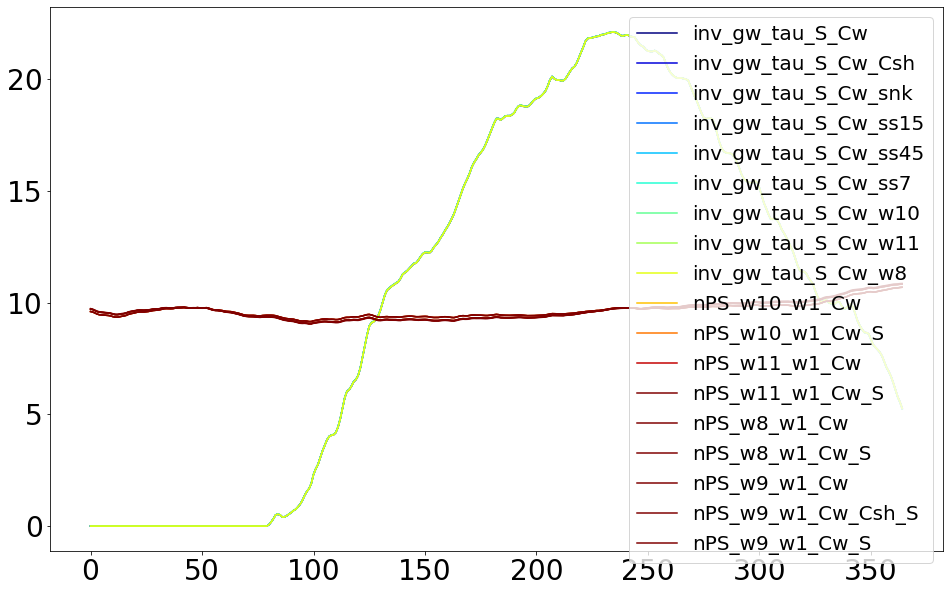

In [688]:
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models"
p1 = [
   r"PRMS_SNTEMP\nmul16_sep14",
#     r"PRMS_SNTEMP\nmul16",
#     r"PRMS_SNTEMP\new4",
   # r"snow_module\nmul1",
#     r"snow_module\nmul16",
   # r"tempLoss\nmul1"
]
items = ['flow', 'temp']
metrics = ["NSE", "KGE"]  #, "BFI corr", "NSE PUB", "KGE PUB", "BFI corr PUB"]
t1 = 365    # first day of testing
t2 = 730    # last day of testing
tss1 = 30
tss2 = 60

plt.figure(figsize=(16, 10))
copper = plt.get_cmap("jet")
basin = 17



all_paths = []
used_path = []
ind = []
for i in p1:
    run_list = glob.glob(os.path.join(p_main, i + "\*"))
    all_paths = all_paths + run_list

results = pd.DataFrame(index=ind)
for i, path in enumerate(all_paths):
    if (
        ("_ST" not in os.path.basename(path))# & ("w1_" in os.path.basename(path)) & 
  #  ("_S" in os.path.basename(path)[-4:]) & ("Cw" in os.path.basename(path))
       ):   
        used_path.append(path)
        pred_temp = np.load(os.path.join(glob.glob(path + "\*")[0], "temp_pred.npy"))[:,t1:t2,:]
        obs_temp = np.load(os.path.join(glob.glob(path + "\*")[0], "temp_obs.npy"))[:,t1:t2,:]
        weight_gw = np.flip(np.load(os.path.join(glob.glob(path + "\*")[0], "weight_gw.npy"))[:,t1:t2,:], axis=1)
        weight_ss = np.flip(np.load(os.path.join(glob.glob(path + "\*")[0],  "weight_ss.npy"))[:,tss1:tss2,:], axis=1)
        SN_outs = np.load(os.path.join(glob.glob(path + "\*")[0],  "SN_outs.npy"))[:,t1:t2,:]
        PET = SN_outs[:,:, 0]
        rip = SN_outs[:,:, 1]
        topo = SN_outs[:,:, 2]
        top_width = SN_outs[:,:, 3]
        coef_nom = SN_outs[:,:, 4]
        coef_pow = SN_outs[:,:, 5]
        hamon_coef = SN_outs[:,:, 6]
        lat_temp_adj = SN_outs[:,:, 7]
        a_ssflow = SN_outs[:,:, 8]
        b_ssflow = SN_outs[:,:, 9]
        a_gwflow = SN_outs[:,:, 10]
        b_gwflow = SN_outs[:,:, 11]
        source_t = np.load(os.path.join(glob.glob(path + "\*")[0],  "air_t.npy"))[:,t1:t2,:]
        srflow_t = source_t[:,:,0]
        ssflow_t = source_t[:,:,1]
        gwflow_t = source_t[:,:,2]



        flowSim_tot = np.load(os.path.join(glob.glob(path + "\*")[0], "flowSim_tot.npy"))
        pred = flowSim_tot[:,t1:t2, 0:1]
        area = np.array(attr415["DRAIN_SQKM"])
        A = np.expand_dims(area, axis=1)
        AREA = np.repeat(A, t2 - t1).reshape((flowSim_tot.shape[0], t2 - t1))
        flowSim = AREA * flowSim_tot[:,t1:t2, 0]
        srflow = AREA * (flowSim_tot[:,t1:t2, 0] - flowSim_tot[:,t1:t2, 3] - flowSim_tot[:,t1:t2, 4])
        ssflow = AREA * flowSim_tot[:,t1:t2, 4]
        gwflow = AREA * flowSim_tot[:,t1:t2, 3]
        sr_p = srflow / (flowSim + flowSim_tot[:,t1:t2,5])
        gw_p = gwflow / (flowSim + flowSim_tot[:,t1:t2,5])
        ss_p = ssflow / (flowSim + flowSim_tot[:,t1:t2,5])
        obs_flow = AREA * np.load(os.path.join(glob.glob(path + "\*")[0], "flow_obs.npy"))[:,t1:t2, 0]

        item = gwflow_t #weight_gw
        plt.plot(range(365), item[basin,:], color = copper(20* i), lw=1.5, label=os.path.basename(path) )
#         plt.plot(range(365), item[basin+50,:], color = plt.get_cmap("copper")(20* i), lw=1.5)
#     if item[basin,0] < 0.003:
#         print(path)
# plt.plot(range(365), obs_flow[basin,:], color = "black", lw=3.5, label="obs" )
# plt.plot(range(365), flowSim[basin,:], color = "lightgray", lw=3.5, label="obs" )
plt.legend(fontsize=20)
plt.show()

In [662]:
air_t = np.load(os.path.join(glob.glob(path + "\*")[0],  "air_t.npy"))[:,t1:t2,:]
air_t.shape

(415, 365, 3)

In [650]:
c = np.cumsum(weight_gw, axis=1)


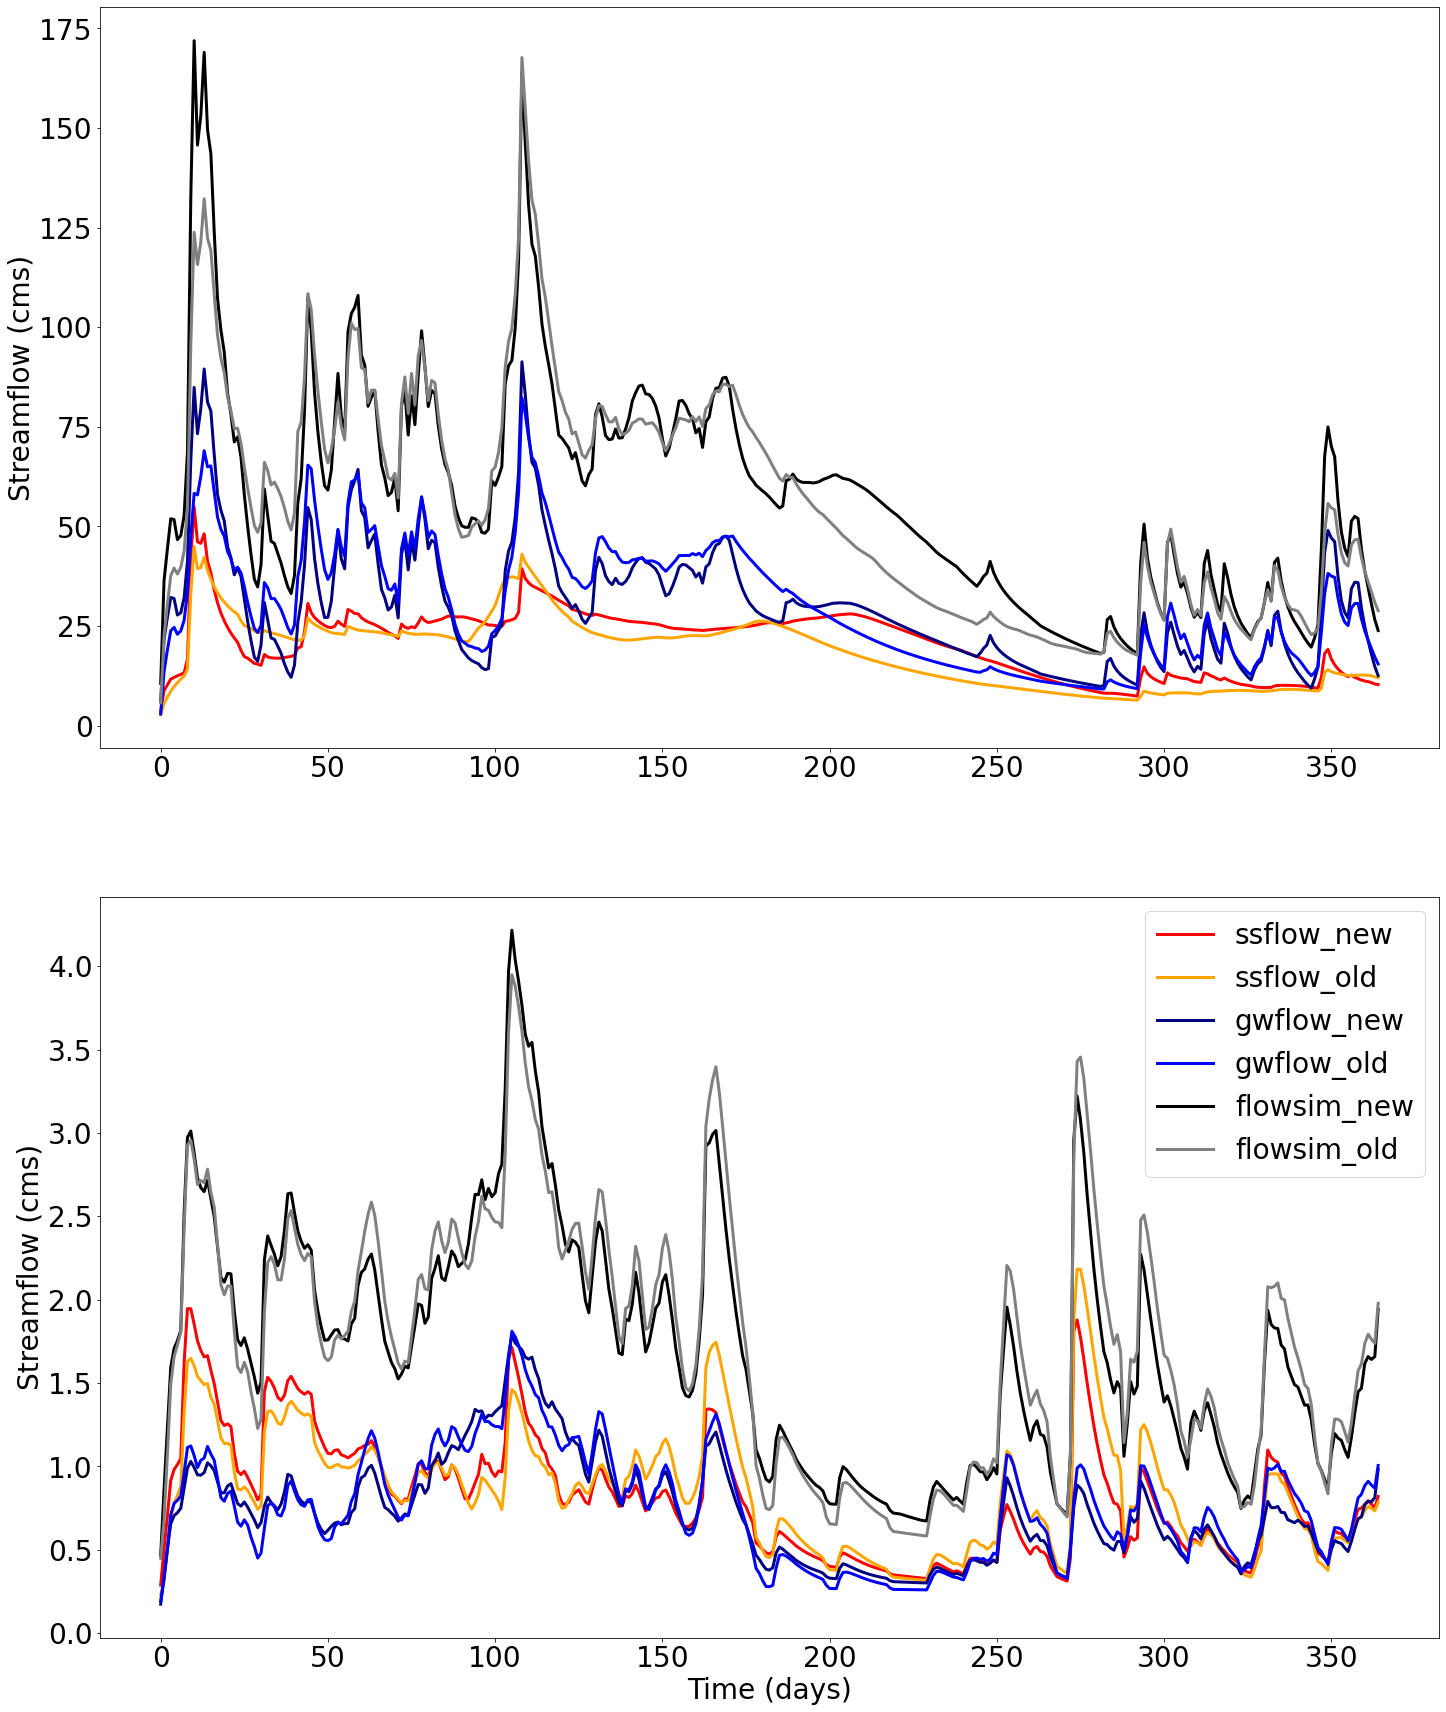

In [228]:
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models"
p_attr = r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003\dataset_20230923"
attr415 =  pd.read_feather(os.path.join(p_attr, "attr_415_tmean_ccov.feather"))

p1 = r"PRMS_SNTEMP_new\PS_new_415_0010\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs_new = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot_new = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim_new = flowSim_tot_new[:,:, 0]
srflow_new = flowSim_tot_new[:,:, 0] - flowSim_tot_new[:,:, 3] - flowSim_tot_new[:,:, 4]
ssflow_new = flowSim_tot_new[:,:, 4]
gwflow_new = flowSim_tot_new[:,:, 3]

p1 = r"PRMS_SNTEMP_new\PS_new_415_0010_old\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
flow_obs_S = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot_S = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

flowSim_S = flowSim_tot_S[:,:, 0]
srflow_S = flowSim_tot_S[:,:, 0] - flowSim_tot_S[:,:, 3] - flowSim_tot_S[:,:, 4]
ssflow_S = flowSim_tot_S[:,:, 4]
gwflow_S = flowSim_tot_S[:,:, 3]

# p1 = r"PRMS_SNTEMP\nmul16\inv_gw_tau_ST\SNTEMP_gw_365_ss_30_adj_T_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
# flow_obs_ST = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
# flowSim_tot_ST = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))

# flowSim_ST = flowSim_tot_ST[:,:, 0]
# srflow_ST = flowSim_tot_ST[:,:, 0] - flowSim_tot_ST[:,:, 3] - flowSim_tot_ST[:,:, 4]
# ssflow_ST = flowSim_tot_ST[:,:, 4]
# gwflow_ST = flowSim_tot_ST[:,:, 3]


ss = [408, 325]
# ss = [0, 100, 200]
area = attr415["DRAIN_SQKM"].to_numpy()  * (1000 / 86400)  # it is a converting unit for mm/day to m3/sec)
fig1, axs = plt.subplots(len(ss), 1, figsize=(24,30))
axs=axs.flatten()
plt.subplots_adjust(wspace=None,    # 0.4
                    hspace=None)
for i, ind in enumerate(ss):
#     ind = attr415[attr415["site_no"]==ss[i]].index[0]
    axs[i].plot(range(365), area [ind] * ssflow_new[ind,:365]  , label='ssflow_new', color = "red", lw=3)
    axs[i].plot(range(365), area [ind] * ssflow_S[ind,:365]  , label='ssflow_old', color = "orange", lw=3)
#     axs[i].plot(range(365), area [ind] * ssflow_ST[ind,:365]  , label='ssflow_ST', color = "pink", lw=3)
    axs[i].plot(range(365), area [ind] * gwflow_new[ind,:365] , label='gwflow_new', color = "navy", lw=3)
    axs[i].plot(range(365), area [ind] * gwflow_S[ind,:365], label='gwflow_old', color = "blue", lw=3)
#     axs[i].plot(range(365), area [ind] * gwflow_ST[ind,:365], label='gwflow_ST', color = "lightblue", lw=3)
    axs[i].plot(range(365),  area [ind] * flowSim_new[ind,:365] , label='flowsim_new', color = "black", lw=3)
    axs[i].plot(range(365),  area [ind] * flowSim_S[ind,:365] , label='flowsim_old', color = "grey", lw=3)
#     axs[i].plot(range(365),  area [ind] * flowSim_ST[ind,:365] , label='flowsim_ST', color = "lightgrey", lw=3)
#     axs[i].scatter(range(365),  area [ind] * flow_obs[ind,:365] , label='flowObs', color = "green", lw=4)
#     axs[i].set_yscale('log')
#     axs[i].plot(range(365), gw_p[ind,365:730]  , label='gw_p', color = "red", lw=2)
#     axs[i].plot(range(365), ss_p[ind,365:730] , label='ss_p', color = "black", lw=2)
#     axs[i].plot(range(365), sr_p[ind,365:730] , label='sr_p', color = "blue", lw=2)
    axs[i].set_ylabel('Streamflow (cms)', fontsize=28)
plt.xlabel('Time (days)', fontsize=28)


# plt.ylabel('streamflow (cms)', fontsize=28)

plt.legend()
# met.legend()
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)    # legend fontsize

# only PRMS on CAMELS

In [79]:
# PRMS only # NSE > 0.71
p = r"G:\Farshid\fzr5082\PGML_STemp_results\models\marrmot_PRMS_only\B_336\SNTEMP_gw_365_ss_30_adj_F_fr_T40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
attr671 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003", "attr_camels_tmean_ccov.feather"))
pflow_obs = np.load(os.path.join(p, "flow_obs.npy"))[:,:,0]
pflowSim_tot = np.load(os.path.join(p, "flowSim_tot.npy"))
pflowSim = pflowSim_tot[:,:, 0]
psrflow = pflowSim_tot[:,:, 0] - pflowSim_tot[:,:, 3] - pflowSim_tot[:,:, 4]
pssflow = pflowSim_tot[:,:, 4]
pgwflow = pflowSim_tot[:,:, 3]

FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Farshid\\fzr5082\\PGML_STemp_results\\models\\marrmot_PRMS_only\\B_336\\SNTEMP_gw_365_ss_30_adj_F_fr_T40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0\\flow_obs.npy'

In [80]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

item1 = np.nansum((pgwflow [:,:]), axis=1)/np.nansum(pflowSim, axis=1)
item2 = attr671["BFI_AVE"]/100

slope, intercept, r, p, se = scipy.stats.linregress(item1 , item2)
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.scatter(item1, item2, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,1)
plt.ylim(0.0, 1)
plt.grid()
plt.xlabel("Baseflow ratio in dPL (PRMS-only)", fontsize=26)
plt.ylabel("Baseflow index in Gages-II", fontsize=26)
plt.title("baseflow ratio scatter plot" + ", r=" + str("{:.3f}".format(r)), fontsize=26)

NameError: name 'pgwflow' is not defined

<Figure size 864x864 with 0 Axes>

# tempLoss

In [59]:
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models\tempLoss"
p1 = r"nmul1\tempLoss_208_n1\SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_1_s_0"

flow_obs = np.load(os.path.join(p_main, p1, "flow_obs.npy"))[:,:,0]
flowSim_tot = np.load(os.path.join(p_main, p1, "flowSim_tot.npy"))
flowSim = flowSim_tot[:,:, 0]
srflow =flowSim_tot[:,:, 0] - flowSim_tot[:,:, 3] - flowSim_tot[:,:, 4]
ssflow = flowSim_tot[:,:, 4]
gwflow = flowSim_tot[:,:, 3]
temp_obs = np.load(os.path.join(p_main, p1, "temp_obs.npy"))[:,:,0]
tempSim = np.load(os.path.join(p_main, p1, "temp_pred.npy"))[:,:,0]


Text(0.5, 1.0, 'baseflow ratio scatter plot, r=0.402')

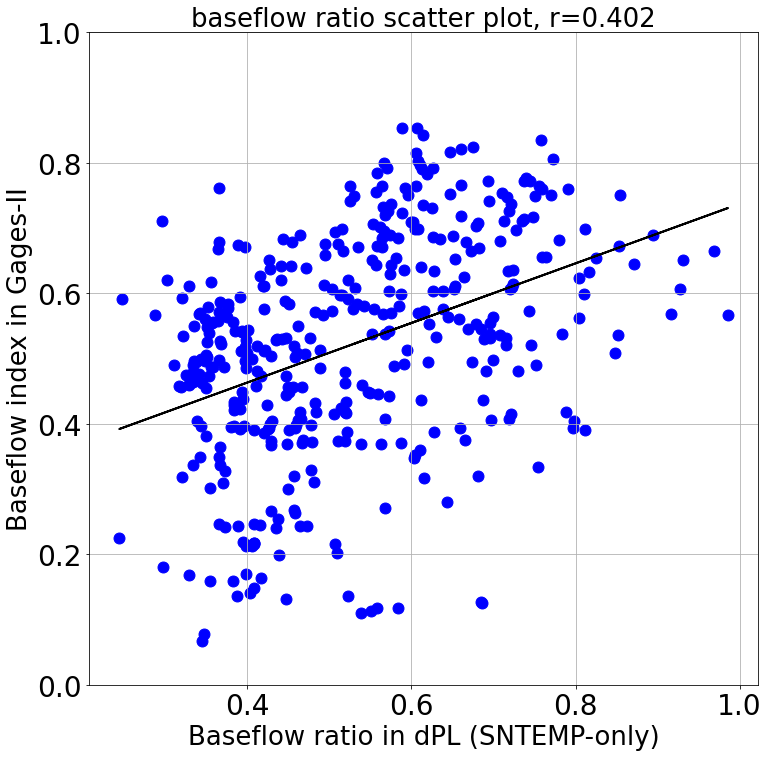

In [64]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

item1 = np.nansum((gwflow [:,:] + ssflow[:,:]), axis=1)/np.nansum(flowSim, axis=1)
item2 = attr415["BFI_AVE"]/100

slope, intercept, r, p, se = scipy.stats.linregress(item1 , item2)
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.scatter(item1, item2, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,1)
plt.ylim(0.0, 1)
plt.grid()
plt.xlabel("Baseflow ratio in dPL (SNTEMP-only)", fontsize=26)
plt.ylabel("Baseflow index in Gages-II", fontsize=26)
plt.title("baseflow ratio scatter plot" + ", r=" + str("{:.3f}".format(r)), fontsize=26)

In [61]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

item1 = np.nansum((srflow), axis=1)
item2 = np.nansum(tsrflow, axis=1)

slope, intercept, r, p, se = scipy.stats.linregress(item1 , item2)
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.scatter(item1, item2, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,4000)
# plt.ylim(0.0, 4000)
plt.grid()
plt.xlabel("Baseflow ratio in dPL (SNTEMP-only)", fontsize=26)
plt.ylabel("Baseflow index in Gages-II", fontsize=26)
plt.title("baseflow ratio scatter plot" + ", r=" + str("{:.3f}".format(r)), fontsize=26)

NameError: name 'tsrflow' is not defined

<Figure size 864x864 with 0 Axes>

In [117]:
tstat_flow = statError(tflowSim, tflow_obs)
tstat_temp = statError(ttempSim, ttemp_obs)

C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_29380\207158114.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_29380\207158114.py:8: RuntimeWarning: Mean of empty slice
  Bias = np.nanmean(pred - target, axis=1)
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_29380\207158114.py:67: RuntimeWarning: divide by zero encountered in float_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_29380\207158114.py:67: RuntimeWarning: invalid value encountered in float_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100


In [118]:
np.nanmedian(tstat_flow["NSE"])

-1.7030780862680879

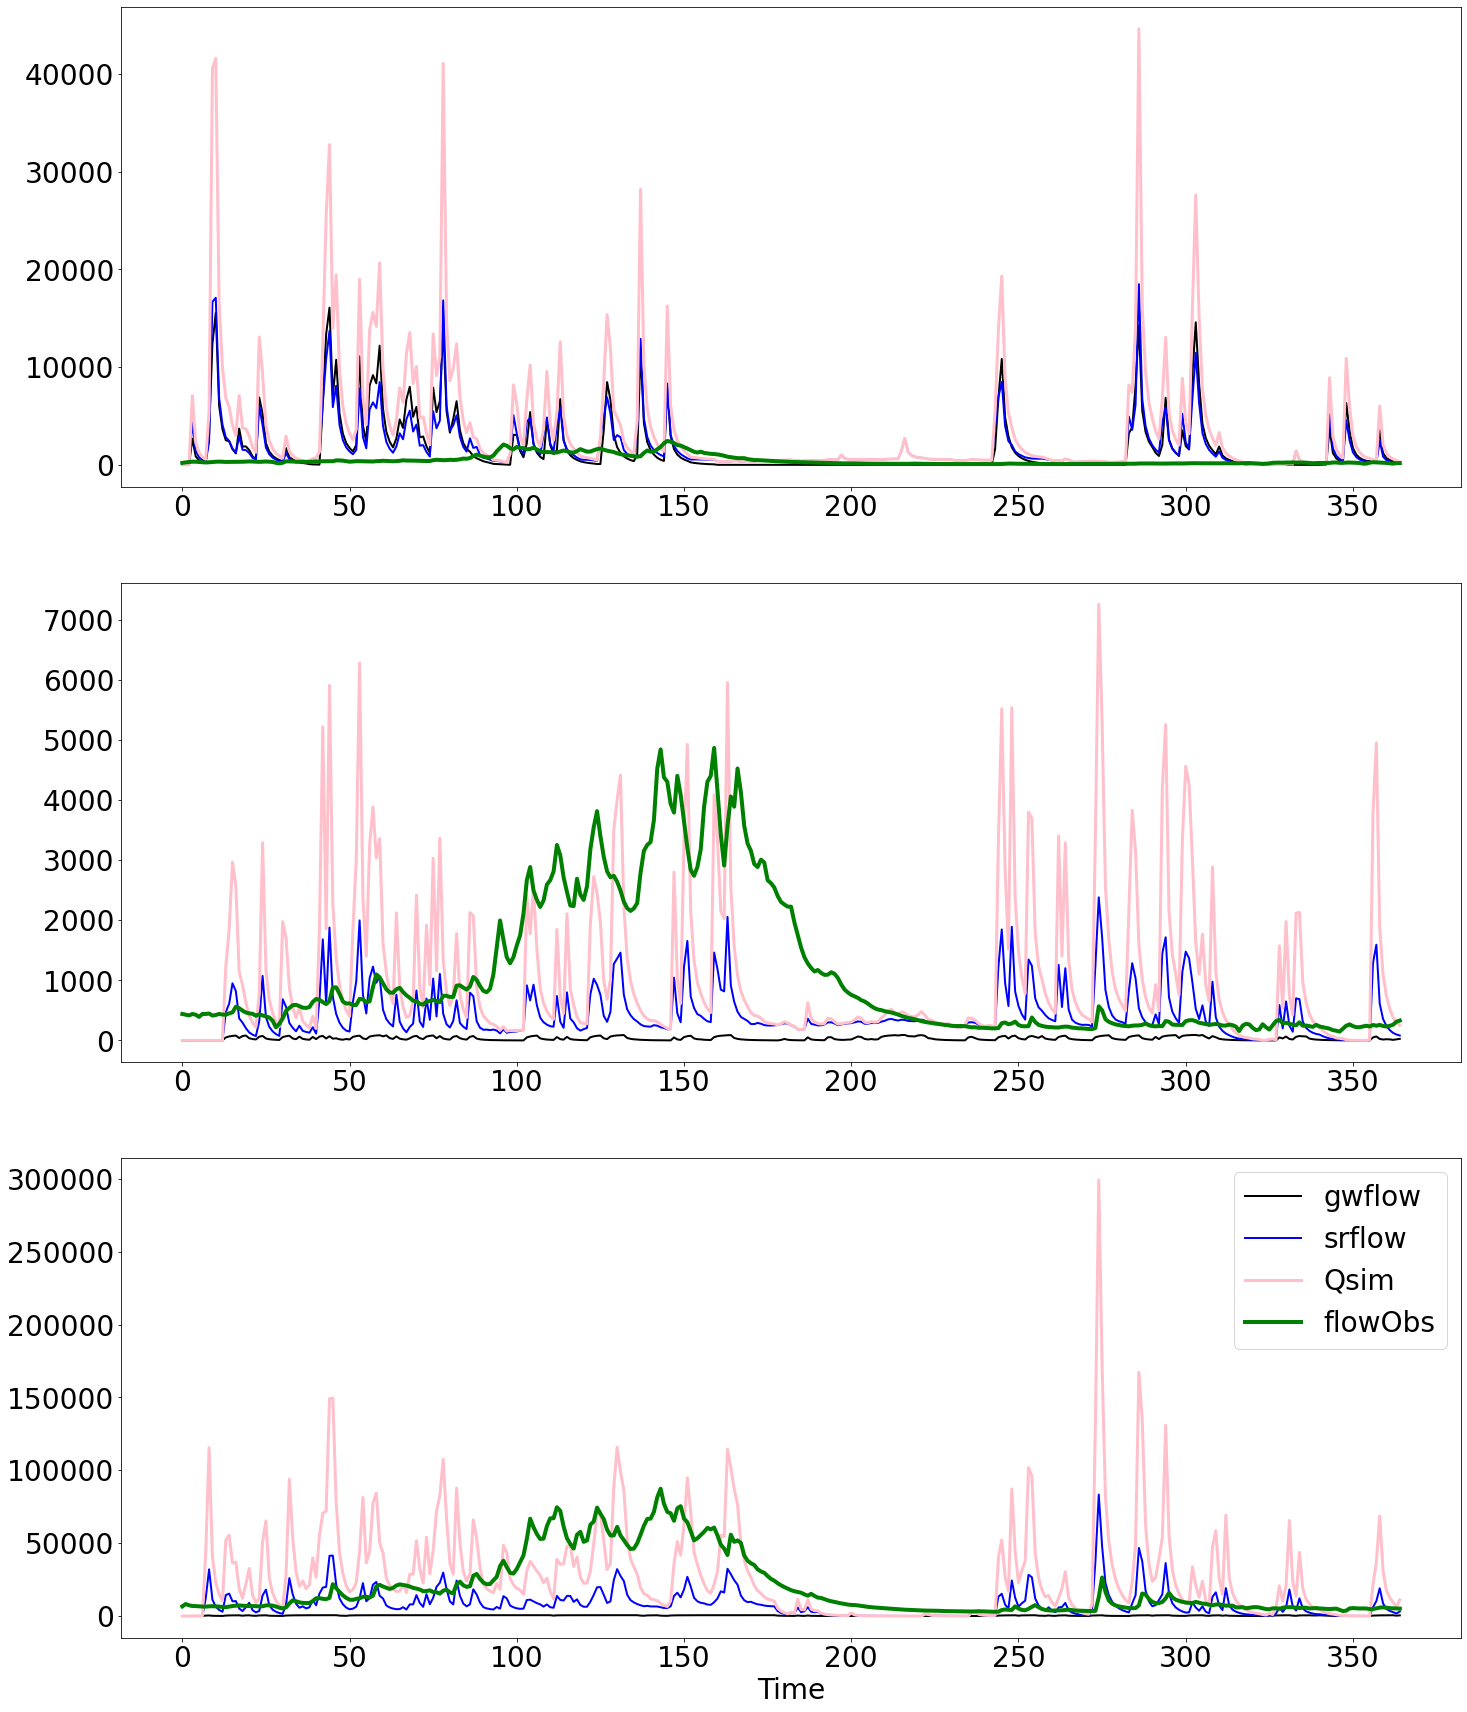

In [62]:
ss = sites415[350:353]#common_sites[50:53]
area = attr415["DRAIN_SQKM"].to_numpy()
fig1, axs = plt.subplots(len(ss), 1, figsize=(24,30))
axs=axs.flatten()
plt.subplots_adjust(wspace=None,    # 0.4
                    hspace=None)
for i, s in enumerate(ss):
    ind = attr415[attr415["site_no"]==ss[i]].index[0]
#     axs[i].plot(range(365), area [ind] * tsrflow[ind,:365]  , label='tsrflow', color = "red", lw=2)
    axs[i].plot(range(365), area [ind] * gwflow[ind,:365] , label='gwflow', color = "black", lw=2)
    axs[i].plot(range(365), area [ind] * srflow[ind,:365], label='srflow', color = "blue", lw=2)
    axs[i].plot(range(365),  area [ind] * flowSim[ind,:365] , label='Qsim', color = "pink", lw=3)
    axs[i].plot(range(365),  area [ind] * flow_obs[ind,:365] , label='flowObs', color = "green", lw=4)
#     axs[i].set_yscale('log')
#     axs[i].plot(range(365), gw_p[ind,365:730]  , label='gw_p', color = "red", lw=2)
#     axs[i].plot(range(365), ss_p[ind,365:730] , label='ss_p', color = "black", lw=2)
#     axs[i].plot(range(365), sr_p[ind,365:730] , label='sr_p', color = "blue", lw=2)
plt.xlabel('Time', fontsize=28)


# plt.ylabel('stream temperature', fontsize=26)

plt.legend()
# met.legend()
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)    # legend fontsize

In [175]:
s = 152
print(area[s] * gwflow[s, :].sum())
print(area[s] * tgwflow[s, :].sum())

1240224.7701204836
1321607.9374124757


# S_Sink0

In [178]:
d = "SNTEMP_gw_365_ss_30_adj_F_fr_F40_stat_10_semi_0_Pstat_21_Psemi_0_nmul_16_s_0"
snkflow_obs = np.load(os.path.join(p_main, "control_415_S_sink0", d, "flow_obs.npy"))[:,:,0]
snkflowSim_tot = np.load(os.path.join(p_main, "control_415_S_sink0", d, "flowSim_tot.npy"))
snkflowSim = snkflowSim_tot[:,:, 0]
snksrflow = snkflowSim_tot[:,:, 0] - snkflowSim_tot[:,:, 3] - snkflowSim_tot[:,:, 4]
snkssflow = snkflowSim_tot[:,:, 4]
snkgwflow = snkflowSim_tot[:,:, 3]
snktemp_obs = np.load(os.path.join(p_main, "control_415_tempLoss", d, "temp_obs.npy"))[:,:,0]
snktempSim = np.load(os.path.join(p_main, "control_415_tempLoss", d, "temp_pred.npy"))[:,:,0]

In [179]:
snkstat_flow = statError(snkflowSim, snkflow_obs)
snkstat_temp = statError(snktempSim, snktemp_obs)

C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_29380\207158114.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_29380\207158114.py:8: RuntimeWarning: Mean of empty slice
  Bias = np.nanmean(pred - target, axis=1)
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_29380\207158114.py:67: RuntimeWarning: divide by zero encountered in float_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_29380\207158114.py:67: RuntimeWarning: invalid value encountered in float_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100


In [185]:
print(np.nanmedian(snkstat_flow["NSE"][ind50]))
print(np.nanmedian(snkstat_temp["NSE"][ind50]))

0.5306110740293666
0.9382020011544228


Text(0.5, 1.0, 'baseflow ratio scatter plot, r=0.991')

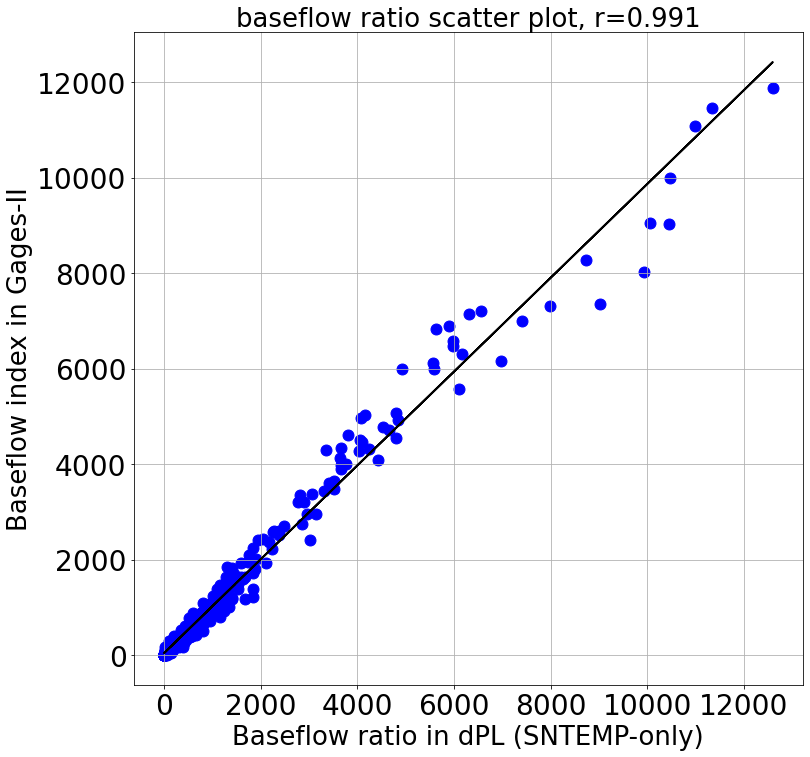

In [195]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

item1 = np.nansum((gwflow), axis=1)
item2 = np.nansum(snkgwflow, axis=1)

slope, intercept, r, p, se = scipy.stats.linregress(item1 , item2)
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.scatter(item1, item2, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,4000)
# plt.ylim(0.0, 4000)
plt.grid()
plt.xlabel("Baseflow ratio in dPL (SNTEMP-only)", fontsize=26)
plt.ylabel("Baseflow index in Gages-II", fontsize=26)
plt.title("baseflow ratio scatter plot" + ", r=" + str("{:.3f}".format(r)), fontsize=26)

Text(0.5, 1.0, 'baseflow ratio scatter plot, r=0.400')

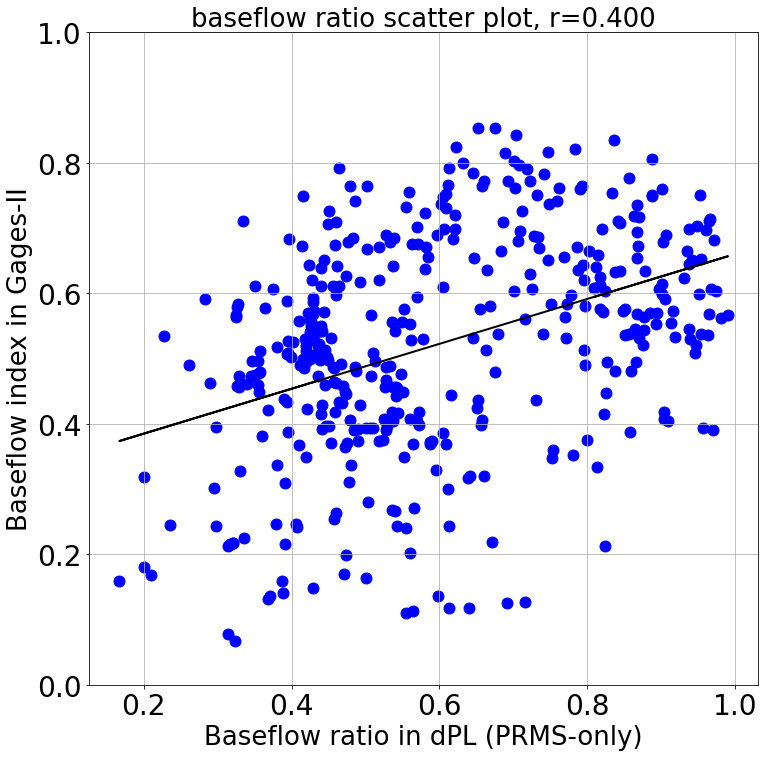

In [210]:
fig = plt.figure(1, figsize = (12,12))
colors = ['black', 'blue', 'red', 'orange', 'pink', 'green', 'yellow']
markers = ['s', "o", "*", "+", "D", "x"]

item1 = np.nansum(((snkgwflow+snkssflow)[:,:]), axis=1)/np.nansum(snkflowSim, axis=1)
item2 = attr415["BFI_AVE"]/100

slope, intercept, r, p, se = scipy.stats.linregress(item1 , item2)
plt.plot(item1, slope* item1+intercept, color="black", lw=2.0)
plt.scatter(item1, item2, c = colors[1], s = 120, marker = markers[1])
# leg = "r= " + str("{:.3f}".format(r))
# leg_list.append(leg)
# plt.legend(leg, loc='lower right', title = 'karst type')
# plt.xlim(0.0,1)
plt.ylim(0.0, 1)
plt.grid()
plt.xlabel("Baseflow ratio in dPL (PRMS-only)", fontsize=26)
plt.ylabel("Baseflow index in Gages-II", fontsize=26)
plt.title("baseflow ratio scatter plot" + ", r=" + str("{:.3f}".format(r)), fontsize=26)

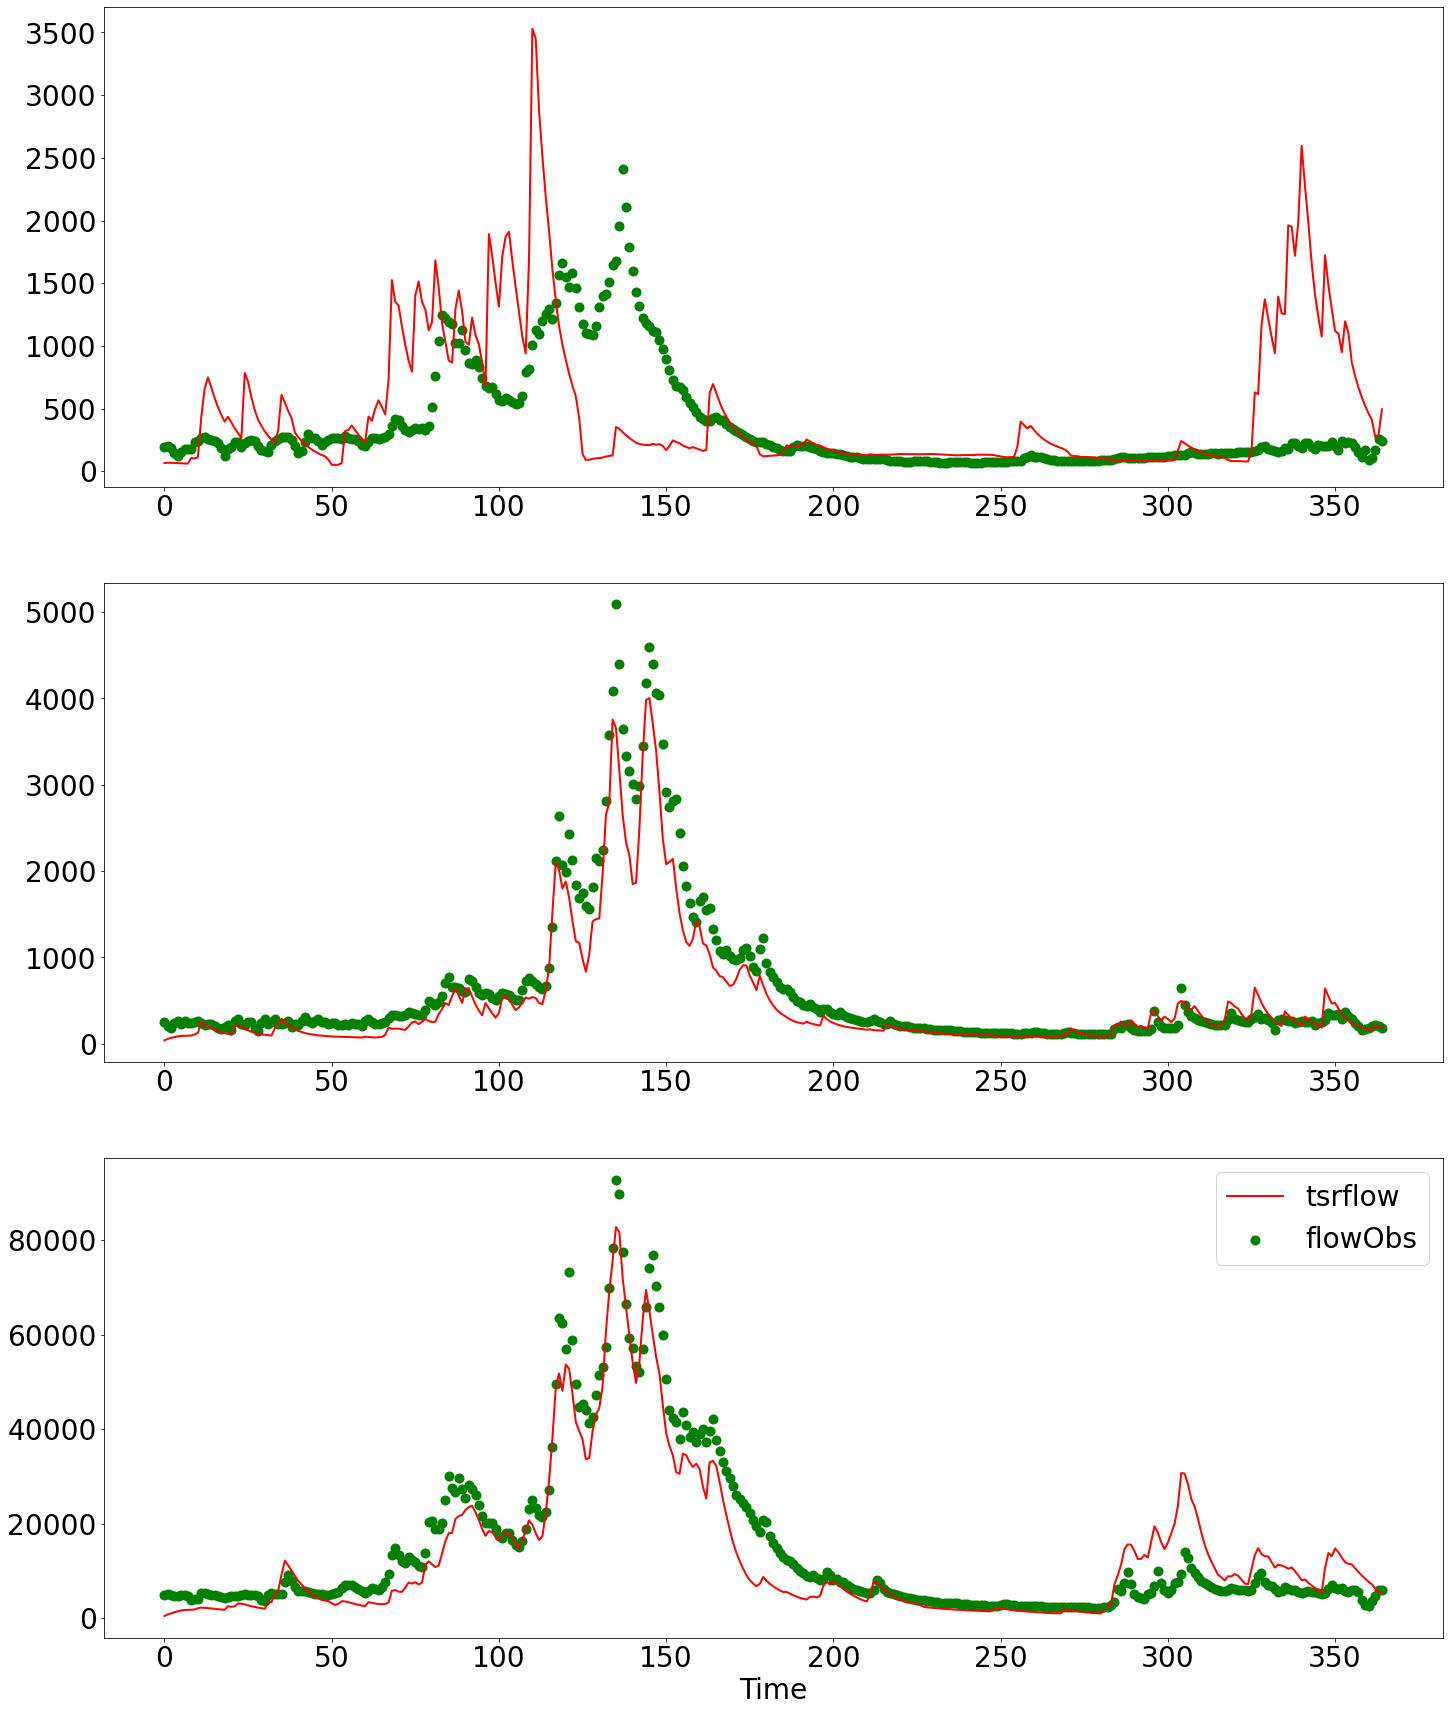

In [209]:
ss = sites415[350:353]#common_sites[50:53]
area = attr415["DRAIN_SQKM"].to_numpy()
fig1, axs = plt.subplots(len(ss), 1, figsize=(24,30))
axs=axs.flatten()
plt.subplots_adjust(wspace=None,    # 0.4
                    hspace=None)
for i, s in enumerate(ss):
    ind = attr415[attr415["site_no"]==ss[i]].index[0]
    axs[i].plot(range(365), area [ind] * (snksrflow + snkssflow + snkgwflow)[ind,:365]  , label='tsrflow', color = "red", lw=2)
#     axs[i].plot(range(365), area [ind] * snkgwflow[ind,:365] , label='tgwflow', color = "black", lw=2)
#     axs[i].plot(range(365), area [ind] * srflow[ind,:365], label='srflow', color = "blue", lw=2)
#     axs[i].plot(range(365),  area [ind] * gwflow[ind,:365] , label='gwflow', color = "pink", lw=3)
    axs[i].scatter(range(365),  area [ind] * flow_obs[ind,:365] , label='flowObs', color = "green", lw=4)
#     axs[i].set_yscale('log')
#     axs[i].plot(range(365), gw_p[ind,365:730]  , label='gw_p', color = "red", lw=2)
#     axs[i].plot(range(365), ss_p[ind,365:730] , label='ss_p', color = "black", lw=2)
#     axs[i].plot(range(365), sr_p[ind,365:730] , label='sr_p', color = "blue", lw=2)
plt.xlabel('Time', fontsize=28)


# plt.ylabel('stream temperature', fontsize=26)

plt.legend()
# met.legend()
plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=28)    # fontsize of the tick labels
plt.rc('ytick', labelsize=28)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)    # legend fontsize

# Analysis

In [179]:
attr50 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003\PRMS_SNTEMP", "attr50.feather"))
attr415 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003\PRMS_SNTEMP", "attr_415_tmean_ccov.feather"))
attr365 = pd.read_feather(os.path.join(r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003\PRMS_SNTEMP", "attr365.feather"))

sites50 = attr50["site_no"].to_numpy()
sites415 = attr415["site_no"].to_numpy()
sites365 = attr365["site_no"].to_numpy()

ind50 = []
ind365 = []
for i, s in enumerate(sites415):
    if s in sites50:
        ind50.append(i)
    else:
        ind365.append(i)
ind50 = np.array(ind50)
ind365 = np.array(ind365)

In [653]:
p_main = r"G:\Farshid\fzr5082\PGML_STemp_results\models"
p1 = [
   r"PRMS_SNTEMP\nmul16_sep14",
#     r"PRMS_SNTEMP\nmul16",
#     r"PRMS_SNTEMP\new4",
   # r"snow_module\nmul1",
#     r"snow_module\nmul16",
   # r"tempLoss\nmul1"
]
items = ['flow', 'temp']
metrics = ["NSE", "KGE"]  #, "BFI corr", "NSE PUB", "KGE PUB", "BFI corr PUB"]
t1 = 0    # first day of testing
t2 = 3653    # last day of testing
all_paths = []
ind = []
for i in p1:
    run_list = glob.glob(os.path.join(p_main, i + "\*"))
    all_paths = all_paths + run_list

results = pd.DataFrame(index=ind)
for path in all_paths:
    for item in items:
        if item == "temp":
            pred = np.load(os.path.join(glob.glob(path + "\*")[0], "temp_pred.npy"))[:,t1:t2,:]
            obs = np.load(os.path.join(glob.glob(path + "\*")[0], "temp_obs.npy"))[:,t1:t2,:]
        if item == "flow":
            flowSim_tot = np.load(os.path.join(glob.glob(path + "\*")[0], "flowSim_tot.npy"))[:,t1:t2,:]
            pred = flowSim_tot[:,:, 0:1]
            area = np.array(attr415["DRAIN_SQKM"])
            A = np.expand_dims(area, axis=1)
            AREA = np.repeat(A, t2 - t1).reshape((flowSim_tot.shape[0], t2 - t1))
            flowSim = AREA * flowSim_tot[:,t1:t2, 0]
            srflow = AREA * (flowSim_tot[:,t1:t2, 0] - flowSim_tot[:,t1:t2, 3] - flowSim_tot[:,t1:t2, 4])
            ssflow = AREA * flowSim_tot[:,t1:t2, 4]
            gwflow = AREA * flowSim_tot[:,t1:t2, 3]
            sr_p = srflow / flowSim
            gw_p = gwflow / flowSim
            ss_p = ssflow / flowSim
            obs = np.load(os.path.join(glob.glob(path + "\*")[0], "flow_obs.npy"))[:,t1:t2,:]
        
        statDictLst = statError(pred.squeeze(), obs.squeeze())
        for metric in metrics:
            col = metric + "_" + item
            ind = os.path.basename(path) + "_" + path.split("\\")[-2]
            value = np.nanmedian(np.array(statDictLst[metric][ind365]))
            results.loc[ind, col] = value
            ### PUB section
            col = col + "_PUB"
            value = np.nanmedian(np.array(statDictLst[metric][ind50]))
            results.loc[ind, col] = value
        #### BFI correlation
        if item == "flow":
            item1 = np.nansum(gwflow[:,:], axis=1)/np.nansum(flowSim, axis=1)
            item2 = attr415["BFI_AVE"]/100
            slope, intercept, r, p, se = scipy.stats.linregress(item1[ind365] , item2[ind365])
            col = "BFI_corr"
            results.loc[ind, col] = r
            # for BFI_coor in PUB
            slope, intercept, r, p, se = scipy.stats.linregress(item1[ind50] , item2[ind50])
            col = "BFI_corr_PUB"
            results.loc[ind, col] = r
# results.to_csv(os.path.join(p_main, "results.csv"))
results           

C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:8: RuntimeWarning: Mean of empty slice
  Bias = np.nanmean(pred - target, axis=1)
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:68: RuntimeWarning: invalid value encountered in float_scalars
  PBiashigh[k] = np.sum(highpred - hightarget) / np.sum(hightarget) * 100
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:67: RuntimeWarning: divide by zero encountered in float_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
C:\Users\fzr5082\AppData\Local\Temp\2\ipykernel_46544\207158114.py:67: RuntimeWarning: invalid value encountered in float_scalars
  PBiaslow[k] = np.sum(lowpred - lowtarget) / np.sum(lowtarget) * 100
G:\Farshid\Programs\anaconda3\envs\PGML_STem

NSE_flow  NSE_flow_PUB  KGE_flow  \
inv_gw_tau_S_Cw_nmul16_sep14       0.653722      0.523185  0.704150   
inv_gw_tau_S_Cw_Csh_nmul16_sep14   0.652682      0.483475  0.699227   
inv_gw_tau_S_Cw_snk_nmul16_sep14   0.662547      0.497903  0.702975   
inv_gw_tau_S_Cw_ss15_nmul16_sep14  0.669736      0.494525  0.707181   
inv_gw_tau_S_Cw_ss45_nmul16_sep14  0.645088      0.525636  0.706669   
inv_gw_tau_S_Cw_ss7_nmul16_sep14   0.662430      0.479309  0.705751   
inv_gw_tau_S_Cw_w10_nmul16_sep14   0.659246      0.511687  0.698431   
inv_gw_tau_S_Cw_w11_nmul16_sep14   0.656495      0.530532  0.708904   
inv_gw_tau_S_Cw_w8_nmul16_sep14    0.652418      0.457949  0.696925   
nPS_w10_w1_Cw_nmul16_sep14         0.648285      0.531502  0.710508   
nPS_w10_w1_Cw_S_nmul16_sep14       0.673096      0.542729  0.722072   
nPS_w10_w1_Cw_ST_nmul16_sep14      0.684610      0.574675  0.711765   
nPS_w11_w1_Cw_nmul16_sep14         0.664165      0.574403  0.710628   
nPS_w11_w1_Cw_S_nmul16_sep14       0.676757      0.545760  0.725634   
nPS_w11_w1_Cw_ST_nmul16_sep14      0.681294      0.568622  0.731958   
nPS_w8_w1_Cw_nmul16_sep14          0.639912      0.496453  0.707077   
nPS_w8_w1_Cw_S_nmul16_sep14        0.677319      0.463450  0.715378   
nPS_w8_w1_Cw_ST_nmul16_sep14       0.680461      0.522405  0.711275   
nPS_w9_w1_Cw_nmul16_sep14          0.650723      0.545417  0.703755   
nPS_w9_w1_Cw_Csh_S_nmul16_sep14    0.686377      0.549749  0.719912   
nPS_w9_w1_Cw_S_nmul16_sep14        0.676205      0.491366  0.724678   
nPS_w9_w1_Cw_ST_nmul16_sep14       0.683736      0.577375  0.717540   

                                   KGE_flow_PUB  BFI_corr  BFI_corr_PUB  \
inv_gw_tau_S_Cw_nmul16_sep14           0.546513  0.960951      0.969073   
inv_gw_tau_S_Cw_Csh_nmul16_sep14       0.536090  0.968770      0.961371   
inv_gw_tau_S_Cw_snk_nmul16_sep14       0.533346  0.967606      0.973946   
inv_gw_tau_S_Cw_ss15_nmul16_sep14      0.501271  0.958070      0.960605   
inv_gw_tau_S_Cw_ss45_nmul16_sep14      0.529193  0.966354      0.979461   
inv_gw_tau_S_Cw_ss7_nmul16_sep14       0.527528  0.960048      0.963280   
inv_gw_tau_S_Cw_w10_nmul16_sep14       0.510177  0.959097      0.961977   
inv_gw_tau_S_Cw_w11_nmul16_sep14       0.527609  0.965341      0.973255   
inv_gw_tau_S_Cw_w8_nmul16_sep14        0.520585  0.958764      0.968440   
nPS_w10_w1_Cw_nmul16_sep14             0.540521  0.364488      0.559419   
nPS_w10_w1_Cw_S_nmul16_sep14           0.550687  0.337253      0.560350   
nPS_w10_w1_Cw_ST_nmul16_sep14          0.571630  0.479563      0.550995   
nPS_w11_w1_Cw_nmul16_sep14             0.557169  0.332174      0.564854   
nPS_w11_w1_Cw_S_nmul16_sep14           0.545452  0.337118      0.569078   
nPS_w11_w1_Cw_ST_nmul16_sep14          0.537079  0.516625      0.519230   
nPS_w8_w1_Cw_nmul16_sep14              0.555452  0.302846      0.541321   
nPS_w8_w1_Cw_S_nmul16_sep14            0.494662  0.368069      0.625021   
nPS_w8_w1_Cw_ST_nmul16_sep14           0.546793  0.484822      0.537705   
nPS_w9_w1_Cw_nmul16_sep14              0.582426  0.326825      0.553661   
nPS_w9_w1_Cw_Csh_S_nmul16_sep14        0.520983  0.341013      0.596526   
nPS_w9_w1_Cw_S_nmul16_sep14            0.511716  0.355704      0.542160   
nPS_w9_w1_Cw_ST_nmul16_sep14           0.562353  0.484591      0.486197   

                                   NSE_temp  NSE_temp_PUB  KGE_temp  \
inv_gw_tau_S_Cw_nmul16_sep14       0.875484      0.908543  0.849548   
inv_gw_tau_S_Cw_Csh_nmul16_sep14   0.874419      0.909742  0.848620   
inv_gw_tau_S_Cw_snk_nmul16_sep14   0.877238      0.915661  0.858423   
inv_gw_tau_S_Cw_ss15_nmul16_sep14  0.879568      0.913197  0.858340   
inv_gw_tau_S_Cw_ss45_nmul16_sep14  0.877955      0.908524  0.853262   
inv_gw_tau_S_Cw_ss7_nmul16_sep14   0.880595      0.921146  0.852682   
inv_gw_tau_S_Cw_w10_nmul16_sep14   0.875997      0.914891  0.852555   
inv_gw_tau_S_Cw_w11_nmul16_sep14   0.876791      0.913118  0.851266   
inv_gw_tau_S_Cw_w8_nmul16_sep14    0

In [603]:
p0 = r"G:\Farshid\PGML_STemp_results\inputs"
p1 = r"inputs_2003"

In [579]:
force_cam = pd.read_feather(os.path.join(p0, p1, "forcing_camels_tmean_ccov.feather"))

In [580]:
force_cam

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0         30174.590000      0.000000  153.420000    81.49  -6.570000   
1         30256.910000      0.000000  143.370000    81.49  -6.210000   
2         30348.080000      0.000000  148.210000    81.49  -9.590000   
3         30408.560000      0.000000  142.400000    81.49 -11.120000   
4         30413.580000      0.000000  171.290000    81.49 -11.100000   
...                ...           ...         ...      ...        ...   
10538721  32146.992188     11.441929  123.747009     0.00  10.022831   
10538722  32173.228516     14.305569   90.295898     0.00   6.524961   
10538723  32203.302734     41.802055  123.891754     0.00   8.718740   
10538724  32237.175781     27.081196   75.351463     0.00   9.370980   
10538725  32274.835938      0.000000  146.012436     0.00   8.010762   

            tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0        -16.520000  168.140000 1980-01-01  01013500         NaN       655.0   
1        -15.270000  185.070000 1980-01-02  01013500         NaN       640.0   
2        -18.850000  139.020000 1980-01-03  01013500         NaN       625.0   
3        -19.770000  120.000000 1980-01-04  01013500         NaN       620.0   
4        -22.330000  119.940000 1980-01-05  01013500         NaN       605.0   
...             ...         ...        ...       ...         ...         ...   
10538721   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
10538722   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
10538723   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
10538724   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
10538725   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

          t_monthly(C)      ccov  
0           -11.664194  0.498705  
1           -11.664194  0.533141  
2           -11.664194  0.518997  
3           -11.664194  0.539856  
4           -11.664194  0.450018  
...                ...       ...  
10538721      5.028073  0.672465  
10538722      5.028073  0.761270  
10538723      5.028073  0.672797  
10538724      5.028073  0.801295  
10538725      5.028073  0.615852  

[10538726 rows x 13 columns]

In [581]:
attr_cam = pd.read_feather(os.path.join(p0, p1, "attr_camels_tmean_ccov.feather"))

In [597]:
attr_cam

site_no        lat         lon  ELEV_MEAN_M_BASIN  ELEV_MAX_M_BASIN  \
0    01013500  47.237394  -68.582642          273.25290               604   
1    01022500  44.607972  -67.935242           97.81586               448   
2    01030500  45.500975  -68.305956          171.81640               736   
3    01031500  45.175008  -69.314697          299.38860               791   
4    01047000  44.869200  -69.955103          374.06060              1283   
..        ...        ...         ...                ...               ...   
666  14309500  42.804004 -123.610907          736.26540              1311   
667  14316700  43.349842 -122.728942          943.95520              1816   
668  14325000  42.891499 -124.070652          651.89260              1239   
669  14362250  42.154014 -123.075323          981.10790              1531   
670  14400000  42.123443 -124.187311          671.22900              1535   

     ELEV_MIN_M_BASIN  ELEV_MEDIAN_M_BASIN  ELEV_STD_M_BASIN  SLOPE_PCT  \
0                 157                  253          81.77274   6.942492   
1                  16                   86          50.29952   3.672354   
2                  65                  158          53.85714   3.206527   
3                 110                  304         105.71720   6.487379   
4                  94                  334         210.72900  11.526680   
..                ...                  ...               ...        ...   
666               313                  726         155.64210  32.958160   
667               347                  917         257.52510  34.403700   
668                66                  700         258.96750  28.398170   
669               527                  984         192.66980  37.494080   
670                17                  662         301.84210  36.483230   

     DRAIN_SQKM  ...  POWER_NUM_PTS  POWER_SUM_MW  ROADS_KM_SQ_KM  \
0     2252.6960  ...              0           0.0        0.525129   
1      573.6006  ...              0           0.0        0.663870   
2     3676.1720  ...              0           0.0        0.614653   
3      769.0482  ...              0           0.0        0.774446   
4      909.0972  ...              1           0.1        0.922040   
..          ...  ...            ...           ...             ...   
666    224.9208  ...              0           0.0        0.838063   
667    587.8989  ...              0           0.0        1.411133   
668    443.0745  ...              0           0.0        1.562150   
669     41.4216  ...              0           0.0        1.615760   
670    702.6345  ...              0           0.0        0.599696   

     PADCAT1_PCT_BASIN  PADCAT2_PCT_BASIN  RIP100_DEV  RIP100_FOREST  \
0             0.000000           1.467642    1.053535      61.301029   
1             0.000000           2.238073    0.604539      59.374068   
2             0.434972           0.753531    1.598095      52.979183   
3             0.000000           0.999300    2.248595      68.429120   
4             0.000000           0.945245    5.832918      64.527970   
..                 ...                ...         ...            ...   
666           4.750072           3.806940    3.447246      79.091301   
667           0.796208          79.458560    0.000000      92.346149   
668           7.150649          41.547010    7.060731      73.325037   
669           0.000000           0.000000    6.104011      74.371970   
670          58.204440          19.951200    1.533750      65.248099   

     BAS_COMPACTNESS  stream_length_artificial  stream_length_square  
0           0.870796             127154.887109             23.731287  
1           1.128244              56369.390711             11.974980  
2           1.241853             136020.037000             30.315722  
3           1.166719              64185.008346             13.865859  
4           1.423365              63181.084189             15.075619  
..               ...                       ...              

In [ ]:
varc_nn = [
      'ELEV_MEAN_M_BASIN',  'ELEV_STD_M_BASIN',
  'SLOPE_PCT', 'DRAIN_SQKM', 'NDAMS_2009', 'MAJ_NDAMS_2009',
  'FRAGUN_BASIN', 'FORESTNLCD06',  'AWCAVE', 'PERMAVE', 'BDAVE',
  'ROCKDEPAVE', 'CLAYAVE', 'SILTAVE', 'SANDAVE', 'HGA', 'HGB',
  'HGC', 'HGVAR', 'HGD', 'PPTAVG_BASIN', 'SNOW_PCT_PRECIP',
  'PRECIP_SEAS_IND', 'T_AVG_BASIN',  'T_MAX_BASIN',
  'T_MAXSTD_BASIN', 'RH_BASIN',
  'GEOL_REEDBUSH_DOM_PCT', 'GEOL_REEDBUSH_DOM',
  'HIRES_LENTIC_PCT', 'PERDUN', 'PERHOR', 'RIP100_FOREST'
]

for i in varc_nn:
    if i in attr_cam.columns:
        print(i)

In [590]:
attr_pet = pd.read_feather(os.path.join(p0, "camels", "camels_671_attr_site_no.feather"))

In [591]:
attr_pet.columns

Index(['p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur',
       'elev_mean', 'slope_mean', 'area_gages2', 'frac_forest', 'lai_max',
       'lai_diff', 'gvf_max', 'gvf_diff', 'dom_land_cover_frac',
       'dom_land_cover', 'root_depth_50', 'soil_depth_pelletier',
       'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
       'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
       'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class',
       'glim_2nd_class_frac', 'carbonate_rocks_frac', 'geol_porostiy',
       'geol_permeability', 'site_no'],
      dtype='object')

In [593]:
force_pet = pd.read_feather(os.path.join(p0, "camels", "camels_671_forcing_pet.feather"))
force_pet

datetime   dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)  tmax(C)  \
0       1980-01-01  30172.51          0.00      153.40      0.0    -6.54   
1       1980-01-02  30253.10          0.00      145.27      0.0    -6.18   
2       1980-01-03  30344.18          0.00      146.96      0.0    -9.89   
3       1980-01-04  30408.33          0.00      146.20      0.0   -10.98   
4       1980-01-05  30413.48          0.00      170.43      0.0   -11.29   
...            ...       ...           ...         ...      ...      ...   
8578059 2014-12-27  32140.81          0.00      196.83      0.0     9.55   
8578060 2014-12-28  32140.81          4.93      133.57      0.0     7.90   
8578061 2014-12-29  32140.81          6.54      134.34      0.0     5.51   
8578062 2014-12-30  32140.81          4.60      149.87      0.0     4.78   
8578063 2014-12-31  32141.49          0.00      223.80      0.0     9.78   

         tmin(C)  vp(Pa)   site_no  00060_Mean  pet_nldas  
0         -16.30  171.69  01013500       655.0   0.131711  
1         -15.22  185.94  01013500       640.0   0.170168  
2         -18.86  138.39  01013500       625.0   0.084095  
3         -19.76  120.06  01013500       620.0   0.028277  
4         -22.21  117.87  01013500       605.0   0.005334  
...          ...     ...       ...         ...        ...  
8578059     1.93  704.03  14400000      3800.0   0.667133  
8578060     1.59  687.43  14400000      3220.0   0.565824  
8578061    -0.78  581.32  14400000      2810.0   0.559149  
8578062    -2.52  512.63  14400000      2460.0   0.589410  
8578063    -0.89  575.12  14400000      2160.0   0.673057  

[8578064 rows x 11 columns]

In [598]:
for i in attr_pet.columns:
    attr_cam[i] = attr_pet[i]

In [599]:
attr_cam

site_no        lat         lon  ELEV_MEAN_M_BASIN  ELEV_MAX_M_BASIN  \
0    01013500  47.237394  -68.582642          273.25290               604   
1    01022500  44.607972  -67.935242           97.81586               448   
2    01030500  45.500975  -68.305956          171.81640               736   
3    01031500  45.175008  -69.314697          299.38860               791   
4    01047000  44.869200  -69.955103          374.06060              1283   
..        ...        ...         ...                ...               ...   
666  14309500  42.804004 -123.610907          736.26540              1311   
667  14316700  43.349842 -122.728942          943.95520              1816   
668  14325000  42.891499 -124.070652          651.89260              1239   
669  14362250  42.154014 -123.075323          981.10790              1531   
670  14400000  42.123443 -124.187311          671.22900              1535   

     ELEV_MIN_M_BASIN  ELEV_MEDIAN_M_BASIN  ELEV_STD_M_BASIN  SLOPE_PCT  \
0                 157                  253          81.77274   6.942492   
1                  16                   86          50.29952   3.672354   
2                  65                  158          53.85714   3.206527   
3                 110                  304         105.71720   6.487379   
4                  94                  334         210.72900  11.526680   
..                ...                  ...               ...        ...   
666               313                  726         155.64210  32.958160   
667               347                  917         257.52510  34.403700   
668                66                  700         258.96750  28.398170   
669               527                  984         192.66980  37.494080   
670                17                  662         301.84210  36.483230   

     DRAIN_SQKM  ...  sand_frac  silt_frac  clay_frac  geol_1st_class  \
0     2252.6960  ...  27.841827  55.156940  16.275732            10.0   
1      573.6006  ...  59.390156  28.080937  12.037646             0.0   
2     3676.1720  ...  32.235458  51.779182  14.776824            10.0   
3      769.0482  ...  35.269030  50.841232  12.654125            10.0   
4      909.0972  ...  55.163133  34.185443  10.303622             7.0   
..          ...  ...        ...        ...        ...             ...   
666    224.9208  ...  37.751217  38.879406  23.213862            10.0   
667    587.8989  ...  37.238495  38.519396  24.363634             3.0   
668    443.0745  ...  38.961578  40.860260  20.068726            10.0   
669     41.4216  ...  37.914394  39.602460  22.404372             3.0   
670    702.6345  ...  30.026587  42.214515  27.805122            10.0   

     glim_1st_class_frac  geol_2nd_class  glim_2nd_class_frac  \
0               0.815904             3.0             0.179729   
1               0.590658            10.0             0.164618   
2               0.573305             7.0             0.287010   
3               0.448928             7.0             0.443863   
4               0.308488             0.0             0.288613   
..                   ...             ...                  ...   
666             0.863563             3.0             0.095225   
667             0.444680             8.0             0.373506   
668             0.903702             2.0             0.062996   
669             0.983481             0.0             0.016519   
670             0.606239             2.0             0.288975   

     carbonate_rocks_frac  geol_porostiy  geol_permeability  
0                0.000000         0.1714           -14.7019  
1                0.000000         0.0710           -14.2138  
2                0.052140         0.1178           -14.4918  
3                0.026258         0.0747           -14.8410  
4                0.000000         0.0522           -14.4819  
..                    ...            ...                ...  
666              0.000000         0.1731           -14.8976  
667              0.000000 

In [604]:
attr_cam.to_feather(os.path.join( p0, p1, "attr_camels_all_sep14_2023.feather"), compression="uncompressed")

In [605]:
force_2003 = pd.read_feather(os.path.join(p0, p1, "forcing_2003_tmean_ccov.feather"))
force_2003

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0         30375.080000      0.000000  180.500000    83.27  -5.670000   
1         30415.730000      0.000000  107.000000    83.27  -6.240000   
2         30453.240000      0.000000  176.110000    83.27  -8.630000   
3         30547.920000      0.000000  148.120000    83.27 -11.450000   
4         30613.740000      0.000000  171.250000    83.27 -11.450000   
...                ...           ...         ...      ...        ...   
31459113  32146.992188     11.441929  123.747009     0.00  10.022831   
31459114  32173.228516     14.305569   90.295898     0.00   6.524961   
31459115  32203.302734     41.802055  123.891754     0.00   8.718740   
31459116  32237.175781     27.081196   75.351463     0.00   9.370980   
31459117  32274.835938      0.000000  146.012436     0.00   8.010762   

            tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0        -17.790000  155.670000 1980-01-01  01011000         0.0       660.0   
1        -12.210000  240.400000 1980-01-02  01011000         0.0       645.0   
2        -19.910000  123.220000 1980-01-03  01011000         0.0       630.0   
3        -20.000000  120.030000 1980-01-04  01011000         0.0       615.0   
4        -21.940000  114.850000 1980-01-05  01011000         0.0       605.0   
...             ...         ...        ...       ...         ...         ...   
31459113   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
31459114   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
31459115   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
31459116   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
31459117   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

          t_monthly(C)      ccov  
0           -11.931613  0.412675  
1           -11.931613  0.653484  
2           -11.931613  0.432560  
3           -11.931613  0.524256  
4           -11.931613  0.452335  
...                ...       ...  
31459113      5.028073  0.672465  
31459114      5.028073  0.761270  
31459115      5.028073  0.672797  
31459116      5.028073  0.801295  
31459117      5.028073  0.615852  

[31459118 rows x 13 columns]

In [607]:
attr_2003 = pd.read_feather(os.path.join(p0, p1, "attr_2003_fill_NaN.feather"))
attr_2003.columns

Index(['site_no', 'lat', 'lon', 'ELEV_MEAN_M_BASIN', 'ELEV_MAX_M_BASIN',
       'ELEV_MIN_M_BASIN', 'ELEV_MEDIAN_M_BASIN', 'ELEV_STD_M_BASIN',
       'SLOPE_PCT', 'DRAIN_SQKM', 'HYDRO_DISTURB_INDX', 'STREAMS_KM_SQ_KM',
       'BFI_AVE', 'NDAMS_2009', 'STOR_NOR_2009', 'MAJ_NDAMS_2009',
       'RAW_DIS_NEAREST_MAJ_DAM', 'STOR_NID_2009', 'RAW_DIS_NEAREST_DAM',
       'FRAGUN_BASIN', 'HIRES_LENTIC_NUM', 'HIRES_LENTIC_DENS', 'DEVNLCD06',
       'FORESTNLCD06', 'PLANTNLCD06', 'AWCAVE', 'PERMAVE', 'BDAVE',
       'ROCKDEPAVE', 'RFACT', 'CLAYAVE', 'SILTAVE', 'SANDAVE', 'HGA', 'HGB',
       'HGC', 'HGVAR', 'HGD', 'PPTAVG_BASIN', 'SNOW_PCT_PRECIP',
       'PRECIP_SEAS_IND', 'PET', 'T_AVG_BASIN', 'T_MIN_BASIN', 'T_MAX_BASIN',
       'T_MAXSTD_BASIN', 'T_MINSTD_BASIN', 'RH_BASIN', 'BARRENNLCD06',
       'DECIDNLCD06', 'EVERGRNLCD06', 'MIXEDFORNLCD06', 'SHRUBNLCD06',
       'GRASSNLCD06', 'WOODYWETNLCD06', 'EMERGWETNLCD06',
       'GEOL_REEDBUSH_DOM_PCT', 'GEOL_REEDBUSH_DOM', 'STRAHLER_MAX',
      

In [608]:
attr_2003

site_no        lat         lon  ELEV_MEAN_M_BASIN  ELEV_MAX_M_BASIN  \
0     01011000  47.069611  -69.079544          363.10180               634   
1     01013500  47.237394  -68.582642          273.25290               604   
2     01017960  46.105000  -67.881389          186.93870               458   
3     01018000  46.104917  -67.866631          177.04170               458   
4     01021200  44.901489  -67.247619           70.60058               194   
...        ...        ...         ...                ...               ...   
1998  14362250  42.154014 -123.075323          981.10790              1531   
1999  14366000  42.241511 -123.140048         1120.81800              2248   
2000  14369500  42.354006 -123.406728          998.13480              2248   
2001  14372300  42.580387 -124.059533          927.80980              2862   
2002  14400000  42.123443 -124.187311          671.22900              1535   

      ELEV_MIN_M_BASIN  ELEV_MEDIAN_M_BASIN  ELEV_STD_M_BASIN  SLOPE_PCT  \
0                  186                  364          58.83199   5.864873   
1                  157                  253          81.77274   6.942492   
2                  108                  172          54.53045   4.977160   
3                  101                  167          44.05314   3.622306   
4                   17                   60          29.91903   2.882755   
...                ...                  ...               ...        ...   
1998               527                  984         192.66980  37.494080   
1999               394                 1073         377.08410  34.300050   
2000               291                  948         397.85190  32.405820   
2001                34                  861         428.71110  23.750660   
2002                17                  662         301.84210  36.483230   

      DRAIN_SQKM  ...  PCT_IRRIG_AG  POWER_NUM_PTS  POWER_SUM_MW  \
0      3186.8440  ...      0.000000              0         0.000   
1      2252.6960  ...      0.083239              0         0.000   
2       226.2537  ...      0.718232              0         0.000   
3       450.4734  ...      0.806003              0         0.000   
4       242.8407  ...      1.515930              0         0.000   
...          ...  ...           ...            ...           ...   
1998     41.4216  ...      0.000000              0         0.000   
1999   1252.8400  ...      1.301115              1         0.000   
2000   1809.6610  ...      4.063307              1         0.000   
2001  10196.5200  ...      0.459791             11       115.425   
2002    702.6345  ...      0.000000              0         0.000   

      ROADS_KM_SQ_KM  PADCAT1_PCT_BASIN  PADCAT2_PCT_BASIN  RIP100_DEV  \
0           0.458041           0.008727           2.456299    0.098072   
1           0.525129           0.000000           1.467642    1.053535   
2           1.035001           0.000000           0.026652    3.480965   
3           0.964043           0.000000           6.029457    3.021849   
4           0.749493           1.707900           2.347992    0.946096   
...              ...                ...                ...         ...   
1998        1.615760           0.000000           0.000000    6.104011   
1999        1.266049           5.885801           0.097842    6.084848   
2000        1.409760           4.559925           0.160787    7.210612   
2001        1.538314           8.399708           9.645954    7.250996   
2002        0.599696          58.204440          19.951200    1.533750   

      RIP100_FOREST  BAS_COMPACTNESS  stream_length_square  
0         57.430614         1.285615             28.226070  
1         61.301029         0.870796             23.731287  
2         55.556025         1.696025              7.520866  
3         52.633015         1.292073             10.612179  
4         45.666755         1.772044              7.791673  
...             ...              ...                   ...  
1998      74.371970     

In [609]:
varc_nn = [
      'ELEV_MEAN_M_BASIN',  'ELEV_STD_M_BASIN',
  'SLOPE_PCT', 'DRAIN_SQKM', 'NDAMS_2009', 'MAJ_NDAMS_2009',
  'FRAGUN_BASIN', 'FORESTNLCD06',  'AWCAVE', 'PERMAVE', 'BDAVE',
  'ROCKDEPAVE', 'CLAYAVE', 'SILTAVE', 'SANDAVE', 'HGA', 'HGB',
  'HGC', 'HGVAR', 'HGD', 'PPTAVG_BASIN', 'SNOW_PCT_PRECIP',
  'PRECIP_SEAS_IND', 'T_AVG_BASIN',  'T_MAX_BASIN',
  'T_MAXSTD_BASIN', 'RH_BASIN',
  'GEOL_REEDBUSH_DOM_PCT', 'GEOL_REEDBUSH_DOM',
  'HIRES_LENTIC_PCT', 'PERDUN', 'PERHOR', 'RIP100_FOREST'
]

for i in varc_nn:
    if i not in attr_2003.columns:
        print(i)

In [680]:
if "01070006" in attr_2003["site_no"].tolist():
    print("Y")

In [681]:
attr_2003["site_no"].tolist()

['01011000',
 '01013500',
 '01017960',
 '01018000',
 '01021200',
 '01022500',
 '01030500',
 '01031500',
 '01037380',
 '01038000',
 '01047000',
 '01049265',
 '01052500',
 '01054200',
 '01055000',
 '01057000',
 '01072870',
 '01073000',
 '01073319',
 '01078000',
 '01091000',
 '01093852',
 '01095220',
 '01095375',
 '01104430',
 '01104460',
 '01104475',
 '01115098',
 '01115187',
 '01118300',
 '01119500',
 '01121000',
 '01123000',
 '01124000',
 '01129200',
 '01134500',
 '01137500',
 '01139000',
 '01139800',
 '01142500',
 '01144000',
 '01157000',
 '01162500',
 '01169000',
 '01170100',
 '01173000',
 '01181000',
 '01184000',
 '01186000',
 '01187300',
 '01192500',
 '01193500',
 '01194000',
 '01194500',
 '01195100',
 '01196500',
 '01205500',
 '01309500',
 '01333000',
 '01350000',
 '01350080',
 '01350140',
 '01362500',
 '01365000',
 '01379000',
 '01379773',
 '01379790',
 '01382170',
 '01382500',
 '01388000',
 '01389500',
 '01390500',
 '01396500',
 '01398000',
 '01400500',
 '01402000',
 '01408000',

In [4]:
p_main = r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003"
forcing_t = pd.read_feather(os.path.join(p_main, "forcing_2003_tmean_ccov.feather"))

In [5]:
forcing_t.columns

Index(['dayl(s)', 'prcp(mm/day)', 'srad(W/m2)', 'swe(mm)', 'tmax(C)',
       'tmin(C)', 'vp(Pa)', 'datetime', 'site_no', '00010_Mean', '00060_Mean',
       't_monthly(C)', 'ccov'],
      dtype='object')

In [19]:
forcing_t

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0         30375.080000      0.000000  180.500000    83.27  -5.670000   
1         30415.730000      0.000000  107.000000    83.27  -6.240000   
2         30453.240000      0.000000  176.110000    83.27  -8.630000   
3         30547.920000      0.000000  148.120000    83.27 -11.450000   
4         30613.740000      0.000000  171.250000    83.27 -11.450000   
...                ...           ...         ...      ...        ...   
31459113  32146.992188     11.441929  123.747009     0.00  10.022831   
31459114  32173.228516     14.305569   90.295898     0.00   6.524961   
31459115  32203.302734     41.802055  123.891754     0.00   8.718740   
31459116  32237.175781     27.081196   75.351463     0.00   9.370980   
31459117  32274.835938      0.000000  146.012436     0.00   8.010762   

            tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0        -17.790000  155.670000 1980-01-01  01011000         0.0       660.0   
1        -12.210000  240.400000 1980-01-02  01011000         0.0       645.0   
2        -19.910000  123.220000 1980-01-03  01011000         0.0       630.0   
3        -20.000000  120.030000 1980-01-04  01011000         0.0       615.0   
4        -21.940000  114.850000 1980-01-05  01011000         0.0       605.0   
...             ...         ...        ...       ...         ...         ...   
31459113   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
31459114   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
31459115   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
31459116   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
31459117   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

          t_monthly(C)      ccov  
0           -11.931613  0.412675  
1           -11.931613  0.653484  
2           -11.931613  0.432560  
3           -11.931613  0.524256  
4           -11.931613  0.452335  
...                ...       ...  
31459113      5.028073  0.672465  
31459114      5.028073  0.761270  
31459115      5.028073  0.672797  
31459116      5.028073  0.801295  
31459117      5.028073  0.615852  

[31459118 rows x 13 columns]

In [6]:
sites = forcing_t["site_no"].unique()

In [28]:
sites

array(['01011000', '01013500', '01017960', ..., '14369500', '14372300',
       '14400000'], dtype=object)

In [12]:
cols = ['tmax(C)', 'tmin(C)']
sites = forcing_t["site_no"].unique()
s = sites[10]
force = forcing_t.loc[forcing_t["site_no"] == s , cols]

In [18]:
force

tmax(C)    tmin(C)
157060 -2.960000 -13.370000
157061 -1.340000 -11.230000
157062 -1.990000 -15.430000
157063 -8.520000 -17.540000
157064 -7.450000 -18.370000
...          ...        ...
172761 -4.117503 -10.193660
172762 -3.561648 -14.366594
172763  1.063067  -9.699418
172764  8.641273  -7.258873
172765  8.246716  -0.154497

[15706 rows x 2 columns]

In [17]:
force_np = force.to_numpy()
force_np

array([[ -2.96      , -13.37      ],
       [ -1.34      , -11.23      ],
       [ -1.99      , -15.43      ],
       ...,
       [  1.06306672,  -9.69941807],
       [  8.64127254,  -7.25887251],
       [  8.24671555,  -0.15449698]])

In [23]:
attr_t = pd.read_feather(os.path.join(p_main, "attr_2003_fill_NaN.feather"))

In [27]:
attr_t.loc[attr_t["site_no"] == s, "lat"].values[0]

44.8692

In [196]:
force_2003 = pd.read_feather(os.path.join(p_main, "forcing_2003_ccov_PET_harg_20230923.feather"))

In [197]:
force_2003

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0         30375.080000      0.000000  180.500000    83.27  -5.670000   
1         30415.730000      0.000000  107.000000    83.27  -6.240000   
2         30453.240000      0.000000  176.110000    83.27  -8.630000   
3         30547.920000      0.000000  148.120000    83.27 -11.450000   
4         30613.740000      0.000000  171.250000    83.27 -11.450000   
...                ...           ...         ...      ...        ...   
31459113  32146.992188     11.441929  123.747009     0.00  10.022831   
31459114  32173.228516     14.305569   90.295898     0.00   6.524961   
31459115  32203.302734     41.802055  123.891754     0.00   8.718740   
31459116  32237.175781     27.081196   75.351463     0.00   9.370980   
31459117  32274.835938      0.000000  146.012436     0.00   8.010762   

            tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0        -17.790000  155.670000 1980-01-01  01011000         0.0       660.0   
1        -12.210000  240.400000 1980-01-02  01011000         0.0       645.0   
2        -19.910000  123.220000 1980-01-03  01011000         0.0       630.0   
3        -20.000000  120.030000 1980-01-04  01011000         0.0       615.0   
4        -21.940000  114.850000 1980-01-05  01011000         0.0       605.0   
...             ...         ...        ...       ...         ...         ...   
31459113   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
31459114   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
31459115   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
31459116   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
31459117   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

          t_monthly(C)      ccov  PET_hargreaves(mm/day)  
0           -11.931613  0.412675                0.188226  
1           -11.931613  0.653484                0.187696  
2           -11.931613  0.432560                0.106867  
3           -11.931613  0.524256                0.055053  
4           -11.931613  0.452335                0.032702  
...                ...       ...                     ...  
31459113      5.028073  0.672465                0.707271  
31459114      5.028073  0.761270                0.520616  
31459115      5.028073  0.672797                0.666862  
31459116      5.028073  0.801295                0.538759  
31459117      5.028073  0.615852                0.607210  

[31459118 rows x 14 columns]

In [198]:
dfdate = pd.date_range(start="19800101", end="20230101", freq='D', closed='left') # end not included
tempday = np.array(dfdate.dayofyear)
day = np.tile(tempday, 2003)
force_2003["dayofyear"] = day
force_2003

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0         30375.080000      0.000000  180.500000    83.27  -5.670000   
1         30415.730000      0.000000  107.000000    83.27  -6.240000   
2         30453.240000      0.000000  176.110000    83.27  -8.630000   
3         30547.920000      0.000000  148.120000    83.27 -11.450000   
4         30613.740000      0.000000  171.250000    83.27 -11.450000   
...                ...           ...         ...      ...        ...   
31459113  32146.992188     11.441929  123.747009     0.00  10.022831   
31459114  32173.228516     14.305569   90.295898     0.00   6.524961   
31459115  32203.302734     41.802055  123.891754     0.00   8.718740   
31459116  32237.175781     27.081196   75.351463     0.00   9.370980   
31459117  32274.835938      0.000000  146.012436     0.00   8.010762   

            tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0        -17.790000  155.670000 1980-01-01  01011000         0.0       660.0   
1        -12.210000  240.400000 1980-01-02  01011000         0.0       645.0   
2        -19.910000  123.220000 1980-01-03  01011000         0.0       630.0   
3        -20.000000  120.030000 1980-01-04  01011000         0.0       615.0   
4        -21.940000  114.850000 1980-01-05  01011000         0.0       605.0   
...             ...         ...        ...       ...         ...         ...   
31459113   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
31459114   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
31459115   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
31459116   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
31459117   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

          t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0           -11.931613  0.412675                0.188226          1  
1           -11.931613  0.653484                0.187696          2  
2           -11.931613  0.432560                0.106867          3  
3           -11.931613  0.524256                0.055053          4  
4           -11.931613  0.452335                0.032702          5  
...                ...       ...                     ...        ...  
31459113      5.028073  0.672465                0.707271        361  
31459114      5.028073  0.761270                0.520616        362  
31459115      5.028073  0.672797                0.666862        363  
31459116      5.028073  0.801295                0.538759        364  
31459117      5.028073  0.615852                0.607210        365  

[31459118 rows x 15 columns]

In [199]:
force_2003.to_feather(os.path.join(p_main, "dataset_20230923", "forcing_2003_ccov_PET_harg_20230923.feather"), compression = "uncompressed")

In [202]:
# camels 671
attr_671 =  pd.read_feather(os.path.join(p_main, "attr_camels_all_sep14_2023.feather"))
sites_671 = attr_671["site_no"].unique().tolist()
sites_671


['01013500',
 '01022500',
 '01030500',
 '01031500',
 '01047000',
 '01052500',
 '01054200',
 '01055000',
 '01057000',
 '01073000',
 '01078000',
 '01118300',
 '01121000',
 '01123000',
 '01134500',
 '01137500',
 '01139000',
 '01139800',
 '01142500',
 '01144000',
 '01162500',
 '01169000',
 '01170100',
 '01181000',
 '01187300',
 '01195100',
 '01333000',
 '01350000',
 '01350080',
 '01350140',
 '01365000',
 '01411300',
 '01413500',
 '01414500',
 '01415000',
 '01423000',
 '01434025',
 '01435000',
 '01439500',
 '01440000',
 '01440400',
 '01451800',
 '01466500',
 '01484100',
 '01485500',
 '01486000',
 '01487000',
 '01491000',
 '01510000',
 '01516500',
 '01518862',
 '01532000',
 '01539000',
 '01542810',
 '01543000',
 '01543500',
 '01544500',
 '01545600',
 '01547700',
 '01548500',
 '01549500',
 '01550000',
 '01552000',
 '01552500',
 '01557500',
 '01567500',
 '01568000',
 '01580000',
 '01583500',
 '01586610',
 '01591400',
 '01594950',
 '01596500',
 '01605500',
 '01606500',
 '01613050',
 '01620500',

In [203]:
force_671 = force_2003.loc[force_2003["site_no"].isin(sites_671)].reset_index(drop=True)
force_671

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0         30174.590000      0.000000  153.420000    81.49  -6.570000   
1         30256.910000      0.000000  143.370000    81.49  -6.210000   
2         30348.080000      0.000000  148.210000    81.49  -9.590000   
3         30408.560000      0.000000  142.400000    81.49 -11.120000   
4         30413.580000      0.000000  171.290000    81.49 -11.100000   
...                ...           ...         ...      ...        ...   
10538721  32146.992188     11.441929  123.747009     0.00  10.022831   
10538722  32173.228516     14.305569   90.295898     0.00   6.524961   
10538723  32203.302734     41.802055  123.891754     0.00   8.718740   
10538724  32237.175781     27.081196   75.351463     0.00   9.370980   
10538725  32274.835938      0.000000  146.012436     0.00   8.010762   

            tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0        -16.520000  168.140000 1980-01-01  01013500         NaN       655.0   
1        -15.270000  185.070000 1980-01-02  01013500         NaN       640.0   
2        -18.850000  139.020000 1980-01-03  01013500         NaN       625.0   
3        -19.770000  120.000000 1980-01-04  01013500         NaN       620.0   
4        -22.330000  119.940000 1980-01-05  01013500         NaN       605.0   
...             ...         ...        ...       ...         ...         ...   
10538721   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
10538722   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
10538723   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
10538724   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
10538725   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

          t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0           -11.664194  0.498705                0.173867          1  
1           -11.664194  0.533141                0.188350          2  
2           -11.664194  0.518997                0.097161          3  
3           -11.664194  0.539856                0.062187          4  
4           -11.664194  0.450018                0.032877          5  
...                ...       ...                     ...        ...  
10538721      5.028073  0.672465                0.707271        361  
10538722      5.028073  0.761270                0.520616        362  
10538723      5.028073  0.672797                0.666862        363  
10538724      5.028073  0.801295                0.538759        364  
10538725      5.028073  0.615852                0.607210        365  

[10538726 rows x 15 columns]

In [204]:
len(force_671["site_no"].unique().tolist())

671

In [170]:
dfdate = pd.date_range(start="19800101", end="20230101", freq='D', closed='left') # end not included
tempday = np.array(dfdate.dayofyear)
day = np.tile(tempday, 671)
force_671["dayofyear"] = day
force_671

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0         30174.590000      0.000000  153.420000    81.49  -6.570000   
1         30256.910000      0.000000  143.370000    81.49  -6.210000   
2         30348.080000      0.000000  148.210000    81.49  -9.590000   
3         30408.560000      0.000000  142.400000    81.49 -11.120000   
4         30413.580000      0.000000  171.290000    81.49 -11.100000   
...                ...           ...         ...      ...        ...   
10538721  32146.992188     11.441929  123.747009     0.00  10.022831   
10538722  32173.228516     14.305569   90.295898     0.00   6.524961   
10538723  32203.302734     41.802055  123.891754     0.00   8.718740   
10538724  32237.175781     27.081196   75.351463     0.00   9.370980   
10538725  32274.835938      0.000000  146.012436     0.00   8.010762   

            tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0        -16.520000  168.140000 1980-01-01  01013500         NaN       655.0   
1        -15.270000  185.070000 1980-01-02  01013500         NaN       640.0   
2        -18.850000  139.020000 1980-01-03  01013500         NaN       625.0   
3        -19.770000  120.000000 1980-01-04  01013500         NaN       620.0   
4        -22.330000  119.940000 1980-01-05  01013500         NaN       605.0   
...             ...         ...        ...       ...         ...         ...   
10538721   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
10538722   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
10538723   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
10538724   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
10538725   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

          t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0           -11.664194  0.498705                0.389715          1  
1           -11.664194  0.533141                0.183658          2  
2           -11.664194  0.518997                0.241164          3  
3           -11.664194  0.539856                0.170254          4  
4           -11.664194  0.450018                0.199703          5  
...                ...       ...                     ...        ...  
10538721      5.028073  0.672465                0.169512        361  
10538722      5.028073  0.761270                0.406479        362  
10538723      5.028073  0.672797                0.486890        363  
10538724      5.028073  0.801295                0.343728        364  
10538725      5.028073  0.615852                0.346357        365  

[10538726 rows x 15 columns]

In [205]:
force_671.to_feather(os.path.join(p_main, "dataset_20230923", "forcing_camels_20230923.feather"), compression = "uncompressed")

In [206]:
# camles 530
attr_530 =  pd.read_feather(os.path.join(p_main, "attr_camels530_tmean_ccov.feather"))
sites_530 = attr_530["site_no"].unique().tolist()
len(sites_530)

530

In [207]:
force_530 = force_2003.loc[force_2003["site_no"].isin(sites_530)].reset_index(drop=True)
force_530

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0        31195.100000      0.000000  183.740000    49.16  -0.480000   
1        31319.870000      0.000000  184.890000    49.16   0.660000   
2        31393.910000      0.000000  199.830000    49.16  -0.670000   
3        31449.600000      0.000000  183.020000    49.16  -5.460000   
4        31449.600000      0.000000  158.820000    49.16  -6.930000   
...               ...           ...         ...      ...        ...   
8324175  32146.992188     11.441929  123.747009     0.00  10.022831   
8324176  32173.228516     14.305569   90.295898     0.00   6.524961   
8324177  32203.302734     41.802055  123.891754     0.00   8.718740   
8324178  32237.175781     27.081196   75.351463     0.00   9.370980   
8324179  32274.835938      0.000000  146.012436     0.00   8.010762   

           tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0       -10.690000  269.560000 1980-01-01  01022500         0.0       395.0   
1        -9.620000  294.560000 1980-01-02  01022500         0.0       350.0   
2       -12.240000  239.210000 1980-01-03  01022500         0.0       310.0   
3       -15.180000  192.570000 1980-01-04  01022500         0.0       275.0   
4       -14.840000  193.240000 1980-01-05  01022500         0.0       250.0   
...            ...         ...        ...       ...         ...         ...   
8324175   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
8324176   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
8324177   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
8324178   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
8324179   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

         t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0           -5.987742  0.470092                0.402536          1  
1           -5.987742  0.467521                0.442670          2  
2           -5.987742  0.426326                0.402159          3  
3           -5.987742  0.476517                0.244439          4  
4           -5.987742  0.548272                0.205109          5  
...               ...       ...                     ...        ...  
8324175      5.028073  0.672465                0.707271        361  
8324176      5.028073  0.761270                0.520616        362  
8324177      5.028073  0.672797                0.666862        363  
8324178      5.028073  0.801295                0.538759        364  
8324179      5.028073  0.615852                0.607210        365  

[8324180 rows x 15 columns]

In [208]:
len(force_530["site_no"].unique().tolist())

530

In [172]:
dfdate = pd.date_range(start="19800101", end="20230101", freq='D', closed='left') # end not included
tempday = np.array(dfdate.dayofyear)
day = np.tile(tempday, 530)
force_530["dayofyear"] = day
force_530

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0        31195.100000      0.000000  183.740000    49.16  -0.480000   
1        31319.870000      0.000000  184.890000    49.16   0.660000   
2        31393.910000      0.000000  199.830000    49.16  -0.670000   
3        31449.600000      0.000000  183.020000    49.16  -5.460000   
4        31449.600000      0.000000  158.820000    49.16  -6.930000   
...               ...           ...         ...      ...        ...   
8324175  32146.992188     11.441929  123.747009     0.00  10.022831   
8324176  32173.228516     14.305569   90.295898     0.00   6.524961   
8324177  32203.302734     41.802055  123.891754     0.00   8.718740   
8324178  32237.175781     27.081196   75.351463     0.00   9.370980   
8324179  32274.835938      0.000000  146.012436     0.00   8.010762   

           tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0       -10.690000  269.560000 1980-01-01  01022500         0.0       395.0   
1        -9.620000  294.560000 1980-01-02  01022500         0.0       350.0   
2       -12.240000  239.210000 1980-01-03  01022500         0.0       310.0   
3       -15.180000  192.570000 1980-01-04  01022500         0.0       275.0   
4       -14.840000  193.240000 1980-01-05  01022500         0.0       250.0   
...            ...         ...        ...       ...         ...         ...   
8324175   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
8324176   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
8324177   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
8324178   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
8324179   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

         t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0           -5.987742  0.470092                0.389715          1  
1           -5.987742  0.467521                0.183658          2  
2           -5.987742  0.426326                0.241164          3  
3           -5.987742  0.476517                0.170254          4  
4           -5.987742  0.548272                0.199703          5  
...               ...       ...                     ...        ...  
8324175      5.028073  0.672465                0.169512        361  
8324176      5.028073  0.761270                0.406479        362  
8324177      5.028073  0.672797                0.486890        363  
8324178      5.028073  0.801295                0.343728        364  
8324179      5.028073  0.615852                0.346357        365  

[8324180 rows x 15 columns]

In [209]:
force_530.to_feather(os.path.join(p_main,"dataset_20230923", "forcing_530_camels_20230923.feather"), compression = "uncompressed")

In [51]:
attr_530_new = attr_671.loc[attr_671["site_no"].isin(sites_530)].reset_index(drop=True)
attr_530_new.to_feather(os.path.join(p_main, "attr_530_camels_20230923.feather"), compression = "uncompressed")

In [210]:
# camels 141
attr_141 =  pd.read_feather(os.path.join(p_main, "attr_camels141_tmean_ccov.feather"))
sites_141 = attr_141["site_no"].unique().tolist()

In [211]:
force_141 = force_2003.loc[force_2003["site_no"].isin(sites_141)].reset_index(drop=True)
len(force_141["site_no"].unique().tolist())

141

In [174]:
dfdate = pd.date_range(start="19800101", end="20230101", freq='D', closed='left') # end not included
tempday = np.array(dfdate.dayofyear)
day = np.tile(tempday, 141)
force_141["dayofyear"] = day
force_141

dayl(s)  prcp(mm/day)  srad(W/m2)    swe(mm)    tmax(C)  \
0        30174.590000      0.000000  153.420000  81.490000  -6.570000   
1        30256.910000      0.000000  143.370000  81.490000  -6.210000   
2        30348.080000      0.000000  148.210000  81.490000  -9.590000   
3        30408.560000      0.000000  142.400000  81.490000 -11.120000   
4        30413.580000      0.000000  171.290000  81.490000 -11.100000   
...               ...           ...         ...        ...        ...   
2214541  31207.490234     45.198597  121.419395  15.726401   6.040701   
2214542  31236.257812     16.095982   49.559341  14.843318   0.798598   
2214543  31269.218750     26.109953   96.646500  13.966215   3.336495   
2214544  31306.349609     20.118319   89.929726  12.751122   4.401823   
2214545  31347.621094      5.778178   94.524353  11.876308   3.313832   

           tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0       -16.520000  168.140000 1980-01-01  01013500         NaN       655.0   
1       -15.270000  185.070000 1980-01-02  01013500         NaN       640.0   
2       -18.850000  139.020000 1980-01-03  01013500         NaN       625.0   
3       -19.770000  120.000000 1980-01-04  01013500         NaN       620.0   
4       -22.330000  119.940000 1980-01-05  01013500         NaN       605.0   
...            ...         ...        ...       ...         ...         ...   
2214541  -0.539065  588.072205 2022-12-27  14158500         4.1       357.0   
2214542  -1.487477  548.370178 2022-12-28  14158500         3.9       548.0   
2214543  -1.483458  548.427734 2022-12-29  14158500         4.0       604.0   
2214544  -0.079112  607.356079 2022-12-30  14158500         4.1       630.0   
2214545  -1.406542  551.554260 2022-12-31  14158500         4.1       670.0   

         t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0          -11.664194  0.498705                0.389715          1  
1          -11.664194  0.533141                0.183658          2  
2          -11.664194  0.518997                0.241164          3  
3          -11.664194  0.539856                0.170254          4  
4          -11.664194  0.450018                0.199703          5  
...               ...       ...                     ...        ...  
2214541     -0.480899  0.648609                0.169512        361  
2214542     -0.480899  0.856755                0.406479        362  
2214543     -0.480899  0.721005                0.486890        363  
2214544     -0.480899  0.740845                0.343728        364  
2214545     -0.480899  0.728304                0.346357        365  

[2214546 rows x 15 columns]

In [212]:
force_141.to_feather(os.path.join(p_main, "dataset_20230923", "forcing_141_camels_20230923.feather"), compression = "uncompressed")

In [52]:
attr_141_new = attr_671.loc[attr_671["site_no"].isin(sites_141)].reset_index(drop=True)
attr_141_new.to_feather(os.path.join(p_main, "attr_141_camels_20230923.feather"), compression = "uncompressed")

In [213]:
# 415 basins
attr_415 =  pd.read_feather(os.path.join(p_main, "forcing_415_tmean_ccov_fillNa.feather"))
sites_415 = attr_415["site_no"].unique().tolist()

In [214]:
force_415 = force_2003.loc[force_2003["site_no"].isin(sites_415)].reset_index(drop=True)
len(force_415["site_no"].unique().tolist())

415

In [176]:
dfdate = pd.date_range(start="19800101", end="20230101", freq='D', closed='left') # end not included
tempday = np.array(dfdate.dayofyear)
day = np.tile(tempday, 415)
force_415["dayofyear"] = day
force_415

dayl(s)  prcp(mm/day)  srad(W/m2)    swe(mm)    tmax(C)  \
0        30375.080000      0.000000  180.500000  83.270000  -5.670000   
1        30415.730000      0.000000  107.000000  83.270000  -6.240000   
2        30453.240000      0.000000  176.110000  83.270000  -8.630000   
3        30547.920000      0.000000  148.120000  83.270000 -11.450000   
4        30613.740000      0.000000  171.250000  83.270000 -11.450000   
...               ...           ...         ...        ...        ...   
6517985  32039.076172     20.228771  107.894226   1.917298   8.193582   
6517986  32065.601562      9.184232  106.535706   1.922936   5.713021   
6517987  32095.996094     21.947468  104.528175   1.860522   5.922244   
6517988  32130.242188     32.294952   74.077827   1.743546   6.833663   
6517989  32168.316406      2.240752  126.201004   1.697750   6.398282   

           tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0       -17.790000  155.670000 1980-01-01  01011000         0.0       660.0   
1       -12.210000  240.400000 1980-01-02  01011000         0.0       645.0   
2       -19.910000  123.220000 1980-01-03  01011000         0.0       630.0   
3       -20.000000  120.030000 1980-01-04  01011000         0.0       615.0   
4       -21.940000  114.850000 1980-01-05  01011000         0.0       605.0   
...            ...         ...        ...       ...         ...         ...   
6517985   2.510043  743.459656 2022-12-27  14372300         9.3     15700.0   
6517986   0.074768  620.038025 2022-12-28  14372300         8.7     18300.0   
6517987   0.637528  645.230835 2022-12-29  14372300         8.3     10500.0   
6517988   3.301562  780.316162 2022-12-30  14372300         8.5     12400.0   
6517989   1.147563  671.471252 2022-12-31  14372300         8.5     22500.0   

         t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0          -11.931613  0.412675                0.389715          1  
1          -11.931613  0.653484                0.183658          2  
2          -11.931613  0.432560                0.241164          3  
3          -11.931613  0.524256                0.170254          4  
4          -11.931613  0.452335                0.199703          5  
...               ...       ...                     ...        ...  
6517985      2.412804  0.708691                0.169512        361  
6517986      2.412804  0.712689                0.406479        362  
6517987      2.412804  0.718417                0.486890        363  
6517988      2.412804  0.800759                0.343728        364  
6517989      2.412804  0.661374                0.346357        365  

[6517990 rows x 15 columns]

In [215]:
force_415.to_feather(os.path.join(p_main, "dataset_20230923", "forcing_415_20230923.feather"), compression = "uncompressed")

In [216]:
attr_365 =  pd.read_feather(os.path.join(p_main, "PRMS_SNTEMP", "attr365.feather"))
sites_365 = attr_365["site_no"].unique().tolist()

In [217]:
force_365 = force_2003.loc[force_2003["site_no"].isin(sites_365)].reset_index(drop=True)
len(force_365["site_no"].unique().tolist())

365

In [218]:
force_365

dayl(s)  prcp(mm/day)  srad(W/m2)    swe(mm)    tmax(C)  \
0        30375.080000      0.000000  180.500000  83.270000  -5.670000   
1        30415.730000      0.000000  107.000000  83.270000  -6.240000   
2        30453.240000      0.000000  176.110000  83.270000  -8.630000   
3        30547.920000      0.000000  148.120000  83.270000 -11.450000   
4        30613.740000      0.000000  171.250000  83.270000 -11.450000   
...               ...           ...         ...        ...        ...   
5732685  32039.076172     20.228771  107.894226   1.917298   8.193582   
5732686  32065.601562      9.184232  106.535706   1.922936   5.713021   
5732687  32095.996094     21.947468  104.528175   1.860522   5.922244   
5732688  32130.242188     32.294952   74.077827   1.743546   6.833663   
5732689  32168.316406      2.240752  126.201004   1.697750   6.398282   

           tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0       -17.790000  155.670000 1980-01-01  01011000         0.0       660.0   
1       -12.210000  240.400000 1980-01-02  01011000         0.0       645.0   
2       -19.910000  123.220000 1980-01-03  01011000         0.0       630.0   
3       -20.000000  120.030000 1980-01-04  01011000         0.0       615.0   
4       -21.940000  114.850000 1980-01-05  01011000         0.0       605.0   
...            ...         ...        ...       ...         ...         ...   
5732685   2.510043  743.459656 2022-12-27  14372300         9.3     15700.0   
5732686   0.074768  620.038025 2022-12-28  14372300         8.7     18300.0   
5732687   0.637528  645.230835 2022-12-29  14372300         8.3     10500.0   
5732688   3.301562  780.316162 2022-12-30  14372300         8.5     12400.0   
5732689   1.147563  671.471252 2022-12-31  14372300         8.5     22500.0   

         t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0          -11.931613  0.412675                0.188226          1  
1          -11.931613  0.653484                0.187696          2  
2          -11.931613  0.432560                0.106867          3  
3          -11.931613  0.524256                0.055053          4  
4          -11.931613  0.452335                0.032702          5  
...               ...       ...                     ...        ...  
5732685      2.412804  0.708691                0.622919        361  
5732686      2.412804  0.712689                0.556084        362  
5732687      2.412804  0.718417                0.550116        363  
5732688      2.412804  0.800759                0.489575        364  
5732689      2.412804  0.661374                0.565278        365  

[5732690 rows x 15 columns]

In [180]:
dfdate = pd.date_range(start="19800101", end="20230101", freq='D', closed='left') # end not included
tempday = np.array(dfdate.dayofyear)
day = np.tile(tempday, 365)
force_365["dayofyear"] = day
force_365

dayl(s)  prcp(mm/day)  srad(W/m2)    swe(mm)    tmax(C)  \
0        30375.080000      0.000000  180.500000  83.270000  -5.670000   
1        30415.730000      0.000000  107.000000  83.270000  -6.240000   
2        30453.240000      0.000000  176.110000  83.270000  -8.630000   
3        30547.920000      0.000000  148.120000  83.270000 -11.450000   
4        30613.740000      0.000000  171.250000  83.270000 -11.450000   
...               ...           ...         ...        ...        ...   
5732685  32039.076172     20.228771  107.894226   1.917298   8.193582   
5732686  32065.601562      9.184232  106.535706   1.922936   5.713021   
5732687  32095.996094     21.947468  104.528175   1.860522   5.922244   
5732688  32130.242188     32.294952   74.077827   1.743546   6.833663   
5732689  32168.316406      2.240752  126.201004   1.697750   6.398282   

           tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0       -17.790000  155.670000 1980-01-01  01011000         0.0       660.0   
1       -12.210000  240.400000 1980-01-02  01011000         0.0       645.0   
2       -19.910000  123.220000 1980-01-03  01011000         0.0       630.0   
3       -20.000000  120.030000 1980-01-04  01011000         0.0       615.0   
4       -21.940000  114.850000 1980-01-05  01011000         0.0       605.0   
...            ...         ...        ...       ...         ...         ...   
5732685   2.510043  743.459656 2022-12-27  14372300         9.3     15700.0   
5732686   0.074768  620.038025 2022-12-28  14372300         8.7     18300.0   
5732687   0.637528  645.230835 2022-12-29  14372300         8.3     10500.0   
5732688   3.301562  780.316162 2022-12-30  14372300         8.5     12400.0   
5732689   1.147563  671.471252 2022-12-31  14372300         8.5     22500.0   

         t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0          -11.931613  0.412675                0.389715          1  
1          -11.931613  0.653484                0.183658          2  
2          -11.931613  0.432560                0.241164          3  
3          -11.931613  0.524256                0.170254          4  
4          -11.931613  0.452335                0.199703          5  
...               ...       ...                     ...        ...  
5732685      2.412804  0.708691                0.169512        361  
5732686      2.412804  0.712689                0.406479        362  
5732687      2.412804  0.718417                0.486890        363  
5732688      2.412804  0.800759                0.343728        364  
5732689      2.412804  0.661374                0.346357        365  

[5732690 rows x 15 columns]

In [219]:
force_365.to_feather(os.path.join(p_main, "dataset_20230923", "forcing_365_20230923.feather"), compression = "uncompressed")

In [220]:
attr_50 =  pd.read_feather(os.path.join(p_main, "PRMS_SNTEMP", "attr50.feather"))
sites_50 = attr_50["site_no"].unique().tolist()

In [221]:
force_50 = force_2003.loc[force_2003["site_no"].isin(sites_50)].reset_index(drop=True)
len(force_50["site_no"].unique().tolist())

50

In [182]:
dfdate = pd.date_range(start="19800101", end="20230101", freq='D', closed='left') # end not included
tempday = np.array(dfdate.dayofyear)
day = np.tile(tempday, 50)
force_50["dayofyear"] = day
force_50

dayl(s)  prcp(mm/day)  srad(W/m2)    swe(mm)   tmax(C)  \
0       31449.600000      0.000000  184.440000  38.710000  0.060000   
1       31449.600000      0.000000  184.020000  38.710000  1.470000   
2       31449.600000      0.000000  206.240000  38.710000  0.280000   
3       31449.600000      0.000000  187.270000  38.710000 -5.010000   
4       31794.890000      0.000000  169.510000  38.710000 -5.530000   
...              ...           ...         ...        ...       ...   
785295  32203.867188     21.472416  120.966629   0.243722  7.215139   
785296  32229.951172      8.656691  115.446777   0.225377  5.015166   
785297  32259.845703     18.998995  117.108238   0.199352  5.906646   
785298  32293.527344     35.914753   86.519958   0.155342  7.131577   
785299  32330.974609      5.142172  120.020020   0.144720  5.805342   

          tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0      -10.000000  280.000000 1980-01-01  01037380         NaN         NaN   
1       -8.570000  320.000000 1980-01-02  01037380         NaN         NaN   
2      -11.800000  240.000000 1980-01-03  01037380         NaN         NaN   
3      -14.890000  199.070000 1980-01-04  01037380         NaN         NaN   
4      -13.990000  200.000000 1980-01-05  01037380         NaN         NaN   
...           ...         ...        ...       ...         ...         ...   
785295   1.021103  666.553833 2022-12-27  14366000         6.7       617.0   
785296  -0.918310  573.860962 2022-12-28  14366000         5.6       442.0   
785297   0.136567  619.778320 2022-12-29  14366000         5.4       734.0   
785298   3.150508  767.219666 2022-12-30  14366000         5.9       792.0   
785299   0.389300  632.927734 2022-12-31  14366000         6.2       964.0   

        t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0          -5.650161  0.471981                0.389715          1  
1          -5.650161  0.475980                0.183658          2  
2          -5.650161  0.415912                0.241164          3  
3          -5.650161  0.472480                0.170254          4  
4          -5.650161  0.519919                0.199703          5  
...              ...       ...                     ...        ...  
785295      2.000185  0.677341                0.169512        361  
785296      2.000185  0.692413                0.406479        362  
785297      2.000185  0.688327                0.486890        363  
785298      2.000185  0.770090                0.343728        364  
785299      2.000185  0.681818                0.346357        365  

[785300 rows x 15 columns]

In [222]:
force_50.to_feather(os.path.join(p_main, "dataset_20230923", "forcing_50_20230923.feather"), compression = "uncompressed")

In [186]:
len(attr_50.columns)

85

In [70]:
colt = attr_t.columns
for c in attr_671.columns:
    if c not in colt:
        print(c)

stream_length_artificial
p_mean
pet_mean
p_seasonality
frac_snow
aridity
high_prec_freq
high_prec_dur
low_prec_freq
low_prec_dur
elev_mean
slope_mean
area_gages2
frac_forest
lai_max
lai_diff
gvf_max
gvf_diff
dom_land_cover_frac
dom_land_cover
root_depth_50
soil_depth_pelletier
soil_depth_statsgo
soil_porosity
soil_conductivity
max_water_content
sand_frac
silt_frac
clay_frac
geol_1st_class
glim_1st_class_frac
geol_2nd_class
glim_2nd_class_frac
carbonate_rocks_frac
geol_porostiy
geol_permeability


In [121]:
dataset_list = [force_671, force_530, force_141, force_2003, force_415, force_365, force_50]
ind_name = ["force_671", "force_530", "force_141", "force_2003", "force_415", "force_365", "force_50"]
time_range_list = [["19800101", "19950101"],
                  ["19950101", "20100101"],
                  ["19800101", "20100101"],
                  ["20100101", "20230101"]]
df = pd.DataFrame()
for t in time_range_list:
    for c, d in enumerate(dataset_list):
        # obsT percentage
        A = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1]) & 
             (d["00010_Mean"]==d["00010_Mean"])])
        B = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1])])
        col_name = "obsT (" + t[0][:4] + " - " + t[1][:4] + ")"
        df.loc[ind_name[c], col_name] = ("{:.1f}".format(100 * A / B ))
        
        # obsQ percentage
        A = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1]) & 
             (d["00060_Mean"]==d["00060_Mean"])])
        B = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1])])
        col_name = "obsQ (" + t[0][:4] + " - " + t[1][:4] + ")"
        df.loc[ind_name[c], col_name] = ("{:.1f}".format(100 * A / B ))
df


obsT (1980 - 1995) obsQ (1980 - 1995) obsT (1995 - 2010)  \
force_671                 1.5               95.2                2.6   
force_530                 1.6               95.6                2.4   
force_141                 0.9               93.4                3.5   
force_2003                5.0               73.5               14.2   
force_415                11.3               73.4               38.8   
force_365                11.0               73.7               39.2   
force_50                 13.6               70.9               35.8   

           obsQ (1995 - 2010) obsT (1980 - 2010) obsQ (1980 - 2010)  \
force_671                99.7                2.1               97.4   
force_530                99.8                2.0               97.7   
force_141                99.4                2.2               96.4   
force_2003               85.6                9.6               79.5   
force_415                92.6               25.0               83.0   
force_365                93.0               25.1               83.3   
force_50                 90.0               24.7               80.4   

           obsT (2010 - 2023) obsQ (2010 - 2023)  
force_671                 8.2               96.8  
force_530                 8.1               97.2  
force_141                 8.6               95.4  
force_2003               29.3               91.2  
force_415                80.9               99.4  
force_365                80.6               99.4  
force_50                 83.2               99.6

In [123]:
dataset_list = [force_671, force_530, force_141, force_2003, force_415, force_365, force_50]
ind_name = ["force_671", "force_530", "force_141", "force_2003", "force_415", "force_365", "force_50"]
time_range_list = [["19800101", "19950101"],
                  ["19950101", "20080101"],
                  ["19800101", "20080101"],
                  ["20080101", "20230101"]]
df = pd.DataFrame()
for t in time_range_list:
    for c, d in enumerate(dataset_list):
        # obsT percentage
        A = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1]) & 
             (d["00010_Mean"]==d["00010_Mean"])])
        B = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1])])
        col_name = "obsT (" + t[0][:4] + " - " + t[1][:4] + ")"
        df.loc[ind_name[c], col_name] = ("{:.1f}".format(100 * A / B ))
df

obsT (1980 - 1995) obsT (1995 - 2008) obsT (1980 - 2008)  \
force_671                 1.5                2.4                1.9   
force_530                 1.6                2.2                1.9   
force_141                 0.9                3.3                2.0   
force_2003                5.0               13.0                8.7   
force_415                11.3               36.0               22.7   
force_365                11.0               36.4               22.8   
force_50                 13.6               32.9               22.6   

           obsT (2008 - 2023)  
force_671                 7.6  
force_530                 7.5  
force_141                 8.0  
force_2003               28.4  
force_415                77.7  
force_365                77.5  
force_50                 79.3

In [124]:
dataset_list = [force_671, force_530, force_141, force_2003, force_415, force_365, force_50]
ind_name = ["force_671", "force_530", "force_141", "force_2003", "force_415", "force_365", "force_50"]
time_range_list = [["19800101", "19950101"],
                  ["19950101", "20080101"],
                  ["19800101", "20080101"],
                  ["20080101", "20230101"]]
df = pd.DataFrame()
for t in time_range_list:
    for c, d in enumerate(dataset_list):
        # obsQ percentage
        A = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1]) & 
             (d["00060_Mean"]==d["00060_Mean"])])
        B = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1])])
        col_name = "obsQ (" + t[0][:4] + " - " + t[1][:4] + ")"
        df.loc[ind_name[c], col_name] = ("{:.1f}".format(100 * A / B ))
df

obsQ (1980 - 1995) obsQ (1995 - 2008) obsQ (1980 - 2008)  \
force_671                95.2               99.7               97.3   
force_530                95.6               99.8               97.6   
force_141                93.4               99.4               96.2   
force_2003               73.5               84.4               78.6   
force_415                73.4               91.5               81.8   
force_365                73.7               91.9               82.1   
force_50                 70.9               88.4               79.0   

           obsQ (2008 - 2023)  
force_671                97.2  
force_530                97.5  
force_141                96.0  
force_2003               91.4  
force_415                99.5  
force_365                99.5  
force_50                 99.6

In [132]:
dataset_list = [force_671, force_530,  force_2003, force_415]
ind_name = ["force_671", "force_530",  "force_2003", "force_415"]
time_range_list = [["20020101", "20040101"], ["20040101", "20060101"], ["20060101", "20080101"],
                  ["20080101", "20100101"], ["20100101", "20120101"],
                  ["20120101", "20140101"], ["20140101", "20160101"],
                  ["20160101", "20180101"], ["20180101", "20200101"],
                  ["20200101", "20230101"]]
df = pd.DataFrame()
for t in time_range_list:
    for c, d in enumerate(dataset_list):
        # obsT percentage
        A = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1]) & 
             (d["00010_Mean"]==d["00010_Mean"])])
        B = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1])])
        col_name = "obsT (" + t[0][:4] + " - " + t[1][:4] + ")"
        df.loc[ind_name[c], col_name] = ("{:.1f}".format(100 * A / B ))
df

obsT (2002 - 2004) obsT (2004 - 2006) obsT (2006 - 2008)  \
force_671                 2.5                2.5                4.0   
force_530                 2.0                2.1                3.8   
force_2003               15.8               16.5               18.9   
force_415                42.7               48.6               52.5   

           obsT (2008 - 2010) obsT (2010 - 2012) obsT (2012 - 2014)  \
force_671                 3.9                3.4                6.6   
force_530                 3.8                3.1                6.9   
force_2003               21.9               21.1               24.9   
force_415                57.0               65.9               83.6   

           obsT (2014 - 2016) obsT (2016 - 2018) obsT (2018 - 2020)  \
force_671                 7.4                8.6               10.4   
force_530                 7.3                8.3                9.9   
force_2003               26.5               30.5               33.3   
force_415                88.9               85.4               82.8   

           obsT (2020 - 2023)  
force_671                11.1  
force_530                11.2  
force_2003               36.3  
force_415                79.7

In [133]:
dataset_list = [force_671, force_530,  force_2003, force_415]
ind_name = ["force_671", "force_530",  "force_2003", "force_415"]
time_range_list = [["20020101", "20040101"], ["20040101", "20060101"], ["20060101", "20080101"],
                  ["20080101", "20100101"], ["20100101", "20120101"],
                  ["20120101", "20140101"], ["20140101", "20160101"],
                  ["20160101", "20180101"], ["20180101", "20200101"],
                  ["20200101", "20230101"]]
df = pd.DataFrame()
for t in time_range_list:
    for c, d in enumerate(dataset_list):
        # obsQ percentage
        A = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1]) & 
             (d["00060_Mean"]==d["00060_Mean"])])
        B = len(d.loc[(d["datetime"] > t[0]) &
             (d["datetime"] < t[1])])
        col_name = "obsQ (" + t[0][:4] + " - " + t[1][:4] + ")"
        df.loc[ind_name[c], col_name] = ("{:.1f}".format(100 * A / B ))
df

obsQ (2002 - 2004) obsQ (2004 - 2006) obsQ (2006 - 2008)  \
force_671                99.8               99.7               99.8   
force_530                99.7               99.8               99.8   
force_2003               87.0               88.9               91.1   
force_415                96.6               99.7              100.0   

           obsQ (2008 - 2010) obsQ (2010 - 2012) obsQ (2012 - 2014)  \
force_671                99.7               98.8               97.6   
force_530                99.8               99.2               98.3   
force_2003               93.0               92.7               92.1   
force_415               100.0              100.0              100.0   

           obsQ (2014 - 2016) obsQ (2016 - 2018) obsQ (2018 - 2020)  \
force_671                97.0               96.8               96.3   
force_530                97.5               97.1               96.5   
force_2003               91.6               91.0               90.4   
force_415               100.0               99.8               99.1   

           obsQ (2020 - 2023)  
force_671                95.1  
force_530                95.2  
force_2003               89.8  
force_415                98.3

AttributeError: 'Series' object has no attribute 'to_datetime'

In [145]:
pd.to_datetime(force_530["datetime"])

0         1980-01-01
1         1980-01-02
2         1980-01-03
3         1980-01-04
4         1980-01-05
             ...    
8324175   2022-12-27
8324176   2022-12-28
8324177   2022-12-29
8324178   2022-12-30
8324179   2022-12-31
Name: datetime, Length: 8324180, dtype: datetime64[ns]

In [154]:
dfdate = pd.date_range(start="19800101", end="20230101", freq='D', closed='left') # end not included
tempday = np.array(dfdate.dayofyear)
day = np.tile(tempday, 530)
force_530["dayofyear"] = day

In [165]:
day = np.tile(tempday, 530)
force_530["dayofyear"] = day

In [166]:
force_530

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)    tmax(C)  \
0        31195.100000      0.000000  183.740000    49.16  -0.480000   
1        31319.870000      0.000000  184.890000    49.16   0.660000   
2        31393.910000      0.000000  199.830000    49.16  -0.670000   
3        31449.600000      0.000000  183.020000    49.16  -5.460000   
4        31449.600000      0.000000  158.820000    49.16  -6.930000   
...               ...           ...         ...      ...        ...   
8324175  32146.992188     11.441929  123.747009     0.00  10.022831   
8324176  32173.228516     14.305569   90.295898     0.00   6.524961   
8324177  32203.302734     41.802055  123.891754     0.00   8.718740   
8324178  32237.175781     27.081196   75.351463     0.00   9.370980   
8324179  32274.835938      0.000000  146.012436     0.00   8.010762   

           tmin(C)      vp(Pa)   datetime   site_no  00010_Mean  00060_Mean  \
0       -10.690000  269.560000 1980-01-01  01022500         0.0       395.0   
1        -9.620000  294.560000 1980-01-02  01022500         0.0       350.0   
2       -12.240000  239.210000 1980-01-03  01022500         0.0       310.0   
3       -15.180000  192.570000 1980-01-04  01022500         0.0       275.0   
4       -14.840000  193.240000 1980-01-05  01022500         0.0       250.0   
...            ...         ...        ...       ...         ...         ...   
8324175   3.909845  815.338379 2022-12-27  14400000         NaN     24500.0   
8324176   2.458398  732.622375 2022-12-28  14400000         NaN     13500.0   
8324177   2.775257  749.625244 2022-12-29  14400000         NaN      9050.0   
8324178   6.093795  943.063599 2022-12-30  14400000         NaN     16300.0   
8324179   3.065521  764.854492 2022-12-31  14400000         NaN     12500.0   

         t_monthly(C)      ccov  PET_hargreaves(mm/day)  dayofyear  
0           -5.987742  0.470092                0.389715          1  
1           -5.987742  0.467521                0.183658          2  
2           -5.987742  0.426326                0.241164          3  
3           -5.987742  0.476517                0.170254          4  
4           -5.987742  0.548272                0.199703          5  
...               ...       ...                     ...        ...  
8324175      5.028073  0.672465                0.169512        361  
8324176      5.028073  0.761270                0.406479        362  
8324177      5.028073  0.672797                0.486890        363  
8324178      5.028073  0.801295                0.343728        364  
8324179      5.028073  0.615852                0.346357        365  

[8324180 rows x 15 columns]

In [231]:
force_50.loc[(force_50["datetime"] >= "20040101") & 
            (force_50["datetime"] < "20040201") & 
            (force_50["site_no"]==sites_50[44])]

dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)  tmax(C)  tmin(C)  vp(Pa)  \
699830  31795.20         34.29       83.31     0.00     1.93    -2.23  521.28   
699831  31795.20         19.69       76.43     0.74     1.00    -2.71  503.90   
699832  31795.20          8.30       53.71     1.05     0.11    -2.40  515.97   
699833  31795.20          9.02       66.31     1.08     0.98    -2.18  524.38   
699834  31849.66          4.11      112.75     1.03     2.83    -2.89  495.07   
699835  32095.18          7.09       93.17     0.97     2.78    -1.82  536.39   
699836  32140.80          8.31      120.70     0.85     6.34    -0.08  607.35   
699837  32140.80          5.77      123.31     0.72     9.17     2.18  719.78   
699838  32140.80          2.70      145.90     0.57    11.49     3.90  800.24   
699839  32195.26          0.67      186.90     0.46    11.15     2.86  752.20   
699840  32484.08          0.00      210.51     0.34    14.08     2.95  756.21   
699841  32486.40          0.04      173.19     0.24    10.20     3.19  774.77   
699842  32486.40          3.40      170.18     0.14    13.01     3.82  801.54   
699843  32540.86          6.59      132.37     0.05    11.28     4.18  817.83   
699844  32829.68          9.62      102.90     0.03     9.17     4.34  836.00   
699845  32832.00          1.40      181.56     0.02    10.57     2.29  721.57   
699846  32832.00          0.00      214.33     0.02    11.61     1.78  693.04   
699847  33131.98          7.79       96.90     0.00     7.28     2.79  748.57   
699848  33177.60         14.91      100.90     0.00     7.36     2.74  748.83   
699849  33177.60          6.45      186.10     0.00     9.90     0.59  637.66   
699850  33393.18          0.00      224.32     0.00    10.71     0.74  640.28   
699851  33523.20          0.00      228.35     0.00    11.13     0.96  647.75   
699852  33523.20         25.75      140.54     0.00     8.53     1.74  698.53   
699853  33823.18         23.59      136.87     0.39     5.90    -0.37  605.16   
699854  33868.80          8.49      106.25     0.39     3.64    -0.81  578.24   
699855  33868.80          7.93      113.88     0.39     3.85    -0.90  575.88   
699856  34212.08         17.93      102.40     0.34     5.68     1.45  677.67   
699857  34214.40         15.15      103.69     0.32     7.23     2.96  760.11   
699858  34268.86          9.83       97.69     0.25     8.99     5.00  875.52   
699859  34560.00         24.60      181.21     0.24     8.89    -0.42  596.42   
699860  34560.00         12.31      123.88     0.24     3.77    -1.21  561.61   

         datetime   site_no  00010_Mean  00060_Mean  t_monthly(C)      ccov  \
699830 2004-01-01  14155500         6.3      2370.0      4.241935  0.765817   
699831 2004-01-02  14155500         5.7      1850.0      4.241935  0.786269   
699832 2004-01-03  14155500         6.0      1120.0      4.241935  0.850603   
699833 2004-01-04  14155500         6.1       793.0      4.241935  0.816516   
699834 2004-01-05  14155500         5.8       778.0      4.241935  0.689147   
699835 2004-01-06  14155500         5.3       697.0      4.241935  0.742690   
699836 2004-01-07  14155500         5.6      1500.0      4.241935  0.668476   
699837 2004-01-08  14155500         7.0      2070.0      4.241935  0.663877   
699838 2004-01-09  14155500         7.4      2560.0      4.241935  0.605405   
699839 2004-01-10  14155500         7.8      2610.0      4.241935  0.497541   
699840 2004-01-11  14155500         7.6      2580.0      4.241935  0.433340   
699841 2004-01-12  14155500         7.5      2510.0      4.241935  0.537510   
699842 2004-01-13  14155500         7.5      2450.0      4.241935  0.549563   
699843 2004-01-14  14155500         7.8      2490.0      4.241935  0.652418   
699844 2004-01-15  14155500         8.1      2110.0      4.241935  0.730099   
699845 2004-01-16  14155500         8.3      1470.0      4.241935  0.528382   
699846 2004-01-17  14155500         7.9      1030.0      4.241935  0.4485

In [233]:
PET = force_671["PET_hargreaves(mm/day)"].to_numpy()

In [236]:
PET.mean()

2.921031058833857

In [240]:
tmax_mine = force_671.loc[(force_671["site_no"]==sites_671[0]) & 
             (force_671["datetime"]>="19801001") & 
             (force_671["datetime"]<"19801101"), "tmax(C)"].to_numpy()
tmax_dp = np.array([10.05, 15.82, 15.86, 11.1 ,  7.58,  7.71,  9.21, 12.18,  9.81,
        7.79,  7.88,  9.3 ,  7.54,  4.61,  4.49,  8.01, 11.29, 14.66,
       13.98,  9.  ,  5.72,  4.22,  4.57,  7.3 ,  8.95,  9.56,  4.64,
        2.48,  2.23,  3.02, 4.73])

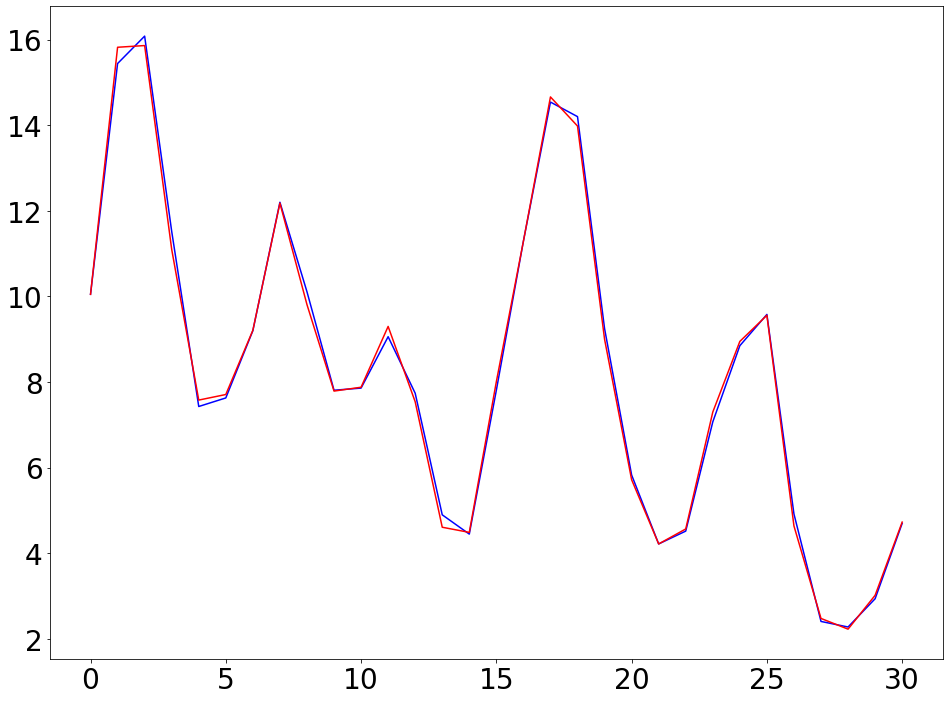

In [247]:
fig = plt.figure(1, figsize = (16,12))
plt.plot(range(31), tmax_mine, c="blue")
plt.plot(range(31), tmax_dp, c="red")

In [252]:
pet_mine = force_671.loc[(force_671["site_no"]==sites_671[0]) & 
             (force_671["datetime"]>="19801001") & 
             (force_671["datetime"]<"19811001"), "PET_hargreaves(mm/day)"].to_numpy()
pet_dp = np.array([1.4125440e+00, 2.1985238e+00, 1.4193293e+00, 9.9674916e-01,
       1.4139142e+00, 1.4386203e+00, 9.2326550e-01, 1.0868905e+00,
       1.1877877e+00, 7.0712686e-01, 1.1357592e+00, 1.0171895e+00,
       8.0903570e-01, 6.1233340e-01, 7.6871985e-01, 1.0754216e+00,
       1.1088841e+00, 1.5236787e+00, 1.1115363e+00, 7.6208670e-01,
       4.0546393e-01, 5.7597136e-01, 5.6510560e-01, 6.4571440e-01,
       9.1603476e-01, 7.7641840e-01, 5.9740910e-01, 4.4765276e-01,
       3.7854764e-01, 4.4981593e-01, 5.1102820e-01, 4.3313020e-01,
       3.3380446e-01, 4.1747272e-01, 7.8779876e-01, 7.4970780e-01,
       3.7199584e-01, 3.9047784e-01, 4.2690817e-01, 4.7722510e-01,
       3.5038128e-01, 3.1175238e-01, 4.4466344e-01, 4.2125353e-01,
       2.7404365e-01, 2.8189420e-01, 2.7109370e-01, 3.4604415e-01,
       2.9991153e-01, 2.2797287e-01, 3.1224903e-01, 3.7817330e-01,
       3.5497117e-01, 3.9185354e-01, 2.9010668e-01, 2.3633379e-01,
       3.6878526e-01, 2.4555327e-01, 2.8284556e-01, 2.8587285e-01,
       2.5741732e-01, 2.9021770e-01, 2.8668192e-01, 2.4409886e-01,
       3.0155066e-01, 1.5027933e-01, 2.5206584e-01, 2.8608218e-01,
       2.6461470e-01, 3.8876980e-01, 1.4897726e-01, 1.1649543e-01,
       0.0000000e+00, 1.3053660e-01, 9.4811090e-02, 0.0000000e+00,
       0.0000000e+00, 7.2144285e-02, 0.0000000e+00, 6.3814220e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.8152750e-02,
       2.0618413e-01, 0.0000000e+00, 0.0000000e+00, 1.0391288e-01,
       1.1058357e-01, 2.6330528e-01, 3.0481583e-01, 5.3538214e-02,
       1.4984136e-02, 1.4301333e-01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 3.6053345e-01, 2.4544384e-01,
       0.0000000e+00, 3.3491280e-02, 4.7686156e-02, 0.0000000e+00,
       0.0000000e+00, 4.8837570e-02, 0.0000000e+00, 2.8023536e-03,
       9.8860090e-02, 0.0000000e+00, 1.8998183e-01, 8.0109540e-02,
       2.5875296e-02, 1.8084410e-01, 2.1252431e-01, 1.8053094e-01,
       1.7981470e-01, 4.8480860e-01, 4.2753550e-01, 2.9607360e-01,
       8.0811925e-02, 7.1362200e-02, 7.9224630e-02, 2.7678310e-01,
       6.1799836e-01, 6.3960534e-01, 0.0000000e+00, 0.0000000e+00,
       1.5104696e-01, 2.9935023e-01, 4.8941990e-01, 3.2886955e-01,
       4.0930160e-01, 6.8440425e-01, 9.0201070e-01, 3.4898166e-02,
       2.4305880e-01, 2.3822382e-01, 7.1871126e-01, 6.0295230e-01,
       5.3710110e-01, 5.9509665e-01, 4.9777582e-01, 8.1753020e-01,
       1.1158168e+00, 1.2558200e+00, 1.0456133e+00, 8.0017570e-01,
       5.4359890e-01, 5.4067930e-01, 8.8372360e-01, 4.8485443e-01,
       5.2047336e-01, 3.8743094e-01, 5.6802773e-01, 5.8221745e-01,
       5.6512200e-01, 4.7596967e-01, 7.6759200e-01, 5.8063924e-01,
       4.7313088e-01, 4.8452684e-01, 5.0562690e-01, 7.2954630e-01,
       7.7257240e-01, 5.6670860e-01, 4.1096622e-01, 4.5677200e-01,
       7.0586280e-01, 8.6275667e-01, 6.2510580e-01, 5.6031360e-01,
       8.4848326e-01, 8.3987310e-01, 6.3571304e-01, 7.7501120e-01,
       1.3013772e+00, 1.0651103e+00, 1.2970089e+00, 1.2030821e+00,
       9.7026384e-01, 7.3616517e-01, 1.7866088e+00, 1.6577955e+00,
       1.7456895e+00, 2.2718976e+00, 1.8091621e+00, 2.1837926e+00,
       1.4536442e+00, 2.4693682e+00, 1.8161700e+00, 1.9398991e+00,
       2.1717508e+00, 1.7803111e+00, 1.6870342e+00, 1.7924191e+00,
       1.4953284e+00, 1.1366065e+00, 2.5420077e+00, 1.7806277e+00,
       1.7726821e+00, 7.9824080e-01, 9.3931070e-01, 1.3314612e+00,
       2.2073915e+00, 1.4057211e+00, 1.9565018e+00, 1.7576848e+00,
       1.8514739e+00, 2.0008836e+00, 1.5527272e+00, 1.9704344e+00,
       2.1151580e+00, 1.9270198e+00, 2.4631248e+00, 3.3188396e+00,
       3.9138463e+00, 4.0447555e+00, 2.5738342e+00, 3.8007727e+00,
       3.6364684e+00, 3.8351540e+00, 2.5314193e+00, 3.0928898e+00,
       2.2613132e+00, 2.2272854e+00, 3.8985230e+00, 2.6847477e+00,
       2.9571972e+00, 1.7212398e+00, 1.8725011e+00, 2.3651404e+00,
       3.7933164e+00, 2.4904182e+00, 3.6669505e+00, 4.4258080e+00,
       4.3063517e+00, 2.9902997e+00, 3.4104395e+00, 4.1694293e+00,
       3.9111310e+00, 3.8306973e+00, 3.3026420e+00, 3.3824835e+00,
       4.0926330e+00, 3.7320096e+00, 4.1519560e+00, 4.8049703e+00,
       3.5404904e+00, 3.1857355e+00, 3.5187306e+00, 3.1344717e+00,
       2.8232176e+00, 3.2354739e+00, 3.6047385e+00, 4.1716304e+00,
       4.2483090e+00, 3.1046210e+00, 3.6593292e+00, 3.1801553e+00,
       4.6004467e+00, 4.9280100e+00, 3.7776444e+00, 3.2831392e+00,
       3.2208354e+00, 2.3662114e+00, 3.5959140e+00, 4.0411660e+00,
       3.0707247e+00, 4.6377360e+00, 5.1493173e+00, 5.1607704e+00,
       4.4207110e+00, 4.2834060e+00, 4.6499900e+00, 5.0912730e+00,
       4.7223563e+00, 4.5739336e+00, 3.9958885e+00, 3.2761157e+00,
       4.6531850e+00, 4.9691877e+00, 4.4483560e+00, 3.8382113e+00,
       3.8418384e+00, 4.3374640e+00, 2.8101666e+00, 2.8947074e+00,
       3.6697910e+00, 5.0610704e+00, 4.5411224e+00, 3.8340480e+00,
       4.3364377e+00, 2.7301280e+00, 3.4174490e+00, 3.8046477e+00,
       4.5854316e+00, 4.7716503e+00, 4.5120240e+00, 3.0894590e+00,
       3.6716192e+00, 2.5128758e+00, 3.7315142e+00, 4.7600884e+00,
       4.5680385e+00, 3.9393399e+00, 3.5808926e+00, 3.3446858e+00,
       2.9985452e+00, 2.2581615e+00, 2.1591456e+00, 2.9288920e+00,
       3.5201879e+00, 3.4290752e+00, 3.8878064e+00, 2.8401650e+00,
       3.3173277e+00, 2.9235046e+00, 3.4010105e+00, 2.1994956e+00,
       2.2401185e+00, 2.8639393e+00, 3.8248854e+00, 3.8624916e+00,
       4.0424795e+00, 3.9688532e+00, 3.4413662e+00, 3.0262146e+00,
       3.1060827e+00, 3.6450446e+00, 2.4560444e+00, 2.6969360e+00,
       3.6505094e+00, 3.6516197e+00, 3.0067458e+00, 3.2735252e+00,
       2.8827658e+00, 3.2256474e+00, 3.3736272e+00, 2.8967700e+00,
       3.1601770e+00, 2.8119075e+00, 3.0220323e+00, 1.7139871e+00,
       2.2490625e+00, 1.8898174e+00, 2.2835166e+00, 2.6380877e+00,
       2.2295542e+00, 2.4599140e+00, 1.9722210e+00, 2.1231444e+00,
       1.7887151e+00, 1.6499754e+00, 1.4443088e+00, 1.5750864e+00,
       1.7748877e+00, 1.0322443e+00, 9.2864300e-01, 2.0247815e+00,
       1.9290845e+00, 1.7975705e+00, 1.8859245e+00, 1.0315574e+00,
       9.0457990e-01])


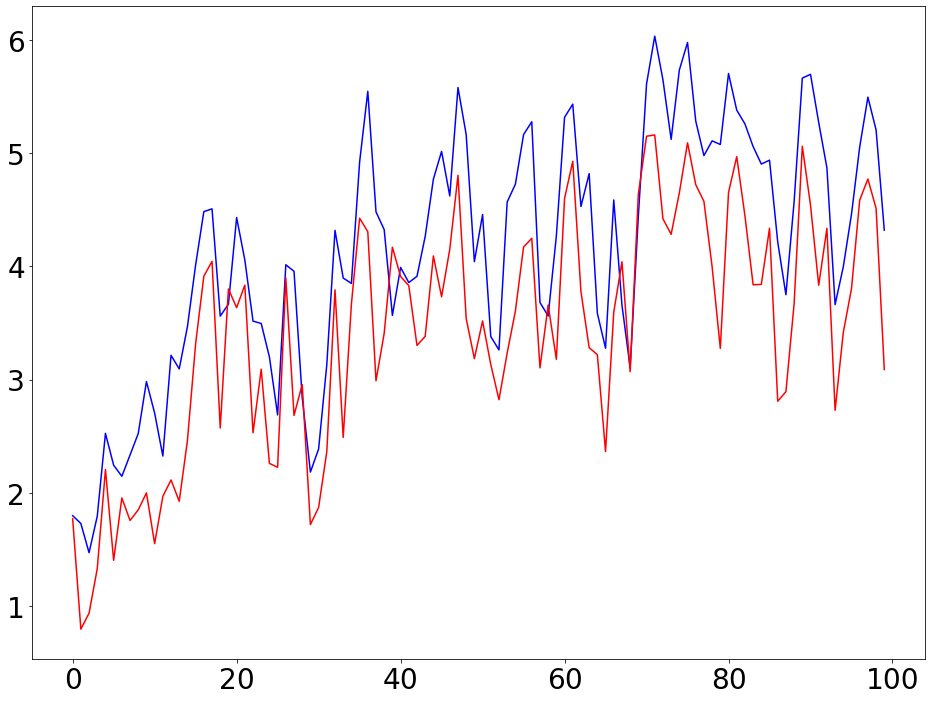

In [256]:
fig = plt.figure(1, figsize = (16,12))
plt.plot(range(100), pet_mine[200:300], c="blue")
plt.plot(range(100), pet_dp[200:300], c="red")

In [11]:
p1 = r"G:\Farshid\PGML_STemp_results\inputs\inputs_2003\dataset_20230923"

In [16]:
attr = pd.read_feather(os.path.join(p1, "attr_camels_all_sep14_2023.feather"))
attr2003 = pd.read_feather(os.path.join(p1, "attr_2003_fill_NaN.feather"))

In [13]:
attr.columns

Index(['site_no', 'lat', 'lon', 'ELEV_MEAN_M_BASIN', 'ELEV_MAX_M_BASIN',
       'ELEV_MIN_M_BASIN', 'ELEV_MEDIAN_M_BASIN', 'ELEV_STD_M_BASIN',
       'SLOPE_PCT', 'DRAIN_SQKM',
       ...
       'sand_frac', 'silt_frac', 'clay_frac', 'geol_1st_class',
       'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
       'carbonate_rocks_frac', 'geol_porostiy', 'geol_permeability'],
      dtype='object', length=120)

In [14]:
attrnewLst = [ 'p_mean','pet_mean','p_seasonality','frac_snow','aridity','high_prec_freq','high_prec_dur',
               'low_prec_freq','low_prec_dur', 'elev_mean', 'slope_mean', 'area_gages2', 'frac_forest', 'lai_max',
               'lai_diff', 'gvf_max', 'gvf_diff', 'dom_land_cover_frac', 'dom_land_cover', 'root_depth_50',
               'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
               'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'geol_1st_class', 'glim_1st_class_frac',
               'geol_2nd_class', 'glim_2nd_class_frac', 'carbonate_rocks_frac', 'geol_porostiy', 'geol_permeability']


In [5]:
p = r"/Users/taddbindas/projects/soils_work/lgar-py/data/agu_2023/"

In [7]:
attr = pd.read_feather(os.path.join(p, "camels_671_attr_site_no.feather"))

In [8]:
attr.columns

Index(['p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur',
       'elev_mean', 'slope_mean', 'area_gages2', 'frac_forest', 'lai_max',
       'lai_diff', 'gvf_max', 'gvf_diff', 'dom_land_cover_frac',
       'dom_land_cover', 'root_depth_50', 'soil_depth_pelletier',
       'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
       'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
       'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class',
       'glim_2nd_class_frac', 'carbonate_rocks_frac', 'geol_porostiy',
       'geol_permeability', 'site_no'],
      dtype='object')

In [9]:
force = pd.read_feather(os.path.join(p, "camels_671_forcing_pet.feather"))

In [10]:
force.columns

Index(['datetime', 'dayl(s)', 'prcp(mm/day)', 'srad(W/m2)', 'swe(mm)',
       'tmax(C)', 'tmin(C)', 'vp(Pa)', 'site_no', '00060_Mean', 'pet_nldas'],
      dtype='object')

In [8]:
sites40 = attr["site_no"].unique()[0:40]

In [9]:
attr40 = attr.loc[attr["site_no"].isin(sites40)].reset_index(drop=True)

In [25]:
attr40.to_feather(os.path.join(p, "camels_40_attr_site_no.feather"), compression="uncompressed")

In [26]:
force40 = force.loc[force["site_no"].isin(sites40)].reset_index(drop=True)

In [27]:
force40

datetime   dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)  tmax(C)  \
0      1980-01-01  30172.51           0.0      153.40      0.0    -6.54   
1      1980-01-02  30253.10           0.0      145.27      0.0    -6.18   
2      1980-01-03  30344.18           0.0      146.96      0.0    -9.89   
3      1980-01-04  30408.33           0.0      146.20      0.0   -10.98   
4      1980-01-05  30413.48           0.0      170.43      0.0   -11.29   
...           ...       ...           ...         ...      ...      ...   
511355 2014-12-27  32486.40           0.0      226.05      0.0     9.35   
511356 2014-12-28  32486.40           1.0      219.50      0.0    10.00   
511357 2014-12-29  32486.40           0.0      220.71      0.0     6.83   
511358 2014-12-30  32612.65           0.0      208.79      0.0     1.59   
511359 2014-12-31  32743.18           0.0      189.21      0.0    -1.84   

        tmin(C)  vp(Pa)   site_no  00060_Mean  pet_nldas  
0        -16.30  171.69  01013500       655.0   0.131711  
1        -15.22  185.94  01013500       640.0   0.170168  
2        -18.86  138.39  01013500       625.0   0.084095  
3        -19.76  120.06  01013500       620.0   0.028277  
4        -22.21  117.87  01013500       605.0   0.005334  
...         ...     ...       ...         ...        ...  
511355    -2.50  520.00  01440000        78.0   0.769884  
511356    -0.66  585.25  01440000        72.0   0.665702  
511357    -3.53  477.78  01440000        70.0   0.642837  
511358    -7.08  360.00  01440000        62.0   0.443081  
511359    -8.96  320.00  01440000        57.0   0.215866  

[511360 rows x 11 columns]

In [31]:
force40.to_feather(os.path.join(p, "camels_40_forcing_pet.feather"), compression="uncompressed")

In [34]:
force.loc[(force["datetime"]> "20121225") &
          (force["datetime"]< "20130105") & (force["site_no"]==sites40[0])]

datetime   dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)  tmax(C)  \
12048 2012-12-26  30042.52          0.00      142.65      0.0    -7.97   
12049 2012-12-27  30062.75         13.59      123.46      0.0    -6.88   
12050 2012-12-28  30067.20          8.20       92.08      0.0    -5.75   
12051 2012-12-29  30067.89          0.00      107.84      0.0    -6.23   
12052 2012-12-30  30107.30          3.45       93.14      0.0    -6.03   
12053 2012-12-31  30087.60          1.73      100.49      0.0    -6.13   
12054 2013-01-01  30172.51          5.51      115.49      0.0    -8.03   
12055 2013-01-02  30253.10          0.00      161.23      0.0   -11.37   
12056 2013-01-03  30344.18          0.00      116.56      0.0   -15.84   
12057 2013-01-04  30408.33          1.03      161.93      0.0   -12.95   

       tmin(C)  vp(Pa)   site_no  00060_Mean  pet_nldas  
12048   -16.18  165.69  01013500       708.0   0.109581  
12049   -17.04  160.00  01013500       708.0   0.170368  
12050   -12.23  241.37  01013500       730.0   0.188541  
12051   -11.69  246.31  01013500       725.0   0.283900  
12052   -12.16  242.04  01013500       713.0   0.146591  
12053   -11.92  244.17  01013500       708.0   0.183222  
12054   -16.96  160.00  01013500       700.0   0.143207  
12055   -21.45  120.00  01013500       684.0   0.025464  
12056   -22.49  117.99  01013500       665.0   0.000000  
12057   -23.44   80.00  01013500       650.0   0.109927

In [14]:
cols = ["site_no" , "aridity"]
attr_aridity = attr[cols]

In [26]:
attr_site = attr[attr["site_no"] == "06332515"]

In [27]:
attr_site_reset = attr_site.reset_index()
attr_site_reset.to_feather("/Users/taddbindas/projects/soils_work/lgar-py/data/agu_2023/06332515_attr.feather", compression = "uncompressed")

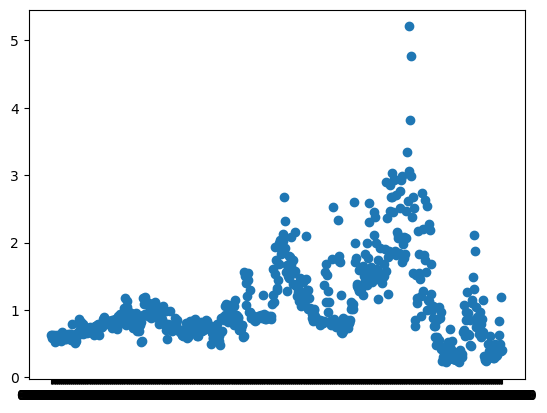

In [15]:
plt.scatter(attr_aridity["site_no"], attr_aridity["aridity"])
plt.show()

In [15]:
cols = ["datetime", "site_no" , "prcp(mm/day)", "pet_nldas"]
forcings_site = force[cols]

In [22]:
site_feather = force[force["site_no"] == "06332515"]
site_feather.head()

datetime   dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)  tmax(C)  \
4346560 1980-01-01  29721.59          0.00      166.78      0.0     1.12   
4346561 1980-01-02  29846.26          0.00      159.85      0.0    -4.37   
4346562 1980-01-03  30052.00          0.00      147.15      0.0    -5.97   
4346563 1980-01-04  30067.20          1.72      140.34      0.0    -3.38   
4346564 1980-01-05  30067.20          1.54      133.13      0.0    -8.36   

         tmin(C)  vp(Pa)   site_no  00060_Mean  pet_nldas  
4346560   -13.55  200.00  06332515        0.18   0.286298  
4346561   -17.52  160.00  06332515        0.16   0.218393  
4346562   -17.30  160.00  06332515        0.16   0.214017  
4346563   -13.93  200.95  06332515        0.14   0.253753  
4346564   -17.94  159.85  06332515        0.12   0.155343

In [24]:
site_feather_reset = site_feather.reset_index()
site_feather_reset.to_feather("/Users/taddbindas/projects/soils_work/lgar-py/data/agu_2023/06332515_daily_forcings.feather", compression = "uncompressed")